# Assignment-7 : Variational Auto-Encoder(VAE)

### Team Members
- Praveen Raghuvanshi (praveenraghuvanshi@gmail.com)
- Tusharkanta Biswal (Tusharkanta_biswal@stragure.com)
- Suman Kanukollu (sumankanukollu@gmail.com)
- Shubham Kothawade (kothawadeshub@gmail.com)

System Information
---

In [1]:
!nvidia-smi

Mon Oct  5 17:23:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu92 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


Mount google drive
---

In [4]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install libraries
---

**Helper**
- autotime : Prints cell execution time
- torchsummaryX : Prints model summary

In [5]:
!pip install ipython-autotime
%load_ext autotime

In [6]:
pip install torchsummaryX

time: 2.63 s


Set Device
---

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda
time: 3.91 ms


In [8]:
%cd '/content/drive/My Drive/eva-4/Phase-2/Session-7/temp'

/content/drive/My Drive/eva-4/Phase-2/Session-7/temp
time: 4.38 ms


In [9]:
!ls

model-vae-05-10-2020.pt  __pycache__  train_vae.py
time: 116 ms


All Imports
---

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image

from torchsummaryX import summary

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
matplotlib.style.use('ggplot')

time: 200 ms


Hyperparameters
---

In [11]:
epochs = 2000
batch_size = 32
lr = 0.0001

time: 1.59 ms


Load Dataset
---

In [12]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

time: 1.6 ms


In [13]:
# Load dataset
def loaddataset(root, transformation, batch_size=32, split_factor=0.7):
    dataset = torchvision.datasets.ImageFolder(root, transformation)
    train_size = int(split_factor * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    return (train_loader, val_loader, train_dataset, val_dataset)

time: 7.35 ms


In [14]:
datasetDirectory = '/content/drive/My Drive/eva-4/Phase-2/Session-7/Assignment-7/data/car_images'
(train_loader, val_loader, train_data, val_data) = loaddataset(datasetDirectory, transform)

time: 22.5 ms


Define Functions
---

In [15]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

time: 2.65 ms


In [16]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

time: 10 ms


In [17]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    savingIndex = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                
                both = torch.cat((data.view(batch_size, 3, 64, 64)[:8], 
                                  reconstruction.view(batch_size, 3, 64, 64)[:8]))
                save_image(both.cpu(), f"../outputs/vae/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

time: 14.8 ms


In [18]:
def save_model():
  print('Saving the model')
  traced_model = torch.jit.trace(model.to(device).float(), torch.Tensor(3 * 64 * 64).to(device))
  torch.jit.save(traced_model, 'model-vae.pt')

time: 2.17 ms


Define Model
---

In [19]:
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        '''# encoder
        self.enc1 = nn.Linear(in_features=3*64*64, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=3*64*64)'''

        # Encoder 
        self.encoder = nn. Sequential(
            nn.Linear(in_features=3*64*64, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=32)
        )

        # Decoder 
        self.decoder = nn. Sequential(
            nn.Linear(in_features=32, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=3*64*64)
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = self.encoder(x)

        # get `mu` and `log_var`
        mu = x
        log_var = x
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

time: 23.8 ms


Train model
---

In [20]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

time: 3.48 s


In [21]:
print(model)

LinearVAE(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=12288, bias=True)
  )
)
time: 2.24 ms


In [25]:
from torchsummaryX import summary
summary(model.to(device), torch.Tensor(3*64*64).to(device))

                    Kernel Shape Output Shape     Params  Mult-Adds
Layer                                                              
0_encoder.Linear_0  [12288, 512]        [512]  6.291968M  6.291456M
1_encoder.ReLU_1               -        [512]          -          -
2_encoder.Linear_2     [512, 32]         [32]    16.416k    16.384k
3_decoder.Linear_0     [32, 512]        [512]    16.896k    16.384k
4_decoder.ReLU_1               -        [512]          -          -
5_decoder.Linear_2  [512, 12288]      [12288]  6.303744M  6.291456M
-------------------------------------------------------------------
                          Totals
Total params          12.629024M
Trainable params      12.629024M
Non-trainable params         0.0
Mult-Adds              12.61568M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.Linear_0,"[12288, 512]",[512],6291968.0,6291456.0
1_encoder.ReLU_1,-,[512],NaN,NaN
2_encoder.Linear_2,"[512, 32]",[32],16416.0,16384.0
3_decoder.Linear_0,"[32, 512]",[512],16896.0,16384.0
4_decoder.ReLU_1,-,[512],NaN,NaN
5_decoder.Linear_2,"[512, 12288]",[12288],6303744.0,6291456.0


time: 77.4 ms


In [26]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1 of 2000


24it [06:32, 16.35s/it]
10it [02:40, 16.06s/it]
 13%|█▎        | 3/23 [00:00<00:00, 22.16it/s]

Train Loss: 8384.0913
Val Loss: 7937.7926
Epoch 2 of 2000


24it [00:01, 21.26it/s]
10it [00:00, 20.70it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.46it/s]

Train Loss: 7416.8627
Val Loss: 7019.0135
Epoch 3 of 2000


24it [00:01, 21.89it/s]                        
10it [00:00, 21.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.27it/s]

Train Loss: 6752.3038
Val Loss: 6562.5411
Epoch 4 of 2000


24it [00:01, 21.64it/s]                        
10it [00:00, 21.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.62it/s]

Train Loss: 6470.3362
Val Loss: 6369.4218
Epoch 5 of 2000


24it [00:01, 22.23it/s]                        
10it [00:00, 20.90it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.94it/s]

Train Loss: 6302.2381
Val Loss: 6287.6393
Epoch 6 of 2000


24it [00:01, 20.82it/s]                        
10it [00:00, 20.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.07it/s]

Train Loss: 6200.1680
Val Loss: 6165.4729
Epoch 7 of 2000


24it [00:01, 21.74it/s]                        
10it [00:00, 21.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.35it/s]

Train Loss: 6088.4890
Val Loss: 6081.1523
Epoch 8 of 2000


24it [00:01, 21.17it/s]                        
10it [00:00, 21.11it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.76it/s]

Train Loss: 6032.1968
Val Loss: 6024.3816
Epoch 9 of 2000


24it [00:01, 21.98it/s]                        
10it [00:00, 21.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.51it/s]

Train Loss: 5933.9676
Val Loss: 5989.3850
Epoch 10 of 2000


24it [00:01, 21.93it/s]                        
10it [00:00, 21.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 5870.6545
Val Loss: 5933.4277
Epoch 11 of 2000


24it [00:01, 22.19it/s]                        
10it [00:00, 20.82it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.57it/s]

Train Loss: 5813.5717
Val Loss: 5884.0704
Epoch 12 of 2000


24it [00:01, 22.04it/s]                        
10it [00:00, 20.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.19it/s]

Train Loss: 5757.4742
Val Loss: 5858.4448
Epoch 13 of 2000


24it [00:01, 21.74it/s]                        
10it [00:00, 20.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.63it/s]

Train Loss: 5722.3101
Val Loss: 5857.8904
Epoch 14 of 2000


24it [00:01, 22.46it/s]                        
10it [00:00, 20.85it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.50it/s]

Train Loss: 5688.0280
Val Loss: 5787.6653
Epoch 15 of 2000


24it [00:01, 21.65it/s]                        
10it [00:00, 21.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.01it/s]

Train Loss: 5636.3677
Val Loss: 5786.1693
Epoch 16 of 2000


24it [00:01, 21.41it/s]                        
10it [00:00, 20.49it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.50it/s]

Train Loss: 5609.3852
Val Loss: 5766.3028
Epoch 17 of 2000


24it [00:01, 20.82it/s]                        
10it [00:00, 20.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.76it/s]

Train Loss: 5584.6484
Val Loss: 5703.9474
Epoch 18 of 2000


24it [00:01, 21.03it/s]                        
10it [00:00, 16.62it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 17.76it/s]

Train Loss: 5567.1132
Val Loss: 5783.3056
Epoch 19 of 2000


24it [00:01, 21.51it/s]                        
10it [00:00, 21.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.44it/s]

Train Loss: 5533.1642
Val Loss: 5669.4141
Epoch 20 of 2000


24it [00:01, 21.37it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 5496.2615
Val Loss: 5688.7087
Epoch 21 of 2000


24it [00:01, 21.94it/s]                        
10it [00:00, 21.21it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 5492.6812
Val Loss: 5638.1619
Epoch 22 of 2000


24it [00:01, 21.96it/s]                        
10it [00:00, 21.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.57it/s]

Train Loss: 5460.1211
Val Loss: 5619.4063
Epoch 23 of 2000


24it [00:01, 21.17it/s]                        
10it [00:00, 21.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.42it/s]

Train Loss: 5434.7759
Val Loss: 5621.5440
Epoch 24 of 2000


24it [00:01, 21.87it/s]                        
10it [00:00, 20.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.60it/s]

Train Loss: 5425.0911
Val Loss: 5605.0065
Epoch 25 of 2000


24it [00:01, 22.57it/s]                        
10it [00:00, 21.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 5401.1543
Val Loss: 5583.5662
Epoch 26 of 2000


24it [00:01, 22.22it/s]                        
10it [00:00, 21.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.32it/s]

Train Loss: 5381.1430
Val Loss: 5553.1530
Epoch 27 of 2000


24it [00:01, 21.16it/s]                        
10it [00:00, 21.89it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.55it/s]

Train Loss: 5369.7881
Val Loss: 5552.4249
Epoch 28 of 2000


24it [00:01, 21.68it/s]                        
10it [00:00, 21.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.60it/s]

Train Loss: 5357.8704
Val Loss: 5560.5431
Epoch 29 of 2000


24it [00:01, 22.39it/s]                        
10it [00:00, 21.85it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.94it/s]

Train Loss: 5336.8605
Val Loss: 5514.5485
Epoch 30 of 2000


24it [00:01, 22.61it/s]                        
10it [00:00, 21.31it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.91it/s]

Train Loss: 5330.5084
Val Loss: 5532.7318
Epoch 31 of 2000


24it [00:01, 20.98it/s]                        
10it [00:00, 20.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.20it/s]

Train Loss: 5317.0056
Val Loss: 5519.4129
Epoch 32 of 2000


24it [00:01, 21.68it/s]                        
10it [00:00, 20.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.92it/s]

Train Loss: 5311.8798
Val Loss: 5499.9380
Epoch 33 of 2000


24it [00:01, 21.95it/s]                        
10it [00:00, 19.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.96it/s]

Train Loss: 5297.4912
Val Loss: 5571.9807
Epoch 34 of 2000


24it [00:01, 21.88it/s]                        
10it [00:00, 21.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.89it/s]

Train Loss: 5297.8466
Val Loss: 5491.3905
Epoch 35 of 2000


24it [00:01, 20.86it/s]
10it [00:00, 21.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.88it/s]

Train Loss: 5282.4436
Val Loss: 5487.5814
Epoch 36 of 2000


24it [00:01, 21.76it/s]                        
10it [00:00, 21.63it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.09it/s]

Train Loss: 5271.6954
Val Loss: 5484.6341
Epoch 37 of 2000


24it [00:01, 21.24it/s]                        
10it [00:00, 21.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.80it/s]

Train Loss: 5264.9112
Val Loss: 5497.8428
Epoch 38 of 2000


24it [00:01, 21.89it/s]
10it [00:00, 19.33it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.58it/s]

Train Loss: 5275.8429
Val Loss: 5478.0943
Epoch 39 of 2000


24it [00:01, 20.72it/s]                        
10it [00:00, 21.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.72it/s]

Train Loss: 5265.3823
Val Loss: 5694.7957
Epoch 40 of 2000


24it [00:01, 21.42it/s]                        
10it [00:00, 20.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.50it/s]

Train Loss: 5278.5585
Val Loss: 5458.1008
Epoch 41 of 2000


24it [00:01, 21.96it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.66it/s]

Train Loss: 5242.3214
Val Loss: 5473.0958
Epoch 42 of 2000


24it [00:01, 22.92it/s]
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.80it/s]

Train Loss: 5248.2607
Val Loss: 5442.9656
Epoch 43 of 2000


24it [00:01, 22.31it/s]                        
10it [00:00, 21.37it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.21it/s]

Train Loss: 5223.0938
Val Loss: 5441.5261
Epoch 44 of 2000


24it [00:01, 22.56it/s]                        
10it [00:00, 21.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.89it/s]

Train Loss: 5217.4181
Val Loss: 5439.7628
Epoch 45 of 2000


24it [00:01, 21.96it/s]                        
10it [00:00, 21.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.45it/s]

Train Loss: 5233.9474
Val Loss: 5443.9297
Epoch 46 of 2000


24it [00:01, 22.21it/s]                        
10it [00:00, 21.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.02it/s]

Train Loss: 5213.9306
Val Loss: 5442.6009
Epoch 47 of 2000


24it [00:01, 22.43it/s]
10it [00:00, 21.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.28it/s]

Train Loss: 5213.2810
Val Loss: 5466.4077
Epoch 48 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 21.61it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.04it/s]

Train Loss: 5191.1722
Val Loss: 5440.9725
Epoch 49 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 21.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.71it/s]

Train Loss: 5218.6834
Val Loss: 5506.3394
Epoch 50 of 2000


24it [00:01, 22.25it/s]
10it [00:00, 20.81it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.90it/s]

Train Loss: 5227.7446
Val Loss: 5415.7143
Epoch 51 of 2000


24it [00:01, 22.62it/s]                        
10it [00:00, 22.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.63it/s]

Train Loss: 5200.8289
Val Loss: 5423.1725
Epoch 52 of 2000


24it [00:01, 22.21it/s]                        
10it [00:00, 21.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 5188.0348
Val Loss: 5422.0020
Epoch 53 of 2000


24it [00:01, 22.68it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.43it/s]

Train Loss: 5185.0852
Val Loss: 5474.6228
Epoch 54 of 2000


24it [00:01, 22.57it/s]                        
10it [00:00, 21.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.32it/s]

Train Loss: 5171.0623
Val Loss: 5428.5510
Epoch 55 of 2000


24it [00:01, 22.43it/s]                        
10it [00:00, 22.25it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 17.80it/s]

Train Loss: 5163.2465
Val Loss: 5399.3760
Epoch 56 of 2000


24it [00:01, 21.64it/s]                        
10it [00:00, 16.08it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 5159.5082
Val Loss: 5440.7060
Epoch 57 of 2000


24it [00:01, 22.42it/s]                        
10it [00:00, 20.76it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.90it/s]

Train Loss: 5164.2533
Val Loss: 5409.3272
Epoch 58 of 2000


24it [00:01, 21.30it/s]                        
10it [00:00, 21.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.48it/s]

Train Loss: 5159.5706
Val Loss: 5391.2559
Epoch 59 of 2000


24it [00:01, 22.75it/s]                        
10it [00:00, 21.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 5144.1270
Val Loss: 5406.2837
Epoch 60 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.70it/s]

Train Loss: 5144.7184
Val Loss: 5442.7435
Epoch 61 of 2000


24it [00:01, 22.24it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.83it/s]

Train Loss: 5139.9859
Val Loss: 5417.3368
Epoch 62 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 5141.8647
Val Loss: 5440.6480
Epoch 63 of 2000


24it [00:01, 22.30it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 5127.8569
Val Loss: 5440.5019
Epoch 64 of 2000


24it [00:01, 22.33it/s]                        
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.27it/s]

Train Loss: 5126.6541
Val Loss: 5408.7479
Epoch 65 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 20.66it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 5120.2845
Val Loss: 5435.6819
Epoch 66 of 2000


24it [00:01, 22.32it/s]                        
10it [00:00, 20.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.68it/s]

Train Loss: 5116.7307
Val Loss: 5375.0007
Epoch 67 of 2000


24it [00:01, 21.74it/s]                        
10it [00:00, 20.24it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.33it/s]

Train Loss: 5108.2666
Val Loss: 5370.9230
Epoch 68 of 2000


24it [00:01, 21.54it/s]                        
10it [00:00, 20.39it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.25it/s]

Train Loss: 5119.6270
Val Loss: 5465.4337
Epoch 69 of 2000


24it [00:01, 21.31it/s]                        
10it [00:00, 20.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.03it/s]

Train Loss: 5110.6138
Val Loss: 5441.7038
Epoch 70 of 2000


24it [00:01, 22.36it/s]                        
10it [00:00, 19.47it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 5116.2227
Val Loss: 5364.7462
Epoch 71 of 2000


24it [00:01, 22.39it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.28it/s]

Train Loss: 5101.3842
Val Loss: 5434.0871
Epoch 72 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 20.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 5109.1131
Val Loss: 5386.8431
Epoch 73 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 23.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 5093.0408
Val Loss: 5363.9167
Epoch 74 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 21.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 5099.8024
Val Loss: 5402.8451
Epoch 75 of 2000


24it [00:01, 22.99it/s]
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.42it/s]

Train Loss: 5086.8013
Val Loss: 5358.4472
Epoch 76 of 2000


24it [00:01, 22.64it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.23it/s]

Train Loss: 5082.0632
Val Loss: 5344.9790
Epoch 77 of 2000


24it [00:01, 22.44it/s]                        
10it [00:00, 21.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.66it/s]

Train Loss: 5082.8274
Val Loss: 5381.2295
Epoch 78 of 2000


24it [00:01, 22.39it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.12it/s]

Train Loss: 5080.4040
Val Loss: 5341.3427
Epoch 79 of 2000


24it [00:01, 21.49it/s]                        
10it [00:00, 20.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.23it/s]

Train Loss: 5084.6657
Val Loss: 5373.7940
Epoch 80 of 2000


24it [00:01, 22.00it/s]                        
10it [00:00, 21.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.22it/s]

Train Loss: 5067.4625
Val Loss: 5360.4731
Epoch 81 of 2000


24it [00:01, 22.85it/s]                        
10it [00:00, 22.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 5060.6438
Val Loss: 5420.1010
Epoch 82 of 2000


24it [00:01, 22.41it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 5059.3623
Val Loss: 5381.5640
Epoch 83 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 16.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 5062.3638
Val Loss: 5341.6123
Epoch 84 of 2000


24it [00:01, 22.62it/s]
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.96it/s]

Train Loss: 5068.4710
Val Loss: 5374.2073
Epoch 85 of 2000


24it [00:01, 22.63it/s]
10it [00:00, 21.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.20it/s]

Train Loss: 5056.8928
Val Loss: 5385.8598
Epoch 86 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 21.57it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.60it/s]

Train Loss: 5054.9741
Val Loss: 5401.3237
Epoch 87 of 2000


24it [00:01, 22.34it/s]                        
10it [00:00, 21.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 5043.1140
Val Loss: 5347.6490
Epoch 88 of 2000


24it [00:01, 22.49it/s]                        
10it [00:00, 21.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 5040.1906
Val Loss: 5336.5674
Epoch 89 of 2000


24it [00:01, 22.61it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.75it/s]

Train Loss: 5048.0863
Val Loss: 5385.2254
Epoch 90 of 2000


24it [00:01, 22.43it/s]                        
10it [00:00, 21.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 5059.1893
Val Loss: 5320.5004
Epoch 91 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.27it/s]

Train Loss: 5043.6863
Val Loss: 5314.2391
Epoch 92 of 2000


24it [00:01, 22.56it/s]                        
10it [00:00, 21.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 5051.2076
Val Loss: 5337.3630
Epoch 93 of 2000


24it [00:01, 22.78it/s]
10it [00:00, 22.50it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.25it/s]

Train Loss: 5035.2809
Val Loss: 5310.2812
Epoch 94 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.06it/s]

Train Loss: 5032.0695
Val Loss: 5347.1094
Epoch 95 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.69it/s]

Train Loss: 5036.1567
Val Loss: 5344.6648
Epoch 96 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 21.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 5026.4927
Val Loss: 5327.4907
Epoch 97 of 2000


24it [00:01, 22.68it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.26it/s]

Train Loss: 5022.2977
Val Loss: 5312.8343
Epoch 98 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 21.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.12it/s]

Train Loss: 5023.2021
Val Loss: 5324.8495
Epoch 99 of 2000


24it [00:01, 22.69it/s]
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.48it/s]

Train Loss: 5015.2166
Val Loss: 5339.8614
Epoch 100 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 21.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.21it/s]

Train Loss: 5013.1310
Val Loss: 5343.6100
Epoch 101 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 21.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 5008.9023
Val Loss: 5346.1184
Epoch 102 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 21.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.98it/s]

Train Loss: 5018.7110
Val Loss: 5346.4580
Epoch 103 of 2000


24it [00:01, 22.28it/s]                        
10it [00:00, 21.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 5010.8295
Val Loss: 5371.5969
Epoch 104 of 2000


24it [00:01, 22.51it/s]
10it [00:00, 20.95it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.73it/s]

Train Loss: 5012.4877
Val Loss: 5346.9290
Epoch 105 of 2000


24it [00:01, 22.30it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.39it/s]

Train Loss: 5001.2785
Val Loss: 5288.1958
Epoch 106 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 21.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.12it/s]

Train Loss: 4997.2553
Val Loss: 5345.8442
Epoch 107 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.76it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.75it/s]

Train Loss: 4999.3990
Val Loss: 5305.2902
Epoch 108 of 2000


24it [00:01, 22.40it/s]                        
10it [00:00, 21.02it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4999.4714
Val Loss: 5330.1316
Epoch 109 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4990.1948
Val Loss: 5308.4552
Epoch 110 of 2000


24it [00:01, 23.31it/s]
10it [00:00, 21.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.33it/s]

Train Loss: 4991.3846
Val Loss: 5306.0642
Epoch 111 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 17.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.95it/s]

Train Loss: 4988.1787
Val Loss: 5360.7996
Epoch 112 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4994.5249
Val Loss: 5372.5395
Epoch 113 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4978.4569
Val Loss: 5323.6385
Epoch 114 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 4976.3555
Val Loss: 5274.2154
Epoch 115 of 2000


24it [00:01, 23.04it/s]
10it [00:00, 22.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 5039.4631
Val Loss: 5264.4110
Epoch 116 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 21.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.17it/s]

Train Loss: 4988.9795
Val Loss: 5302.2255
Epoch 117 of 2000


24it [00:01, 22.86it/s]
10it [00:00, 21.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4975.1579
Val Loss: 5289.6029
Epoch 118 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 21.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.77it/s]

Train Loss: 4982.3554
Val Loss: 5294.0586
Epoch 119 of 2000


24it [00:01, 23.02it/s]
10it [00:00, 23.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4966.4756
Val Loss: 5348.9927
Epoch 120 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.31it/s]

Train Loss: 4974.9145
Val Loss: 5310.8288
Epoch 121 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.03it/s]

Train Loss: 4968.9764
Val Loss: 5347.4523
Epoch 122 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.90it/s]

Train Loss: 4976.7875
Val Loss: 5340.0185
Epoch 123 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4977.7056
Val Loss: 5297.2081
Epoch 124 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.95it/s]

Train Loss: 4963.8065
Val Loss: 5314.4588
Epoch 125 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 17.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.37it/s]

Train Loss: 4961.7579
Val Loss: 5276.8801
Epoch 126 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 21.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.60it/s]

Train Loss: 4953.2683
Val Loss: 5283.3864
Epoch 127 of 2000


24it [00:01, 21.51it/s]                        
10it [00:00, 21.01it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.48it/s]

Train Loss: 4956.1908
Val Loss: 5303.1243
Epoch 128 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.81it/s]

Train Loss: 4964.8534
Val Loss: 5266.9775
Epoch 129 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4952.0528
Val Loss: 5258.8310
Epoch 130 of 2000


24it [00:01, 22.89it/s]
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4952.5956
Val Loss: 5294.6754
Epoch 131 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.61it/s]

Train Loss: 4955.7869
Val Loss: 5312.6712
Epoch 132 of 2000


24it [00:01, 22.59it/s]
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.26it/s]

Train Loss: 4947.7565
Val Loss: 5284.5953
Epoch 133 of 2000


24it [00:01, 23.27it/s]
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4947.4842
Val Loss: 5272.7825
Epoch 134 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.63it/s]

Train Loss: 4938.0545
Val Loss: 5287.3371
Epoch 135 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 21.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.10it/s]

Train Loss: 4939.5117
Val Loss: 5267.5708
Epoch 136 of 2000


24it [00:01, 22.51it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4937.1397
Val Loss: 5246.5417
Epoch 137 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 21.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 4953.6162
Val Loss: 5394.4468
Epoch 138 of 2000


24it [00:01, 22.20it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4948.4642
Val Loss: 5261.7800
Epoch 139 of 2000


24it [00:01, 22.12it/s]                        
10it [00:00, 19.06it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 4937.9308
Val Loss: 5260.8989
Epoch 140 of 2000


24it [00:01, 22.12it/s]
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4935.5243
Val Loss: 5315.0267
Epoch 141 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 21.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.76it/s]

Train Loss: 4932.7434
Val Loss: 5284.8553
Epoch 142 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4928.5354
Val Loss: 5242.7703
Epoch 143 of 2000


24it [00:01, 22.46it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4934.9210
Val Loss: 5287.1202
Epoch 144 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 22.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.48it/s]

Train Loss: 4962.0975
Val Loss: 5263.7193
Epoch 145 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.42it/s]

Train Loss: 4933.3979
Val Loss: 5247.8235
Epoch 146 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 22.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4930.3846
Val Loss: 5294.1210
Epoch 147 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4920.6115
Val Loss: 5259.9518
Epoch 148 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4913.6250
Val Loss: 5294.5171
Epoch 149 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4922.9922
Val Loss: 5248.5602
Epoch 150 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4924.8609
Val Loss: 5275.3444
Epoch 151 of 2000


24it [00:01, 23.60it/s]                        
10it [00:00, 22.00it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.73it/s]

Train Loss: 4918.9791
Val Loss: 5262.3347
Epoch 152 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4909.7022
Val Loss: 5243.8167
Epoch 153 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4913.6784
Val Loss: 5257.8800
Epoch 154 of 2000


24it [00:01, 20.02it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.99it/s]

Train Loss: 4913.7092
Val Loss: 5268.7186
Epoch 155 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 21.99it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4906.1294
Val Loss: 5268.0983
Epoch 156 of 2000


24it [00:01, 22.86it/s]
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.83it/s]

Train Loss: 4912.4707
Val Loss: 5307.5505
Epoch 157 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 21.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.36it/s]

Train Loss: 4900.4790
Val Loss: 5245.0563
Epoch 158 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.08it/s]

Train Loss: 4900.1896
Val Loss: 5252.8372
Epoch 159 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4907.8683
Val Loss: 5234.5382
Epoch 160 of 2000


24it [00:01, 23.84it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4908.6702
Val Loss: 5270.8819
Epoch 161 of 2000


24it [00:00, 24.09it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4902.3973
Val Loss: 5245.0634
Epoch 162 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 21.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.25it/s]

Train Loss: 4903.5730
Val Loss: 5255.3271
Epoch 163 of 2000


24it [00:01, 22.47it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.23it/s]

Train Loss: 4909.6981
Val Loss: 5236.1006
Epoch 164 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 20.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.49it/s]

Train Loss: 4891.6861
Val Loss: 5307.9073
Epoch 165 of 2000


24it [00:01, 22.34it/s]                        
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4898.0226
Val Loss: 5341.8802
Epoch 166 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4889.8670
Val Loss: 5259.7320
Epoch 167 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.91it/s]

Train Loss: 4892.3444
Val Loss: 5245.7005
Epoch 168 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 21.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.45it/s]

Train Loss: 4889.8178
Val Loss: 5307.8438
Epoch 169 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4896.7731
Val Loss: 5226.7307
Epoch 170 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.36it/s]

Train Loss: 4881.0663
Val Loss: 5296.2045
Epoch 171 of 2000


24it [00:01, 23.28it/s]
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4889.0873
Val Loss: 5307.7364
Epoch 172 of 2000


24it [00:01, 23.75it/s]
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.68it/s]

Train Loss: 4890.5549
Val Loss: 5282.9510
Epoch 173 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.67it/s]

Train Loss: 4879.2473
Val Loss: 5239.4652
Epoch 174 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 4881.7505
Val Loss: 5259.1534
Epoch 175 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 22.21it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.56it/s]

Train Loss: 4873.5582
Val Loss: 5251.8577
Epoch 176 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4874.7713
Val Loss: 5244.5612
Epoch 177 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.50it/s]

Train Loss: 4876.1317
Val Loss: 5233.3799
Epoch 178 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.69it/s]

Train Loss: 4885.4252
Val Loss: 5251.5596
Epoch 179 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 21.38it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.12it/s]

Train Loss: 4872.7260
Val Loss: 5219.2587
Epoch 180 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.69it/s]

Train Loss: 4875.2683
Val Loss: 5245.9844
Epoch 181 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.91it/s]

Train Loss: 4874.6354
Val Loss: 5242.9238
Epoch 182 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4873.0023
Val Loss: 5213.7567
Epoch 183 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.16it/s]

Train Loss: 4871.4236
Val Loss: 5259.5938
Epoch 184 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 22.76it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.70it/s]

Train Loss: 4866.9361
Val Loss: 5216.3575
Epoch 185 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4867.9920
Val Loss: 5212.8331
Epoch 186 of 2000


24it [00:01, 22.90it/s]
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4871.3304
Val Loss: 5222.1354
Epoch 187 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.70it/s]

Train Loss: 4862.1808
Val Loss: 5259.8778
Epoch 188 of 2000


24it [00:01, 22.61it/s]
10it [00:00, 18.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.52it/s]

Train Loss: 4857.4970
Val Loss: 5264.7536
Epoch 189 of 2000


24it [00:01, 20.96it/s]                        
10it [00:00, 19.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.97it/s]

Train Loss: 4858.0056
Val Loss: 5282.4195
Epoch 190 of 2000


24it [00:01, 20.47it/s]                        
10it [00:00, 19.48it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.56it/s]

Train Loss: 4853.0428
Val Loss: 5267.7287
Epoch 191 of 2000


24it [00:01, 19.78it/s]                        
10it [00:00, 18.77it/s]
  9%|▊         | 2/23 [00:00<00:01, 18.03it/s]

Train Loss: 4859.6858
Val Loss: 5225.9115
Epoch 192 of 2000


24it [00:01, 20.11it/s]                        
10it [00:00, 18.00it/s]
  9%|▊         | 2/23 [00:00<00:01, 18.19it/s]

Train Loss: 4864.3877
Val Loss: 5214.9090
Epoch 193 of 2000


24it [00:01, 19.94it/s]                        
10it [00:00, 19.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.24it/s]

Train Loss: 4869.4335
Val Loss: 5226.8122
Epoch 194 of 2000


24it [00:01, 20.53it/s]                        
10it [00:00, 20.15it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4848.1198
Val Loss: 5237.4478
Epoch 195 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 16.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.94it/s]

Train Loss: 4848.2762
Val Loss: 5219.6531
Epoch 196 of 2000


24it [00:01, 22.79it/s]                        
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4848.8346
Val Loss: 5206.3777
Epoch 197 of 2000


24it [00:01, 22.99it/s]
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4849.5841
Val Loss: 5221.0651
Epoch 198 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 21.22it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.12it/s]

Train Loss: 4848.2884
Val Loss: 5210.6891
Epoch 199 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 22.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.38it/s]

Train Loss: 4841.1697
Val Loss: 5280.2889
Epoch 200 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 23.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.21it/s]

Train Loss: 4843.3262
Val Loss: 5263.8907
Epoch 201 of 2000


24it [00:01, 23.92it/s]                        
10it [00:00, 23.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.98it/s]

Train Loss: 4844.3280
Val Loss: 5250.5207
Epoch 202 of 2000


24it [00:01, 23.49it/s]
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.78it/s]

Train Loss: 4839.2478
Val Loss: 5228.0140
Epoch 203 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4838.3437
Val Loss: 5246.5647
Epoch 204 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 21.34it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.70it/s]

Train Loss: 4847.6725
Val Loss: 5263.6684
Epoch 205 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.81it/s]

Train Loss: 4839.7909
Val Loss: 5258.9144
Epoch 206 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.87it/s]

Train Loss: 4837.8153
Val Loss: 5275.5065
Epoch 207 of 2000


24it [00:01, 23.91it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.90it/s]

Train Loss: 4829.9670
Val Loss: 5208.6429
Epoch 208 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 21.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4852.3720
Val Loss: 5275.5415
Epoch 209 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 23.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.78it/s]

Train Loss: 4839.4956
Val Loss: 5321.6296
Epoch 210 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 18.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4836.2356
Val Loss: 5312.7722
Epoch 211 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 23.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4840.6263
Val Loss: 5285.0714
Epoch 212 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4827.1685
Val Loss: 5228.6786
Epoch 213 of 2000


24it [00:01, 22.88it/s]
10it [00:00, 22.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4825.4293
Val Loss: 5246.1432
Epoch 214 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.68it/s]

Train Loss: 4823.9882
Val Loss: 5198.9317
Epoch 215 of 2000


24it [00:01, 23.88it/s]                        
10it [00:00, 21.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.79it/s]

Train Loss: 4831.6534
Val Loss: 5225.8813
Epoch 216 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 23.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.91it/s]

Train Loss: 4824.1595
Val Loss: 5258.6036
Epoch 217 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 21.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4825.0780
Val Loss: 5238.1489
Epoch 218 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 22.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.85it/s]

Train Loss: 4822.5681
Val Loss: 5239.9561
Epoch 219 of 2000


24it [00:01, 23.12it/s]
10it [00:00, 21.47it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4821.5190
Val Loss: 5227.5113
Epoch 220 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.51it/s]

Train Loss: 4815.5609
Val Loss: 5264.8782
Epoch 221 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4818.7328
Val Loss: 5180.6754
Epoch 222 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 23.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 4828.3797
Val Loss: 5189.7044
Epoch 223 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 21.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4813.7909
Val Loss: 5220.8247
Epoch 224 of 2000


24it [00:01, 23.33it/s]
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4820.2075
Val Loss: 5245.9036
Epoch 225 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.83it/s]

Train Loss: 4819.8533
Val Loss: 5196.7697
Epoch 226 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.64it/s]

Train Loss: 4808.4897
Val Loss: 5236.0968
Epoch 227 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 22.77it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.70it/s]

Train Loss: 4807.6889
Val Loss: 5243.0113
Epoch 228 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.53it/s]

Train Loss: 4808.3426
Val Loss: 5263.6127
Epoch 229 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.95it/s]

Train Loss: 4803.3485
Val Loss: 5275.6583
Epoch 230 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 20.84it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4814.6243
Val Loss: 5214.8133
Epoch 231 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 23.30it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.47it/s]

Train Loss: 4808.3238
Val Loss: 5276.0216
Epoch 232 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4802.8453
Val Loss: 5208.5765
Epoch 233 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4806.4835
Val Loss: 5255.6703
Epoch 234 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 21.35it/s]
 13%|█▎        | 3/23 [00:00<00:01, 19.92it/s]

Train Loss: 4802.6256
Val Loss: 5185.8781
Epoch 235 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 21.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.67it/s]

Train Loss: 4796.9552
Val Loss: 5218.4929
Epoch 236 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.17it/s]

Train Loss: 4796.6222
Val Loss: 5224.6562
Epoch 237 of 2000


24it [00:01, 22.50it/s]                        
10it [00:00, 17.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4804.3275
Val Loss: 5202.8115
Epoch 238 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 4804.1564
Val Loss: 5184.4057
Epoch 239 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.37it/s]

Train Loss: 4794.7534
Val Loss: 5233.6429
Epoch 240 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.23it/s]

Train Loss: 4791.0771
Val Loss: 5252.1496
Epoch 241 of 2000


24it [00:01, 22.63it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.90it/s]

Train Loss: 4793.7078
Val Loss: 5257.3387
Epoch 242 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4789.5511
Val Loss: 5289.6101
Epoch 243 of 2000


24it [00:01, 22.58it/s]                        
10it [00:00, 21.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.37it/s]

Train Loss: 4792.8131
Val Loss: 5210.3639
Epoch 244 of 2000


24it [00:01, 22.19it/s]                        
10it [00:00, 21.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.62it/s]

Train Loss: 4792.6270
Val Loss: 5222.7672
Epoch 245 of 2000


24it [00:01, 22.06it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.77it/s]

Train Loss: 4790.4346
Val Loss: 5189.7162
Epoch 246 of 2000


24it [00:01, 22.70it/s]                        
10it [00:00, 20.56it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.73it/s]

Train Loss: 4791.2515
Val Loss: 5219.3080
Epoch 247 of 2000


24it [00:01, 22.93it/s]
10it [00:00, 22.62it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.44it/s]

Train Loss: 4795.6023
Val Loss: 5220.0567
Epoch 248 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.09it/s]

Train Loss: 4797.0979
Val Loss: 5298.8162
Epoch 249 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4786.0989
Val Loss: 5206.7150
Epoch 250 of 2000


24it [00:01, 22.49it/s]                        
10it [00:00, 23.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4785.3007
Val Loss: 5241.1352
Epoch 251 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 17.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.29it/s]

Train Loss: 4786.7942
Val Loss: 5209.4780
Epoch 252 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.45it/s]

Train Loss: 4782.7010
Val Loss: 5250.5909
Epoch 253 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.52it/s]

Train Loss: 4790.6190
Val Loss: 5254.3595
Epoch 254 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4777.7875
Val Loss: 5224.4989
Epoch 255 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 21.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4780.4960
Val Loss: 5209.8005
Epoch 256 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.29it/s]

Train Loss: 4779.0020
Val Loss: 5215.3326
Epoch 257 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.06it/s]

Train Loss: 4777.5799
Val Loss: 5248.5334
Epoch 258 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4773.0548
Val Loss: 5247.6288
Epoch 259 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4775.8684
Val Loss: 5256.8791
Epoch 260 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 23.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.22it/s]

Train Loss: 4779.3249
Val Loss: 5268.8683
Epoch 261 of 2000


24it [00:01, 22.81it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4770.9997
Val Loss: 5214.1719
Epoch 262 of 2000


24it [00:01, 23.95it/s]
10it [00:00, 23.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.63it/s]

Train Loss: 4779.9665
Val Loss: 5233.0537
Epoch 263 of 2000


24it [00:01, 22.72it/s]                        
10it [00:00, 21.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 4768.9928
Val Loss: 5338.4274
Epoch 264 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4774.4247
Val Loss: 5309.1469
Epoch 265 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4769.4316
Val Loss: 5254.5976
Epoch 266 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 20.74it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.78it/s]

Train Loss: 4768.6215
Val Loss: 5217.0575
Epoch 267 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.55it/s]

Train Loss: 4771.1565
Val Loss: 5180.0700
Epoch 268 of 2000


24it [00:01, 22.18it/s]                        
10it [00:00, 20.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.57it/s]

Train Loss: 4764.7513
Val Loss: 5243.3423
Epoch 269 of 2000


24it [00:01, 22.56it/s]                        
10it [00:00, 21.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.93it/s]

Train Loss: 4764.9686
Val Loss: 5239.5084
Epoch 270 of 2000


24it [00:01, 22.02it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.22it/s]

Train Loss: 4768.4521
Val Loss: 5206.6506
Epoch 271 of 2000


24it [00:01, 21.97it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.71it/s]

Train Loss: 4760.7935
Val Loss: 5203.3906
Epoch 272 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4764.4905
Val Loss: 5202.7258
Epoch 273 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 23.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4768.5114
Val Loss: 5232.1626
Epoch 274 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4764.3156
Val Loss: 5231.0491
Epoch 275 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.43it/s]

Train Loss: 4759.6082
Val Loss: 5267.4511
Epoch 276 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.22it/s]

Train Loss: 4763.1820
Val Loss: 5241.8993
Epoch 277 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.84it/s]

Train Loss: 4757.3809
Val Loss: 5262.4531
Epoch 278 of 2000


24it [00:01, 22.78it/s]                        
10it [00:00, 22.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.55it/s]

Train Loss: 4759.4417
Val Loss: 5208.0924
Epoch 279 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.86it/s]

Train Loss: 4758.8706
Val Loss: 5232.9205
Epoch 280 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4765.5736
Val Loss: 5252.8314
Epoch 281 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 23.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4764.0371
Val Loss: 5208.1073
Epoch 282 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.80it/s]

Train Loss: 4754.5175
Val Loss: 5232.5782
Epoch 283 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 21.40it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4755.2330
Val Loss: 5234.6085
Epoch 284 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4750.0225
Val Loss: 5241.9488
Epoch 285 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4753.7623
Val Loss: 5283.5775
Epoch 286 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 21.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.78it/s]

Train Loss: 4757.4244
Val Loss: 5217.1390
Epoch 287 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4761.4880
Val Loss: 5193.1958
Epoch 288 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.69it/s]

Train Loss: 4750.2389
Val Loss: 5185.6002
Epoch 289 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4748.2309
Val Loss: 5183.6266
Epoch 290 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.59it/s]

Train Loss: 4744.1768
Val Loss: 5219.6194
Epoch 291 of 2000


24it [00:01, 22.52it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4749.4312
Val Loss: 5276.9273
Epoch 292 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4752.1574
Val Loss: 5281.1519
Epoch 293 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 22.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.59it/s]

Train Loss: 4763.3073
Val Loss: 5270.1004
Epoch 294 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 19.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4746.5055
Val Loss: 5305.1633
Epoch 295 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.89it/s]

Train Loss: 4742.2015
Val Loss: 5269.1469
Epoch 296 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 21.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4743.5884
Val Loss: 5268.3544
Epoch 297 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 21.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.18it/s]

Train Loss: 4746.7902
Val Loss: 5207.3977
Epoch 298 of 2000


24it [00:01, 22.59it/s]                        
10it [00:00, 21.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.29it/s]

Train Loss: 4742.5193
Val Loss: 5216.6844
Epoch 299 of 2000


24it [00:01, 22.63it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.32it/s]

Train Loss: 4737.8352
Val Loss: 5219.0893
Epoch 300 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4738.8265
Val Loss: 5253.2725
Epoch 301 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.75it/s]

Train Loss: 4741.8925
Val Loss: 5219.9678
Epoch 302 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.23it/s]

Train Loss: 4739.2649
Val Loss: 5202.1340
Epoch 303 of 2000


24it [00:01, 22.57it/s]                        
10it [00:00, 22.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.63it/s]

Train Loss: 4735.9512
Val Loss: 5224.3621
Epoch 304 of 2000


24it [00:01, 22.85it/s]                        
10it [00:00, 21.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.52it/s]

Train Loss: 4731.3967
Val Loss: 5243.4129
Epoch 305 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.42it/s]

Train Loss: 4736.9303
Val Loss: 5243.7932
Epoch 306 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.48it/s]

Train Loss: 4732.0276
Val Loss: 5218.1877
Epoch 307 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.87it/s]

Train Loss: 4731.2840
Val Loss: 5232.1683
Epoch 308 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 21.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4737.3327
Val Loss: 5323.8699
Epoch 309 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4732.0319
Val Loss: 5218.1784
Epoch 310 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.88it/s]

Train Loss: 4728.8245
Val Loss: 5194.5465
Epoch 311 of 2000


24it [00:01, 23.29it/s]
10it [00:00, 23.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.43it/s]

Train Loss: 4732.3458
Val Loss: 5249.7173
Epoch 312 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 23.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4727.5731
Val Loss: 5239.6683
Epoch 313 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 21.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 4732.1858
Val Loss: 5312.1066
Epoch 314 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4736.9359
Val Loss: 5228.3527
Epoch 315 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 21.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.15it/s]

Train Loss: 4724.9507
Val Loss: 5226.7027
Epoch 316 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 21.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 4724.6548
Val Loss: 5197.4816
Epoch 317 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.20it/s]

Train Loss: 4728.5445
Val Loss: 5212.5141
Epoch 318 of 2000


24it [00:01, 22.51it/s]                        
10it [00:00, 23.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.73it/s]

Train Loss: 4725.0292
Val Loss: 5224.0887
Epoch 319 of 2000


24it [00:01, 22.64it/s]                        
10it [00:00, 21.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4729.1914
Val Loss: 5219.5159
Epoch 320 of 2000


24it [00:01, 23.71it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4725.8378
Val Loss: 5193.7239
Epoch 321 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 21.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4721.0523
Val Loss: 5192.4752
Epoch 322 of 2000


24it [00:00, 24.13it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4723.3395
Val Loss: 5212.3755
Epoch 323 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.52it/s]

Train Loss: 4722.3732
Val Loss: 5237.1362
Epoch 324 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 21.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4723.7444
Val Loss: 5240.1460
Epoch 325 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.64it/s]

Train Loss: 4718.0125
Val Loss: 5209.0748
Epoch 326 of 2000


24it [00:01, 21.99it/s]                        
10it [00:00, 21.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4714.5157
Val Loss: 5242.9285
Epoch 327 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.48it/s]

Train Loss: 4716.0086
Val Loss: 5212.1587
Epoch 328 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 21.83it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4718.2401
Val Loss: 5228.3443
Epoch 329 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 23.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4715.2988
Val Loss: 5230.9205
Epoch 330 of 2000


24it [00:01, 22.72it/s]                        
10it [00:00, 21.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.96it/s]

Train Loss: 4713.7867
Val Loss: 5196.5466
Epoch 331 of 2000


24it [00:00, 24.05it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4715.7096
Val Loss: 5200.5935
Epoch 332 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 21.67it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4715.1500
Val Loss: 5207.1244
Epoch 333 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.69it/s]

Train Loss: 4714.3619
Val Loss: 5213.2197
Epoch 334 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.88it/s]

Train Loss: 4720.7499
Val Loss: 5224.2073
Epoch 335 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 23.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4711.4025
Val Loss: 5213.5816
Epoch 336 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 17.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4707.4587
Val Loss: 5207.2759
Epoch 337 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.79it/s]

Train Loss: 4706.2330
Val Loss: 5219.8241
Epoch 338 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4708.1759
Val Loss: 5176.5275
Epoch 339 of 2000


24it [00:01, 22.73it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4708.9953
Val Loss: 5233.5649
Epoch 340 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 20.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.70it/s]

Train Loss: 4705.3236
Val Loss: 5186.1622
Epoch 341 of 2000


24it [00:00, 24.01it/s]
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4700.1205
Val Loss: 5234.1657
Epoch 342 of 2000


24it [00:01, 22.75it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4704.3454
Val Loss: 5259.7737
Epoch 343 of 2000


24it [00:01, 23.84it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.33it/s]

Train Loss: 4702.2636
Val Loss: 5239.1597
Epoch 344 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4704.4056
Val Loss: 5245.8466
Epoch 345 of 2000


24it [00:01, 22.95it/s]
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4698.5557
Val Loss: 5239.1729
Epoch 346 of 2000


24it [00:01, 23.11it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.55it/s]

Train Loss: 4703.0522
Val Loss: 5226.3412
Epoch 347 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 21.38it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4704.1106
Val Loss: 5225.9774
Epoch 348 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.48it/s]

Train Loss: 4698.5540
Val Loss: 5231.2983
Epoch 349 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.91it/s]

Train Loss: 4696.0299
Val Loss: 5223.6676
Epoch 350 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 21.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4697.4369
Val Loss: 5221.5179
Epoch 351 of 2000


24it [00:01, 23.88it/s]                        
10it [00:00, 21.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.21it/s]

Train Loss: 4697.2145
Val Loss: 5205.1383
Epoch 352 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.03it/s]

Train Loss: 4698.2855
Val Loss: 5318.3284
Epoch 353 of 2000


24it [00:01, 22.65it/s]                        
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4707.1146
Val Loss: 5281.0870
Epoch 354 of 2000


24it [00:01, 23.10it/s]
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.76it/s]

Train Loss: 4693.3866
Val Loss: 5230.3744
Epoch 355 of 2000


24it [00:01, 22.69it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4695.4216
Val Loss: 5224.3077
Epoch 356 of 2000


24it [00:01, 22.58it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4696.4893
Val Loss: 5292.6052
Epoch 357 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 23.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4697.3580
Val Loss: 5275.3432
Epoch 358 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.82it/s]

Train Loss: 4701.1466
Val Loss: 5228.5022
Epoch 359 of 2000


24it [00:01, 23.25it/s]
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.11it/s]

Train Loss: 4688.2110
Val Loss: 5205.3118
Epoch 360 of 2000


24it [00:01, 22.86it/s]
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4695.3865
Val Loss: 5246.9256
Epoch 361 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.16it/s]

Train Loss: 4687.7958
Val Loss: 5227.5746
Epoch 362 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.79it/s]

Train Loss: 4688.8872
Val Loss: 5265.7523
Epoch 363 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4695.1082
Val Loss: 5200.3040
Epoch 364 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 21.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4686.1098
Val Loss: 5220.7136
Epoch 365 of 2000


24it [00:01, 22.88it/s]
10it [00:00, 22.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4685.5240
Val Loss: 5292.5353
Epoch 366 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 21.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.19it/s]

Train Loss: 4687.2405
Val Loss: 5275.3614
Epoch 367 of 2000


24it [00:01, 22.43it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.48it/s]

Train Loss: 4681.7451
Val Loss: 5223.6122
Epoch 368 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 21.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.50it/s]

Train Loss: 4687.0354
Val Loss: 5245.0394
Epoch 369 of 2000


24it [00:01, 22.94it/s]
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4689.4501
Val Loss: 5209.2773
Epoch 370 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 23.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.83it/s]

Train Loss: 4693.7545
Val Loss: 5227.8664
Epoch 371 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.24it/s]

Train Loss: 4689.6616
Val Loss: 5189.5118
Epoch 372 of 2000


24it [00:01, 23.01it/s]
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4688.6285
Val Loss: 5241.3462
Epoch 373 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.08it/s]

Train Loss: 4683.0411
Val Loss: 5223.7177
Epoch 374 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.27it/s]

Train Loss: 4679.1522
Val Loss: 5270.0135
Epoch 375 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4679.9579
Val Loss: 5225.7591
Epoch 376 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4679.5431
Val Loss: 5223.8391
Epoch 377 of 2000


24it [00:01, 23.92it/s]                        
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.84it/s]

Train Loss: 4679.4550
Val Loss: 5215.1902
Epoch 378 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 17.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.77it/s]

Train Loss: 4678.0753
Val Loss: 5203.3553
Epoch 379 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.47it/s]

Train Loss: 4674.2218
Val Loss: 5198.9330
Epoch 380 of 2000


24it [00:01, 23.90it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.73it/s]

Train Loss: 4674.4013
Val Loss: 5268.0181
Epoch 381 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4674.8376
Val Loss: 5333.0074
Epoch 382 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.21it/s]

Train Loss: 4688.3435
Val Loss: 5369.9353
Epoch 383 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.83it/s]

Train Loss: 4688.6789
Val Loss: 5264.4159
Epoch 384 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4686.6640
Val Loss: 5204.2308
Epoch 385 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4677.4127
Val Loss: 5213.6617
Epoch 386 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.68it/s]

Train Loss: 4674.1098
Val Loss: 5172.8157
Epoch 387 of 2000


24it [00:01, 23.13it/s]
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.63it/s]

Train Loss: 4683.5076
Val Loss: 5208.2966
Epoch 388 of 2000


24it [00:01, 23.24it/s]
10it [00:00, 22.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4673.6183
Val Loss: 5269.4766
Epoch 389 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.68it/s]

Train Loss: 4672.3400
Val Loss: 5206.1640
Epoch 390 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.87it/s]

Train Loss: 4675.4789
Val Loss: 5237.4357
Epoch 391 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.45it/s]

Train Loss: 4671.1359
Val Loss: 5221.4974
Epoch 392 of 2000


24it [00:01, 22.46it/s]                        
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4670.6737
Val Loss: 5193.2788
Epoch 393 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4671.7479
Val Loss: 5192.1353
Epoch 394 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4667.8970
Val Loss: 5248.8215
Epoch 395 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 20.65it/s]
  9%|▊         | 2/23 [00:00<00:01, 17.90it/s]

Train Loss: 4670.6067
Val Loss: 5271.8379
Epoch 396 of 2000


24it [00:01, 20.01it/s]                        
10it [00:00, 19.38it/s]
 13%|█▎        | 3/23 [00:00<00:01, 19.97it/s]

Train Loss: 4668.5548
Val Loss: 5249.0044
Epoch 397 of 2000


24it [00:01, 20.37it/s]                        
10it [00:00, 20.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.46it/s]

Train Loss: 4666.2334
Val Loss: 5241.4965
Epoch 398 of 2000


24it [00:01, 20.77it/s]                        
10it [00:00, 20.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4667.5287
Val Loss: 5209.0031
Epoch 399 of 2000


24it [00:01, 21.11it/s]
10it [00:00, 20.23it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.15it/s]

Train Loss: 4666.8827
Val Loss: 5216.6456
Epoch 400 of 2000


24it [00:01, 20.95it/s]
10it [00:00, 20.66it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.61it/s]

Train Loss: 4665.2165
Val Loss: 5208.9087
Epoch 401 of 2000


24it [00:01, 20.65it/s]                        
10it [00:00, 20.02it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.16it/s]

Train Loss: 4663.0550
Val Loss: 5203.3193
Epoch 402 of 2000


24it [00:01, 21.92it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.23it/s]

Train Loss: 4666.8324
Val Loss: 5345.5746
Epoch 403 of 2000


24it [00:01, 22.79it/s]
10it [00:00, 22.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.27it/s]

Train Loss: 4667.1007
Val Loss: 5255.5904
Epoch 404 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 22.21it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.46it/s]

Train Loss: 4660.8406
Val Loss: 5273.2499
Epoch 405 of 2000


24it [00:01, 22.63it/s]                        
10it [00:00, 21.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.63it/s]

Train Loss: 4666.3680
Val Loss: 5221.5211
Epoch 406 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.80it/s]

Train Loss: 4660.3120
Val Loss: 5271.8925
Epoch 407 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.39it/s]

Train Loss: 4660.4663
Val Loss: 5267.7413
Epoch 408 of 2000


24it [00:01, 22.64it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.93it/s]

Train Loss: 4661.1846
Val Loss: 5265.0504
Epoch 409 of 2000


24it [00:01, 22.39it/s]
10it [00:00, 21.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.33it/s]

Train Loss: 4663.7988
Val Loss: 5270.3319
Epoch 410 of 2000


24it [00:01, 22.25it/s]                        
10it [00:00, 21.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4656.7517
Val Loss: 5225.9644
Epoch 411 of 2000


24it [00:01, 22.70it/s]
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.82it/s]

Train Loss: 4660.1201
Val Loss: 5223.3577
Epoch 412 of 2000


24it [00:01, 22.38it/s]                        
10it [00:00, 23.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.89it/s]

Train Loss: 4653.8130
Val Loss: 5336.2025
Epoch 413 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.78it/s]

Train Loss: 4656.5725
Val Loss: 5217.6780
Epoch 414 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.45it/s]

Train Loss: 4659.6123
Val Loss: 5197.9103
Epoch 415 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.59it/s]

Train Loss: 4654.0982
Val Loss: 5199.1989
Epoch 416 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 23.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.05it/s]

Train Loss: 4656.6048
Val Loss: 5229.4832
Epoch 417 of 2000


24it [00:01, 22.81it/s]                        
10it [00:00, 21.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.62it/s]

Train Loss: 4652.0467
Val Loss: 5270.0833
Epoch 418 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.79it/s]

Train Loss: 4655.9179
Val Loss: 5255.2289
Epoch 419 of 2000


24it [00:01, 20.52it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4656.3910
Val Loss: 5353.2986
Epoch 420 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4659.7607
Val Loss: 5324.3450
Epoch 421 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 21.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.75it/s]

Train Loss: 4650.9245
Val Loss: 5242.6357
Epoch 422 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4647.6667
Val Loss: 5237.5522
Epoch 423 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 21.15it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4652.3389
Val Loss: 5304.2399
Epoch 424 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 21.92it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.98it/s]

Train Loss: 4653.3207
Val Loss: 5275.1607
Epoch 425 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4643.0334
Val Loss: 5312.7547
Epoch 426 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4645.9429
Val Loss: 5200.1177
Epoch 427 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.35it/s]

Train Loss: 4648.6329
Val Loss: 5219.0936
Epoch 428 of 2000


24it [00:01, 23.05it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4647.1290
Val Loss: 5286.7074
Epoch 429 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 4647.8883
Val Loss: 5268.0395
Epoch 430 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.54it/s]

Train Loss: 4643.8337
Val Loss: 5196.9150
Epoch 431 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4646.2266
Val Loss: 5218.4313
Epoch 432 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 21.51it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.66it/s]

Train Loss: 4649.0683
Val Loss: 5246.5941
Epoch 433 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4651.5474
Val Loss: 5210.3192
Epoch 434 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4645.2315
Val Loss: 5235.7721
Epoch 435 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.08it/s]

Train Loss: 4642.5695
Val Loss: 5201.5259
Epoch 436 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4650.2473
Val Loss: 5333.4672
Epoch 437 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4643.9648
Val Loss: 5249.8790
Epoch 438 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.35it/s]

Train Loss: 4640.7589
Val Loss: 5282.0797
Epoch 439 of 2000


24it [00:01, 22.78it/s]
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4639.7674
Val Loss: 5242.2001
Epoch 440 of 2000


24it [00:01, 23.11it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.08it/s]

Train Loss: 4638.3150
Val Loss: 5251.4664
Epoch 441 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4635.9937
Val Loss: 5252.7625
Epoch 442 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4636.6071
Val Loss: 5287.5960
Epoch 443 of 2000


24it [00:01, 23.37it/s]
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 4639.0752
Val Loss: 5345.6071
Epoch 444 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.52it/s]

Train Loss: 4640.7360
Val Loss: 5349.0239
Epoch 445 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 22.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4641.8368
Val Loss: 5214.7793
Epoch 446 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.49it/s]

Train Loss: 4653.6917
Val Loss: 5298.7717
Epoch 447 of 2000


24it [00:01, 20.29it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4649.4182
Val Loss: 5241.6048
Epoch 448 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.31it/s]

Train Loss: 4635.0298
Val Loss: 5317.7050
Epoch 449 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4642.6475
Val Loss: 5191.6292
Epoch 450 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 23.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.80it/s]

Train Loss: 4631.6015
Val Loss: 5299.2669
Epoch 451 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4632.1567
Val Loss: 5269.3411
Epoch 452 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 23.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.23it/s]

Train Loss: 4630.9263
Val Loss: 5241.6364
Epoch 453 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.09it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.47it/s]

Train Loss: 4633.4367
Val Loss: 5218.5424
Epoch 454 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.66it/s]

Train Loss: 4631.7711
Val Loss: 5184.8095
Epoch 455 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.40it/s]

Train Loss: 4634.5953
Val Loss: 5225.8211
Epoch 456 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4625.0696
Val Loss: 5279.3528
Epoch 457 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.50it/s]

Train Loss: 4632.7743
Val Loss: 5292.5666
Epoch 458 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4631.4871
Val Loss: 5272.8160
Epoch 459 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4627.9247
Val Loss: 5303.0164
Epoch 460 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 22.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4625.8666
Val Loss: 5219.9578
Epoch 461 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.18it/s]

Train Loss: 4627.0314
Val Loss: 5241.3419
Epoch 462 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 16.93it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.81it/s]

Train Loss: 4629.1714
Val Loss: 5286.0488
Epoch 463 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4627.2913
Val Loss: 5225.2514
Epoch 464 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 22.44it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.90it/s]

Train Loss: 4626.1058
Val Loss: 5219.7023
Epoch 465 of 2000


24it [00:01, 22.73it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4626.1648
Val Loss: 5250.5353
Epoch 466 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4624.0670
Val Loss: 5226.5452
Epoch 467 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 23.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.38it/s]

Train Loss: 4620.8062
Val Loss: 5247.6251
Epoch 468 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.83it/s]

Train Loss: 4619.7587
Val Loss: 5259.4560
Epoch 469 of 2000


24it [00:01, 23.61it/s]
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.41it/s]

Train Loss: 4619.9266
Val Loss: 5273.1983
Epoch 470 of 2000


24it [00:01, 23.79it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.07it/s]

Train Loss: 4625.9674
Val Loss: 5322.7016
Epoch 471 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 21.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4621.0122
Val Loss: 5253.8359
Epoch 472 of 2000


24it [00:01, 22.27it/s]                        
10it [00:00, 20.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4623.2398
Val Loss: 5282.4483
Epoch 473 of 2000


24it [00:01, 22.01it/s]                        
10it [00:00, 20.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.26it/s]

Train Loss: 4627.1378
Val Loss: 5282.0813
Epoch 474 of 2000


24it [00:01, 21.87it/s]                        
10it [00:00, 20.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.93it/s]

Train Loss: 4622.0854
Val Loss: 5239.6411
Epoch 475 of 2000


24it [00:01, 23.05it/s]
10it [00:00, 21.12it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4621.6478
Val Loss: 5218.8124
Epoch 476 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4624.8531
Val Loss: 5279.4598
Epoch 477 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 23.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.83it/s]

Train Loss: 4617.0316
Val Loss: 5249.9178
Epoch 478 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 23.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.61it/s]

Train Loss: 4619.0675
Val Loss: 5244.6117
Epoch 479 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.74it/s]

Train Loss: 4614.1679
Val Loss: 5263.4751
Epoch 480 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.07it/s]

Train Loss: 4617.3843
Val Loss: 5259.6410
Epoch 481 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 21.25it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4622.4299
Val Loss: 5244.2195
Epoch 482 of 2000


24it [00:01, 23.62it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4617.6572
Val Loss: 5235.9975
Epoch 483 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 21.98it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4614.9931
Val Loss: 5250.8187
Epoch 484 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4616.6964
Val Loss: 5244.3331
Epoch 485 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4612.3973
Val Loss: 5237.8814
Epoch 486 of 2000


24it [00:01, 23.17it/s]
10it [00:00, 22.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.37it/s]

Train Loss: 4610.6610
Val Loss: 5226.9806
Epoch 487 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 23.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.68it/s]

Train Loss: 4613.9714
Val Loss: 5241.4388
Epoch 488 of 2000


24it [00:01, 22.97it/s]
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.59it/s]

Train Loss: 4611.7747
Val Loss: 5217.2355
Epoch 489 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.34it/s]

Train Loss: 4611.1133
Val Loss: 5215.8842
Epoch 490 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4615.8737
Val Loss: 5262.1937
Epoch 491 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 21.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.77it/s]

Train Loss: 4613.2205
Val Loss: 5276.2519
Epoch 492 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 21.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4612.4173
Val Loss: 5267.7118
Epoch 493 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.81it/s]

Train Loss: 4610.2112
Val Loss: 5228.3703
Epoch 494 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4615.2486
Val Loss: 5219.0023
Epoch 495 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.73it/s]

Train Loss: 4609.9371
Val Loss: 5297.3661
Epoch 496 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.84it/s]

Train Loss: 4604.6739
Val Loss: 5229.7113
Epoch 497 of 2000


24it [00:01, 23.99it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.03it/s]

Train Loss: 4603.5288
Val Loss: 5185.5942
Epoch 498 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4604.9516
Val Loss: 5294.1010
Epoch 499 of 2000


24it [00:01, 23.34it/s]
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4606.8262
Val Loss: 5252.4052
Epoch 500 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.77it/s]

Train Loss: 4606.7389
Val Loss: 5214.1551
Epoch 501 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 21.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.43it/s]

Train Loss: 4606.8441
Val Loss: 5262.3080
Epoch 502 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.98it/s]

Train Loss: 4606.5979
Val Loss: 5227.5007
Epoch 503 of 2000


24it [00:01, 22.42it/s]                        
10it [00:00, 16.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.45it/s]

Train Loss: 4609.0725
Val Loss: 5261.8824
Epoch 504 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 23.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.67it/s]

Train Loss: 4603.7667
Val Loss: 5296.5856
Epoch 505 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4605.7801
Val Loss: 5276.9321
Epoch 506 of 2000


24it [00:01, 23.24it/s]
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.70it/s]

Train Loss: 4605.0338
Val Loss: 5249.4236
Epoch 507 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 21.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.28it/s]

Train Loss: 4603.8729
Val Loss: 5213.5844
Epoch 508 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4604.1448
Val Loss: 5202.0488
Epoch 509 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4603.1883
Val Loss: 5258.7461
Epoch 510 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4602.5140
Val Loss: 5242.3864
Epoch 511 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 21.36it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.45it/s]

Train Loss: 4598.7867
Val Loss: 5332.6325
Epoch 512 of 2000


24it [00:01, 23.82it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4603.3817
Val Loss: 5224.5375
Epoch 513 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.55it/s]

Train Loss: 4597.7106
Val Loss: 5222.0355
Epoch 514 of 2000


24it [00:01, 22.74it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.81it/s]

Train Loss: 4595.9622
Val Loss: 5231.2907
Epoch 515 of 2000


24it [00:01, 22.61it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.06it/s]

Train Loss: 4593.7906
Val Loss: 5280.3897
Epoch 516 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4596.1836
Val Loss: 5278.9702
Epoch 517 of 2000


24it [00:01, 23.11it/s]                        
10it [00:00, 21.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.59it/s]

Train Loss: 4600.0377
Val Loss: 5238.9896
Epoch 518 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 21.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.90it/s]

Train Loss: 4596.5742
Val Loss: 5244.8170
Epoch 519 of 2000


24it [00:01, 22.81it/s]
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.32it/s]

Train Loss: 4594.0776
Val Loss: 5221.2051
Epoch 520 of 2000


24it [00:01, 23.52it/s]
10it [00:00, 21.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.87it/s]

Train Loss: 4597.2607
Val Loss: 5224.2914
Epoch 521 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.10it/s]

Train Loss: 4598.7499
Val Loss: 5215.6856
Epoch 522 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 21.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4598.8210
Val Loss: 5271.0530
Epoch 523 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.68it/s]

Train Loss: 4588.1593
Val Loss: 5261.5548
Epoch 524 of 2000


24it [00:01, 22.82it/s]                        
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4589.0122
Val Loss: 5312.4580
Epoch 525 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 23.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4600.4001
Val Loss: 5309.0602
Epoch 526 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 21.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4600.5015
Val Loss: 5248.9479
Epoch 527 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 23.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4592.8590
Val Loss: 5322.2948
Epoch 528 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.74it/s]

Train Loss: 4596.1564
Val Loss: 5225.2614
Epoch 529 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 22.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4590.1942
Val Loss: 5291.9235
Epoch 530 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.02it/s]

Train Loss: 4591.6231
Val Loss: 5240.8733
Epoch 531 of 2000


24it [00:00, 24.01it/s]                        
10it [00:00, 21.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.94it/s]

Train Loss: 4597.3224
Val Loss: 5217.5666
Epoch 532 of 2000


24it [00:01, 22.70it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4590.8525
Val Loss: 5262.7997
Epoch 533 of 2000


24it [00:01, 22.70it/s]                        
10it [00:00, 23.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.59it/s]

Train Loss: 4590.3862
Val Loss: 5225.6238
Epoch 534 of 2000


24it [00:01, 23.73it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.56it/s]

Train Loss: 4588.2750
Val Loss: 5252.9573
Epoch 535 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 21.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4586.0066
Val Loss: 5204.5051
Epoch 536 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.87it/s]

Train Loss: 4589.5290
Val Loss: 5234.5148
Epoch 537 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 22.11it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4581.2881
Val Loss: 5255.6843
Epoch 538 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 22.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.98it/s]

Train Loss: 4585.5330
Val Loss: 5209.7459
Epoch 539 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.59it/s]

Train Loss: 4592.9551
Val Loss: 5246.5691
Epoch 540 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.38it/s]

Train Loss: 4590.0197
Val Loss: 5233.4150
Epoch 541 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 21.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.46it/s]

Train Loss: 4583.3812
Val Loss: 5281.0020
Epoch 542 of 2000


24it [00:01, 22.45it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4578.7985
Val Loss: 5254.7595
Epoch 543 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4578.1549
Val Loss: 5292.8082
Epoch 544 of 2000


24it [00:01, 23.81it/s]
10it [00:00, 17.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4583.9562
Val Loss: 5326.7765
Epoch 545 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.41it/s]

Train Loss: 4584.6794
Val Loss: 5252.2865
Epoch 546 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.96it/s]

Train Loss: 4581.2295
Val Loss: 5245.1443
Epoch 547 of 2000


24it [00:01, 23.48it/s]
10it [00:00, 23.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4586.9361
Val Loss: 5269.9017
Epoch 548 of 2000


24it [00:01, 23.79it/s]                        
10it [00:00, 21.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.14it/s]

Train Loss: 4584.1022
Val Loss: 5254.2928
Epoch 549 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4579.8638
Val Loss: 5330.9802
Epoch 550 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 23.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4583.2620
Val Loss: 5222.8020
Epoch 551 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 23.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4578.3047
Val Loss: 5253.9812
Epoch 552 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.14it/s]

Train Loss: 4579.4413
Val Loss: 5271.2296
Epoch 553 of 2000


24it [00:01, 22.38it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.55it/s]

Train Loss: 4575.6279
Val Loss: 5264.5364
Epoch 554 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 21.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4580.4843
Val Loss: 5248.8425
Epoch 555 of 2000


24it [00:01, 23.45it/s]
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4585.5001
Val Loss: 5300.9911
Epoch 556 of 2000


24it [00:01, 23.73it/s]                        
10it [00:00, 22.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.13it/s]

Train Loss: 4580.3303
Val Loss: 5253.2672
Epoch 557 of 2000


24it [00:01, 22.54it/s]
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4573.1841
Val Loss: 5314.8543
Epoch 558 of 2000


24it [00:01, 23.63it/s]                        
10it [00:00, 21.71it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.25it/s]

Train Loss: 4581.9429
Val Loss: 5290.0599
Epoch 559 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.25it/s]

Train Loss: 4576.8760
Val Loss: 5274.1234
Epoch 560 of 2000


24it [00:01, 23.38it/s]
10it [00:00, 23.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4577.8492
Val Loss: 5311.5757
Epoch 561 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 21.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4572.7458
Val Loss: 5276.8221
Epoch 562 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.91it/s]

Train Loss: 4579.4337
Val Loss: 5214.2659
Epoch 563 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.91it/s]

Train Loss: 4574.7986
Val Loss: 5253.2591
Epoch 564 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4572.5013
Val Loss: 5288.3170
Epoch 565 of 2000


24it [00:01, 23.84it/s]                        
10it [00:00, 21.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4573.3111
Val Loss: 5250.8801
Epoch 566 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4576.8263
Val Loss: 5242.5119
Epoch 567 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 20.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4571.2184
Val Loss: 5277.0230
Epoch 568 of 2000


24it [00:01, 23.28it/s]
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.46it/s]

Train Loss: 4569.0131
Val Loss: 5245.6697
Epoch 569 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 21.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.78it/s]

Train Loss: 4573.9421
Val Loss: 5242.0747
Epoch 570 of 2000


24it [00:01, 22.53it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.56it/s]

Train Loss: 4567.7877
Val Loss: 5345.2305
Epoch 571 of 2000


24it [00:01, 22.79it/s]                        
10it [00:00, 17.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.87it/s]

Train Loss: 4569.1698
Val Loss: 5197.0447
Epoch 572 of 2000


24it [00:01, 22.73it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4570.2820
Val Loss: 5293.8194
Epoch 573 of 2000


24it [00:01, 22.52it/s]                        
10it [00:00, 23.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4567.0266
Val Loss: 5252.5695
Epoch 574 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.39it/s]

Train Loss: 4566.0713
Val Loss: 5300.4580
Epoch 575 of 2000


24it [00:01, 23.18it/s]
10it [00:00, 23.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4569.8840
Val Loss: 5287.2462
Epoch 576 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.48it/s]

Train Loss: 4564.7140
Val Loss: 5255.3465
Epoch 577 of 2000


24it [00:01, 23.85it/s]                        
10it [00:00, 22.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4567.5276
Val Loss: 5239.3883
Epoch 578 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.43it/s]

Train Loss: 4567.3092
Val Loss: 5251.0486
Epoch 579 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 4563.7022
Val Loss: 5270.4889
Epoch 580 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 23.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4563.5287
Val Loss: 5291.9207
Epoch 581 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.72it/s]

Train Loss: 4572.0221
Val Loss: 5325.7894
Epoch 582 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.83it/s]

Train Loss: 4565.0115
Val Loss: 5255.4518
Epoch 583 of 2000


24it [00:01, 23.81it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.83it/s]

Train Loss: 4569.6937
Val Loss: 5267.5238
Epoch 584 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4561.8011
Val Loss: 5256.3718
Epoch 585 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.82it/s]

Train Loss: 4562.6305
Val Loss: 5204.2231
Epoch 586 of 2000


24it [00:01, 20.69it/s]
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4566.9531
Val Loss: 5262.6280
Epoch 587 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.94it/s]

Train Loss: 4564.2154
Val Loss: 5195.3175
Epoch 588 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.21it/s]

Train Loss: 4570.9233
Val Loss: 5216.9237
Epoch 589 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.59it/s]

Train Loss: 4567.3982
Val Loss: 5246.9584
Epoch 590 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.79it/s]

Train Loss: 4562.4809
Val Loss: 5262.9024
Epoch 591 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 21.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.76it/s]

Train Loss: 4561.0985
Val Loss: 5310.4109
Epoch 592 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 23.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.21it/s]

Train Loss: 4559.3671
Val Loss: 5305.9653
Epoch 593 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 21.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4559.0121
Val Loss: 5284.9243
Epoch 594 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4558.6173
Val Loss: 5287.8487
Epoch 595 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 4560.6062
Val Loss: 5279.0820
Epoch 596 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4561.5918
Val Loss: 5265.9102
Epoch 597 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4557.9102
Val Loss: 5249.7875
Epoch 598 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4556.5148
Val Loss: 5304.6956
Epoch 599 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4558.3778
Val Loss: 5338.2400
Epoch 600 of 2000


24it [00:01, 22.72it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.07it/s]

Train Loss: 4555.6579
Val Loss: 5309.3314
Epoch 601 of 2000


24it [00:01, 22.81it/s]                        
10it [00:00, 22.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4557.6121
Val Loss: 5354.1072
Epoch 602 of 2000


24it [00:01, 23.28it/s]
10it [00:00, 21.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4553.3740
Val Loss: 5261.1577
Epoch 603 of 2000


24it [00:01, 21.34it/s]                        
10it [00:00, 20.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.39it/s]

Train Loss: 4553.3378
Val Loss: 5234.6799
Epoch 604 of 2000


24it [00:01, 20.91it/s]                        
10it [00:00, 20.44it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.66it/s]

Train Loss: 4557.8510
Val Loss: 5234.6255
Epoch 605 of 2000


24it [00:01, 20.55it/s]                        
10it [00:00, 19.65it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.70it/s]

Train Loss: 4555.0911
Val Loss: 5259.5258
Epoch 606 of 2000


24it [00:01, 20.75it/s]                        
10it [00:00, 20.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.12it/s]

Train Loss: 4554.2497
Val Loss: 5272.4918
Epoch 607 of 2000


24it [00:01, 20.82it/s]                        
10it [00:00, 20.04it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.55it/s]

Train Loss: 4549.7133
Val Loss: 5280.5169
Epoch 608 of 2000


24it [00:01, 20.02it/s]                        
10it [00:00, 19.61it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.96it/s]

Train Loss: 4550.2123
Val Loss: 5289.0013
Epoch 609 of 2000


24it [00:01, 20.26it/s]                        
10it [00:00, 21.84it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.67it/s]

Train Loss: 4553.4735
Val Loss: 5293.3901
Epoch 610 of 2000


24it [00:01, 22.02it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4551.7943
Val Loss: 5257.4530
Epoch 611 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.59it/s]

Train Loss: 4550.4553
Val Loss: 5233.0333
Epoch 612 of 2000


24it [00:01, 22.62it/s]
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4551.9851
Val Loss: 5231.4306
Epoch 613 of 2000


24it [00:01, 22.42it/s]                        
10it [00:00, 22.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.55it/s]

Train Loss: 4550.3962
Val Loss: 5267.0166
Epoch 614 of 2000


24it [00:01, 22.85it/s]
10it [00:00, 16.98it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.19it/s]

Train Loss: 4550.7711
Val Loss: 5247.7723
Epoch 615 of 2000


24it [00:01, 22.51it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4546.5831
Val Loss: 5320.1413
Epoch 616 of 2000


24it [00:01, 22.41it/s]                        
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4549.4448
Val Loss: 5270.6768
Epoch 617 of 2000


24it [00:01, 22.56it/s]
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.79it/s]

Train Loss: 4551.2277
Val Loss: 5319.7470
Epoch 618 of 2000


24it [00:01, 22.40it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4553.7432
Val Loss: 5358.2576
Epoch 619 of 2000


24it [00:01, 22.39it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4560.6663
Val Loss: 5252.4381
Epoch 620 of 2000


24it [00:01, 22.33it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.85it/s]

Train Loss: 4551.7546
Val Loss: 5252.0995
Epoch 621 of 2000


24it [00:01, 22.25it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4547.6293
Val Loss: 5286.2041
Epoch 622 of 2000


24it [00:01, 22.89it/s]
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.79it/s]

Train Loss: 4548.8499
Val Loss: 5314.2250
Epoch 623 of 2000


24it [00:01, 22.52it/s]                        
10it [00:00, 20.03it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4546.9737
Val Loss: 5273.5160
Epoch 624 of 2000


24it [00:01, 22.91it/s]
10it [00:00, 21.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.66it/s]

Train Loss: 4544.9375
Val Loss: 5216.1065
Epoch 625 of 2000


24it [00:01, 22.69it/s]                        
10it [00:00, 21.42it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.12it/s]

Train Loss: 4548.2420
Val Loss: 5317.9975
Epoch 626 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4548.0157
Val Loss: 5307.4051
Epoch 627 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 20.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4549.6732
Val Loss: 5228.8358
Epoch 628 of 2000


24it [00:01, 22.68it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.46it/s]

Train Loss: 4551.6634
Val Loss: 5296.2756
Epoch 629 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.77it/s]

Train Loss: 4547.9444
Val Loss: 5249.1666
Epoch 630 of 2000


24it [00:01, 22.82it/s]
10it [00:00, 22.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.84it/s]

Train Loss: 4542.1874
Val Loss: 5232.9878
Epoch 631 of 2000


24it [00:01, 22.81it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4545.1149
Val Loss: 5307.5868
Epoch 632 of 2000


24it [00:01, 22.92it/s]
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4541.6759
Val Loss: 5245.8445
Epoch 633 of 2000


24it [00:01, 22.56it/s]
10it [00:00, 22.18it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.72it/s]

Train Loss: 4548.4282
Val Loss: 5281.8058
Epoch 634 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.55it/s]

Train Loss: 4544.1298
Val Loss: 5268.7100
Epoch 635 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 21.95it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.95it/s]

Train Loss: 4540.3403
Val Loss: 5275.5200
Epoch 636 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 21.81it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4541.0097
Val Loss: 5253.9142
Epoch 637 of 2000


24it [00:01, 22.26it/s]                        
10it [00:00, 22.20it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 17.36it/s]

Train Loss: 4544.3877
Val Loss: 5273.7145
Epoch 638 of 2000


24it [00:01, 22.82it/s]                        
10it [00:00, 21.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.73it/s]

Train Loss: 4540.7306
Val Loss: 5336.8012
Epoch 639 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.96it/s]

Train Loss: 4540.7325
Val Loss: 5319.1418
Epoch 640 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4537.5822
Val Loss: 5224.2418
Epoch 641 of 2000


24it [00:01, 22.47it/s]                        
10it [00:00, 22.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.84it/s]

Train Loss: 4538.3290
Val Loss: 5262.3535
Epoch 642 of 2000


24it [00:01, 22.33it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4539.8061
Val Loss: 5334.2476
Epoch 643 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.69it/s]

Train Loss: 4540.9024
Val Loss: 5249.5857
Epoch 644 of 2000


24it [00:01, 22.14it/s]                        
10it [00:00, 21.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4535.2605
Val Loss: 5321.0737
Epoch 645 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.51it/s]

Train Loss: 4538.3461
Val Loss: 5280.8918
Epoch 646 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4536.1943
Val Loss: 5252.2591
Epoch 647 of 2000


24it [00:01, 22.47it/s]                        
10it [00:00, 21.15it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.01it/s]

Train Loss: 4534.2674
Val Loss: 5338.7267
Epoch 648 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.42it/s]

Train Loss: 4537.6007
Val Loss: 5264.2222
Epoch 649 of 2000


24it [00:01, 22.58it/s]
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4537.2370
Val Loss: 5269.9803
Epoch 650 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.26it/s]

Train Loss: 4535.8236
Val Loss: 5283.8018
Epoch 651 of 2000


24it [00:01, 22.45it/s]
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.21it/s]

Train Loss: 4539.0297
Val Loss: 5258.2445
Epoch 652 of 2000


24it [00:01, 22.82it/s]                        
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4533.1776
Val Loss: 5288.1699
Epoch 653 of 2000


24it [00:01, 22.57it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.60it/s]

Train Loss: 4533.8572
Val Loss: 5282.7145
Epoch 654 of 2000


24it [00:01, 22.85it/s]
10it [00:00, 21.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4527.4478
Val Loss: 5257.8152
Epoch 655 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 16.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.16it/s]

Train Loss: 4529.6633
Val Loss: 5275.3790
Epoch 656 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 21.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.63it/s]

Train Loss: 4527.9703
Val Loss: 5264.2942
Epoch 657 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.50it/s]

Train Loss: 4534.0630
Val Loss: 5224.2783
Epoch 658 of 2000


24it [00:01, 21.98it/s]                        
10it [00:00, 22.55it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.62it/s]

Train Loss: 4533.0890
Val Loss: 5306.3865
Epoch 659 of 2000


24it [00:01, 22.30it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.28it/s]

Train Loss: 4527.3072
Val Loss: 5265.4283
Epoch 660 of 2000


24it [00:01, 22.75it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4534.6195
Val Loss: 5325.0053
Epoch 661 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4529.8183
Val Loss: 5264.7290
Epoch 662 of 2000


24it [00:01, 22.35it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.24it/s]

Train Loss: 4529.1927
Val Loss: 5249.4896
Epoch 663 of 2000


24it [00:01, 22.61it/s]                        
10it [00:00, 21.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.27it/s]

Train Loss: 4534.2421
Val Loss: 5264.3841
Epoch 664 of 2000


24it [00:01, 22.44it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.72it/s]

Train Loss: 4533.2991
Val Loss: 5346.9974
Epoch 665 of 2000


24it [00:01, 22.02it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4537.5152
Val Loss: 5341.8450
Epoch 666 of 2000


24it [00:01, 22.76it/s]
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4537.1264
Val Loss: 5243.7866
Epoch 667 of 2000


24it [00:01, 22.43it/s]
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4533.7912
Val Loss: 5298.9357
Epoch 668 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 21.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4530.8780
Val Loss: 5264.5714
Epoch 669 of 2000


24it [00:01, 23.05it/s]
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.04it/s]

Train Loss: 4527.4810
Val Loss: 5241.2862
Epoch 670 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 21.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 4523.4971
Val Loss: 5314.7249
Epoch 671 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.61it/s]

Train Loss: 4523.3946
Val Loss: 5331.2872
Epoch 672 of 2000


24it [00:01, 22.53it/s]                        
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4525.1930
Val Loss: 5226.6301
Epoch 673 of 2000


24it [00:01, 22.32it/s]                        
10it [00:00, 21.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4529.9020
Val Loss: 5280.7208
Epoch 674 of 2000


24it [00:01, 21.87it/s]                        
10it [00:00, 20.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.93it/s]

Train Loss: 4524.9113
Val Loss: 5272.5739
Epoch 675 of 2000


24it [00:01, 21.28it/s]                        
10it [00:00, 21.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.90it/s]

Train Loss: 4523.6649
Val Loss: 5246.2627
Epoch 676 of 2000


24it [00:01, 21.82it/s]                        
10it [00:00, 20.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4527.2527
Val Loss: 5361.3404
Epoch 677 of 2000


24it [00:01, 21.74it/s]
10it [00:00, 21.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4526.4042
Val Loss: 5289.0418
Epoch 678 of 2000


24it [00:01, 22.91it/s]
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4520.4234
Val Loss: 5266.6992
Epoch 679 of 2000


24it [00:01, 22.54it/s]                        
10it [00:00, 21.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4524.6522
Val Loss: 5308.2375
Epoch 680 of 2000


24it [00:01, 22.99it/s]
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.75it/s]

Train Loss: 4525.7304
Val Loss: 5308.7322
Epoch 681 of 2000


24it [00:01, 22.78it/s]                        
10it [00:00, 21.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4519.8485
Val Loss: 5275.5853
Epoch 682 of 2000


24it [00:01, 23.27it/s]
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 4520.4356
Val Loss: 5295.2166
Epoch 683 of 2000


24it [00:01, 22.59it/s]
10it [00:00, 20.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.88it/s]

Train Loss: 4517.2561
Val Loss: 5214.8962
Epoch 684 of 2000


24it [00:01, 23.03it/s]
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4528.6515
Val Loss: 5280.6081
Epoch 685 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 22.45it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.70it/s]

Train Loss: 4518.0365
Val Loss: 5237.6219
Epoch 686 of 2000


24it [00:01, 22.48it/s]                        
10it [00:00, 22.40it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.52it/s]

Train Loss: 4522.7312
Val Loss: 5382.0271
Epoch 687 of 2000


24it [00:01, 22.00it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.77it/s]

Train Loss: 4526.5025
Val Loss: 5254.9847
Epoch 688 of 2000


24it [00:01, 22.69it/s]                        
10it [00:00, 21.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4526.7778
Val Loss: 5277.4372
Epoch 689 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.31it/s]

Train Loss: 4521.1091
Val Loss: 5241.3696
Epoch 690 of 2000


24it [00:01, 22.79it/s]
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.07it/s]

Train Loss: 4519.5304
Val Loss: 5275.5600
Epoch 691 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 21.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4517.1725
Val Loss: 5233.8029
Epoch 692 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.51it/s]

Train Loss: 4519.1111
Val Loss: 5298.2223
Epoch 693 of 2000


24it [00:01, 22.54it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4519.6367
Val Loss: 5306.5387
Epoch 694 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4514.8189
Val Loss: 5322.6202
Epoch 695 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 21.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.65it/s]

Train Loss: 4515.6308
Val Loss: 5286.6894
Epoch 696 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 21.82it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.24it/s]

Train Loss: 4525.4894
Val Loss: 5308.5690
Epoch 697 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 17.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.65it/s]

Train Loss: 4521.5852
Val Loss: 5277.4293
Epoch 698 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.43it/s]

Train Loss: 4515.2486
Val Loss: 5239.2951
Epoch 699 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4512.7313
Val Loss: 5269.8929
Epoch 700 of 2000


24it [00:01, 22.27it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.82it/s]

Train Loss: 4515.3119
Val Loss: 5243.1507
Epoch 701 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4515.8504
Val Loss: 5279.6465
Epoch 702 of 2000


24it [00:01, 21.98it/s]                        
10it [00:00, 19.01it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.36it/s]

Train Loss: 4518.0574
Val Loss: 5341.7101
Epoch 703 of 2000


24it [00:01, 22.28it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.67it/s]

Train Loss: 4519.4414
Val Loss: 5251.6410
Epoch 704 of 2000


24it [00:01, 22.42it/s]                        
10it [00:00, 21.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4519.7329
Val Loss: 5364.3887
Epoch 705 of 2000


24it [00:01, 22.79it/s]                        
10it [00:00, 23.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.36it/s]

Train Loss: 4512.0277
Val Loss: 5279.1453
Epoch 706 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 21.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.08it/s]

Train Loss: 4512.9941
Val Loss: 5306.4359
Epoch 707 of 2000


24it [00:01, 22.72it/s]
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4512.1988
Val Loss: 5287.7782
Epoch 708 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.67it/s]

Train Loss: 4512.4651
Val Loss: 5348.2295
Epoch 709 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.24it/s]

Train Loss: 4515.9555
Val Loss: 5264.6944
Epoch 710 of 2000


24it [00:01, 22.82it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4510.9612
Val Loss: 5280.4937
Epoch 711 of 2000


24it [00:01, 22.58it/s]                        
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.79it/s]

Train Loss: 4510.5263
Val Loss: 5293.0946
Epoch 712 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 21.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.99it/s]

Train Loss: 4508.6421
Val Loss: 5281.1920
Epoch 713 of 2000


24it [00:01, 23.16it/s]
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4513.8891
Val Loss: 5277.1084
Epoch 714 of 2000


24it [00:01, 22.74it/s]                        
10it [00:00, 21.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4509.9614
Val Loss: 5312.7158
Epoch 715 of 2000


24it [00:01, 22.93it/s]
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.95it/s]

Train Loss: 4505.5790
Val Loss: 5309.0843
Epoch 716 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 21.48it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.67it/s]

Train Loss: 4516.3151
Val Loss: 5208.4906
Epoch 717 of 2000


24it [00:01, 22.68it/s]
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4515.5484
Val Loss: 5326.5948
Epoch 718 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 21.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.70it/s]

Train Loss: 4507.0980
Val Loss: 5313.5219
Epoch 719 of 2000


24it [00:01, 22.43it/s]                        
10it [00:00, 22.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4505.7851
Val Loss: 5241.7017
Epoch 720 of 2000


24it [00:01, 22.73it/s]                        
10it [00:00, 21.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.09it/s]

Train Loss: 4505.1703
Val Loss: 5301.5610
Epoch 721 of 2000


24it [00:01, 22.10it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4507.9517
Val Loss: 5315.7761
Epoch 722 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 21.90it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.44it/s]

Train Loss: 4504.1943
Val Loss: 5297.2099
Epoch 723 of 2000


24it [00:01, 22.19it/s]                        
10it [00:00, 21.89it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.59it/s]

Train Loss: 4506.9856
Val Loss: 5298.0683
Epoch 724 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 22.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4504.6251
Val Loss: 5228.5269
Epoch 725 of 2000


24it [00:01, 21.54it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.95it/s]

Train Loss: 4503.9774
Val Loss: 5298.6121
Epoch 726 of 2000


24it [00:01, 22.74it/s]                        
10it [00:00, 21.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4506.7604
Val Loss: 5262.0628
Epoch 727 of 2000


24it [00:01, 22.15it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.97it/s]

Train Loss: 4503.5045
Val Loss: 5268.1699
Epoch 728 of 2000


24it [00:01, 22.23it/s]
10it [00:00, 20.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4505.1624
Val Loss: 5314.2612
Epoch 729 of 2000


24it [00:01, 22.79it/s]
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4506.7087
Val Loss: 5234.8772
Epoch 730 of 2000


24it [00:01, 22.52it/s]                        
10it [00:00, 21.73it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4502.4852
Val Loss: 5268.4201
Epoch 731 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.97it/s]

Train Loss: 4504.0349
Val Loss: 5295.9105
Epoch 732 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.20it/s]

Train Loss: 4500.8722
Val Loss: 5270.8334
Epoch 733 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4504.2081
Val Loss: 5292.4245
Epoch 734 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 21.99it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4502.5556
Val Loss: 5231.4949
Epoch 735 of 2000


24it [00:01, 22.70it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4507.1179
Val Loss: 5271.7912
Epoch 736 of 2000


24it [00:01, 22.75it/s]                        
10it [00:00, 21.27it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.19it/s]

Train Loss: 4503.3697
Val Loss: 5245.5689
Epoch 737 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 21.26it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.73it/s]

Train Loss: 4499.7584
Val Loss: 5242.5318
Epoch 738 of 2000


24it [00:01, 23.85it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.47it/s]

Train Loss: 4498.3755
Val Loss: 5251.9290
Epoch 739 of 2000


24it [00:01, 22.85it/s]
10it [00:00, 16.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.43it/s]

Train Loss: 4496.8424
Val Loss: 5308.9698
Epoch 740 of 2000


24it [00:01, 22.57it/s]                        
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.38it/s]

Train Loss: 4500.8267
Val Loss: 5378.0276
Epoch 741 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 21.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4511.4426
Val Loss: 5228.7445
Epoch 742 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 22.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4501.6968
Val Loss: 5293.6708
Epoch 743 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4498.0549
Val Loss: 5320.9203
Epoch 744 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4498.8257
Val Loss: 5294.2351
Epoch 745 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 22.62it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.08it/s]

Train Loss: 4497.7958
Val Loss: 5293.3018
Epoch 746 of 2000


24it [00:01, 22.46it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.12it/s]

Train Loss: 4495.0786
Val Loss: 5259.3907
Epoch 747 of 2000


24it [00:01, 22.34it/s]                        
10it [00:00, 22.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.28it/s]

Train Loss: 4497.0865
Val Loss: 5303.2309
Epoch 748 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 21.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4499.0938
Val Loss: 5273.2562
Epoch 749 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 21.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4503.0006
Val Loss: 5242.5377
Epoch 750 of 2000


24it [00:01, 22.85it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.70it/s]

Train Loss: 4501.4878
Val Loss: 5321.1347
Epoch 751 of 2000


24it [00:01, 22.59it/s]
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4502.0581
Val Loss: 5214.6840
Epoch 752 of 2000


24it [00:01, 22.68it/s]                        
10it [00:00, 21.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.50it/s]

Train Loss: 4498.6747
Val Loss: 5288.1875
Epoch 753 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.47it/s]

Train Loss: 4495.8870
Val Loss: 5279.9079
Epoch 754 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.17it/s]

Train Loss: 4495.9841
Val Loss: 5333.5697
Epoch 755 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.78it/s]

Train Loss: 4499.2894
Val Loss: 5264.3525
Epoch 756 of 2000


24it [00:01, 22.48it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4495.6551
Val Loss: 5333.4559
Epoch 757 of 2000


24it [00:01, 22.57it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4496.2874
Val Loss: 5249.9467
Epoch 758 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4493.2848
Val Loss: 5296.3267
Epoch 759 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 21.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4502.7319
Val Loss: 5286.1830
Epoch 760 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 23.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.55it/s]

Train Loss: 4498.7673
Val Loss: 5254.3775
Epoch 761 of 2000


24it [00:01, 22.43it/s]
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4493.2439
Val Loss: 5328.4507
Epoch 762 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.08it/s]

Train Loss: 4492.9601
Val Loss: 5247.1529
Epoch 763 of 2000


24it [00:01, 22.11it/s]
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.78it/s]

Train Loss: 4492.9209
Val Loss: 5277.8797
Epoch 764 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.90it/s]

Train Loss: 4496.2566
Val Loss: 5309.2726
Epoch 765 of 2000


24it [00:01, 22.09it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4493.0165
Val Loss: 5263.2442
Epoch 766 of 2000


24it [00:01, 22.60it/s]                        
10it [00:00, 21.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.84it/s]

Train Loss: 4490.9354
Val Loss: 5291.9767
Epoch 767 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 21.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4490.2211
Val Loss: 5296.6612
Epoch 768 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 21.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.78it/s]

Train Loss: 4489.6208
Val Loss: 5294.6530
Epoch 769 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.37it/s]

Train Loss: 4491.7153
Val Loss: 5279.8199
Epoch 770 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.78it/s]

Train Loss: 4489.9109
Val Loss: 5253.8765
Epoch 771 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4491.1859
Val Loss: 5315.7457
Epoch 772 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 22.48it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.61it/s]

Train Loss: 4493.8562
Val Loss: 5314.2958
Epoch 773 of 2000


24it [00:01, 22.52it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4487.6711
Val Loss: 5273.4402
Epoch 774 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 23.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.16it/s]

Train Loss: 4492.0382
Val Loss: 5313.3961
Epoch 775 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.71it/s]

Train Loss: 4493.8988
Val Loss: 5266.2201
Epoch 776 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4485.7128
Val Loss: 5342.2951
Epoch 777 of 2000


24it [00:01, 22.65it/s]                        
10it [00:00, 21.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.40it/s]

Train Loss: 4494.2931
Val Loss: 5274.9277
Epoch 778 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 20.76it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.83it/s]

Train Loss: 4488.0185
Val Loss: 5352.8628
Epoch 779 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 22.05it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.53it/s]

Train Loss: 4489.6390
Val Loss: 5290.4768
Epoch 780 of 2000


24it [00:01, 22.32it/s]                        
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.53it/s]

Train Loss: 4486.2849
Val Loss: 5310.9273
Epoch 781 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 17.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.95it/s]

Train Loss: 4488.3190
Val Loss: 5318.0003
Epoch 782 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 22.44it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.82it/s]

Train Loss: 4482.2467
Val Loss: 5317.5041
Epoch 783 of 2000


24it [00:01, 22.17it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4484.7381
Val Loss: 5248.0528
Epoch 784 of 2000


24it [00:01, 22.48it/s]                        
10it [00:00, 21.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4485.5968
Val Loss: 5392.3956
Epoch 785 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.14it/s]

Train Loss: 4483.9872
Val Loss: 5329.6431
Epoch 786 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 21.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4484.4929
Val Loss: 5287.3463
Epoch 787 of 2000


24it [00:01, 22.68it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4478.2600
Val Loss: 5279.7316
Epoch 788 of 2000


24it [00:01, 23.26it/s]
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4482.9410
Val Loss: 5291.0631
Epoch 789 of 2000


24it [00:01, 23.27it/s]
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.24it/s]

Train Loss: 4483.6867
Val Loss: 5291.3808
Epoch 790 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.87it/s]

Train Loss: 4481.7687
Val Loss: 5289.9437
Epoch 791 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 21.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.13it/s]

Train Loss: 4486.3264
Val Loss: 5346.8297
Epoch 792 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.95it/s]

Train Loss: 4481.4606
Val Loss: 5293.2158
Epoch 793 of 2000


24it [00:01, 22.41it/s]                        
10it [00:00, 22.69it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.23it/s]

Train Loss: 4476.4046
Val Loss: 5283.6639
Epoch 794 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.72it/s]

Train Loss: 4479.6511
Val Loss: 5328.4686
Epoch 795 of 2000


24it [00:01, 22.81it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4485.1159
Val Loss: 5307.4493
Epoch 796 of 2000


24it [00:01, 22.82it/s]
10it [00:00, 22.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4481.1051
Val Loss: 5277.0375
Epoch 797 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4479.8354
Val Loss: 5342.3808
Epoch 798 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4481.4179
Val Loss: 5338.0588
Epoch 799 of 2000


24it [00:01, 22.60it/s]                        
10it [00:00, 21.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.66it/s]

Train Loss: 4478.2927
Val Loss: 5288.7818
Epoch 800 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4490.2913
Val Loss: 5344.3832
Epoch 801 of 2000


24it [00:01, 22.69it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4482.5774
Val Loss: 5335.8015
Epoch 802 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.70it/s]

Train Loss: 4476.1997
Val Loss: 5259.7558
Epoch 803 of 2000


24it [00:01, 23.12it/s]
10it [00:00, 22.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.91it/s]

Train Loss: 4477.5963
Val Loss: 5288.9999
Epoch 804 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.85it/s]

Train Loss: 4475.6320
Val Loss: 5342.6160
Epoch 805 of 2000


24it [00:01, 23.16it/s]
10it [00:00, 23.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.35it/s]

Train Loss: 4478.5630
Val Loss: 5320.5866
Epoch 806 of 2000


24it [00:01, 22.72it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4483.0573
Val Loss: 5338.1133
Epoch 807 of 2000


24it [00:01, 20.55it/s]                        
10it [00:00, 20.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.97it/s]

Train Loss: 4479.0520
Val Loss: 5297.1616
Epoch 808 of 2000


24it [00:01, 21.56it/s]                        
10it [00:00, 20.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.62it/s]

Train Loss: 4480.9831
Val Loss: 5500.9689
Epoch 809 of 2000


24it [00:01, 20.76it/s]                        
10it [00:00, 19.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.44it/s]

Train Loss: 4488.9135
Val Loss: 5255.6327
Epoch 810 of 2000


24it [00:01, 21.24it/s]                        
10it [00:00, 19.71it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.46it/s]

Train Loss: 4482.0814
Val Loss: 5301.7389
Epoch 811 of 2000


24it [00:01, 20.69it/s]                        
10it [00:00, 20.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.36it/s]

Train Loss: 4481.7476
Val Loss: 5319.7140
Epoch 812 of 2000


24it [00:01, 21.40it/s]                        
10it [00:00, 19.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.89it/s]

Train Loss: 4480.7489
Val Loss: 5290.2242
Epoch 813 of 2000


24it [00:01, 20.21it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4479.7565
Val Loss: 5283.1865
Epoch 814 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.62it/s]

Train Loss: 4475.9867
Val Loss: 5335.8513
Epoch 815 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4478.5748
Val Loss: 5291.7758
Epoch 816 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 21.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4475.3641
Val Loss: 5296.0866
Epoch 817 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4476.8109
Val Loss: 5246.6452
Epoch 818 of 2000


24it [00:01, 23.17it/s]
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4479.2014
Val Loss: 5350.9958
Epoch 819 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.97it/s]

Train Loss: 4475.3206
Val Loss: 5282.6289
Epoch 820 of 2000


24it [00:01, 22.72it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4476.4014
Val Loss: 5277.3907
Epoch 821 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.36it/s]

Train Loss: 4471.6431
Val Loss: 5277.5580
Epoch 822 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4476.9135
Val Loss: 5294.0761
Epoch 823 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.53it/s]

Train Loss: 4473.5325
Val Loss: 5297.5229
Epoch 824 of 2000


24it [00:01, 20.20it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4470.8093
Val Loss: 5286.7324
Epoch 825 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.16it/s]

Train Loss: 4471.5499
Val Loss: 5254.9867
Epoch 826 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.73it/s]

Train Loss: 4473.8692
Val Loss: 5392.4872
Epoch 827 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4472.9386
Val Loss: 5334.7476
Epoch 828 of 2000


24it [00:01, 23.07it/s]
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.10it/s]

Train Loss: 4472.1045
Val Loss: 5350.0354
Epoch 829 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 22.35it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.71it/s]

Train Loss: 4469.8866
Val Loss: 5312.6832
Epoch 830 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.76it/s]

Train Loss: 4472.0358
Val Loss: 5296.1118
Epoch 831 of 2000


24it [00:01, 22.64it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.23it/s]

Train Loss: 4470.5142
Val Loss: 5338.5747
Epoch 832 of 2000


24it [00:01, 22.51it/s]                        
10it [00:00, 21.80it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.22it/s]

Train Loss: 4474.2921
Val Loss: 5317.7814
Epoch 833 of 2000


24it [00:01, 22.57it/s]                        
10it [00:00, 22.34it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.19it/s]

Train Loss: 4468.7969
Val Loss: 5373.4382
Epoch 834 of 2000


24it [00:01, 22.61it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4473.3093
Val Loss: 5329.9678
Epoch 835 of 2000


24it [00:01, 22.42it/s]                        
10it [00:00, 22.43it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 13.61it/s]

Train Loss: 4470.0749
Val Loss: 5300.7791
Epoch 836 of 2000


24it [00:01, 21.90it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.26it/s]

Train Loss: 4466.4640
Val Loss: 5337.7244
Epoch 837 of 2000


24it [00:01, 22.49it/s]                        
10it [00:00, 17.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4468.8949
Val Loss: 5283.7049
Epoch 838 of 2000


24it [00:01, 23.46it/s]
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4467.3935
Val Loss: 5251.3109
Epoch 839 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.10it/s]

Train Loss: 4470.7623
Val Loss: 5293.4852
Epoch 840 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.28it/s]

Train Loss: 4469.8082
Val Loss: 5291.2318
Epoch 841 of 2000


24it [00:01, 22.45it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.46it/s]

Train Loss: 4466.4586
Val Loss: 5300.1446
Epoch 842 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.52it/s]

Train Loss: 4467.0234
Val Loss: 5290.4205
Epoch 843 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.15it/s]

Train Loss: 4464.4728
Val Loss: 5306.4448
Epoch 844 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.69it/s]

Train Loss: 4466.4055
Val Loss: 5253.8909
Epoch 845 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4466.8265
Val Loss: 5295.1423
Epoch 846 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4467.2650
Val Loss: 5307.4495
Epoch 847 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4467.0045
Val Loss: 5326.2923
Epoch 848 of 2000


24it [00:01, 22.75it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4463.6925
Val Loss: 5303.8332
Epoch 849 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4467.0175
Val Loss: 5275.0373
Epoch 850 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 21.09it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4465.2644
Val Loss: 5288.5764
Epoch 851 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.41it/s]

Train Loss: 4463.9520
Val Loss: 5317.5153
Epoch 852 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 21.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4462.0796
Val Loss: 5330.9971
Epoch 853 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.91it/s]

Train Loss: 4461.4630
Val Loss: 5367.0912
Epoch 854 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.72it/s]

Train Loss: 4462.4350
Val Loss: 5293.3123
Epoch 855 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4461.5986
Val Loss: 5305.4181
Epoch 856 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4460.6638
Val Loss: 5366.0407
Epoch 857 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.78it/s]

Train Loss: 4459.7258
Val Loss: 5374.9338
Epoch 858 of 2000


24it [00:01, 22.82it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.58it/s]

Train Loss: 4464.4070
Val Loss: 5348.2567
Epoch 859 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 21.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4457.7597
Val Loss: 5318.6450
Epoch 860 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.63it/s]

Train Loss: 4457.8056
Val Loss: 5268.7922
Epoch 861 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4464.7352
Val Loss: 5338.5186
Epoch 862 of 2000


24it [00:01, 22.51it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4465.1391
Val Loss: 5338.4959
Epoch 863 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.26it/s]

Train Loss: 4460.5266
Val Loss: 5243.2169
Epoch 864 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 4459.1576
Val Loss: 5279.2411
Epoch 865 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.69it/s]

Train Loss: 4460.4316
Val Loss: 5295.3279
Epoch 866 of 2000


24it [00:01, 20.42it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.37it/s]

Train Loss: 4461.8409
Val Loss: 5361.4061
Epoch 867 of 2000


24it [00:01, 22.94it/s]
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.06it/s]

Train Loss: 4459.1731
Val Loss: 5326.1008
Epoch 868 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 21.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.33it/s]

Train Loss: 4458.0936
Val Loss: 5271.0783
Epoch 869 of 2000


24it [00:01, 22.68it/s]                        
10it [00:00, 21.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.93it/s]

Train Loss: 4461.4372
Val Loss: 5311.7806
Epoch 870 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 21.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4458.8199
Val Loss: 5340.9941
Epoch 871 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4454.9986
Val Loss: 5364.7987
Epoch 872 of 2000


24it [00:01, 22.63it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.55it/s]

Train Loss: 4456.6826
Val Loss: 5318.4022
Epoch 873 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 22.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.90it/s]

Train Loss: 4458.1489
Val Loss: 5355.7404
Epoch 874 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.61it/s]

Train Loss: 4455.6672
Val Loss: 5340.9990
Epoch 875 of 2000


24it [00:01, 21.82it/s]
10it [00:00, 21.15it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.45it/s]

Train Loss: 4456.0333
Val Loss: 5318.1677
Epoch 876 of 2000


24it [00:01, 22.18it/s]                        
10it [00:00, 21.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.10it/s]

Train Loss: 4455.7636
Val Loss: 5364.5432
Epoch 877 of 2000


24it [00:01, 22.32it/s]                        
10it [00:00, 21.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4457.2227
Val Loss: 5301.4035
Epoch 878 of 2000


24it [00:01, 22.04it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.72it/s]

Train Loss: 4458.6743
Val Loss: 5268.9455
Epoch 879 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.71it/s]

Train Loss: 4456.9512
Val Loss: 5353.6057
Epoch 880 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 16.99it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.17it/s]

Train Loss: 4453.3367
Val Loss: 5349.0720
Epoch 881 of 2000


24it [00:01, 22.98it/s]
10it [00:00, 21.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.38it/s]

Train Loss: 4455.5801
Val Loss: 5289.5507
Epoch 882 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.98it/s]

Train Loss: 4458.7247
Val Loss: 5387.7218
Epoch 883 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 23.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.24it/s]

Train Loss: 4461.6277
Val Loss: 5306.4844
Epoch 884 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4456.9377
Val Loss: 5312.5894
Epoch 885 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4452.7969
Val Loss: 5356.7325
Epoch 886 of 2000


24it [00:01, 22.69it/s]                        
10it [00:00, 22.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.43it/s]

Train Loss: 4454.8240
Val Loss: 5316.1629
Epoch 887 of 2000


24it [00:01, 22.62it/s]                        
10it [00:00, 22.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.59it/s]

Train Loss: 4454.4663
Val Loss: 5310.3358
Epoch 888 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 21.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.62it/s]

Train Loss: 4455.3717
Val Loss: 5345.6678
Epoch 889 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.03it/s]

Train Loss: 4453.4057
Val Loss: 5269.1466
Epoch 890 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 21.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4452.7573
Val Loss: 5280.0937
Epoch 891 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 21.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.64it/s]

Train Loss: 4457.8921
Val Loss: 5316.2467
Epoch 892 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4452.1456
Val Loss: 5283.2400
Epoch 893 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 23.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4454.6225
Val Loss: 5332.1830
Epoch 894 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 21.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4456.3288
Val Loss: 5276.0366
Epoch 895 of 2000


24it [00:01, 22.43it/s]
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 4450.5948
Val Loss: 5348.6997
Epoch 896 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.92it/s]

Train Loss: 4450.9530
Val Loss: 5299.1971
Epoch 897 of 2000


24it [00:01, 23.60it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.14it/s]

Train Loss: 4447.8750
Val Loss: 5312.7253
Epoch 898 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.82it/s]

Train Loss: 4453.7039
Val Loss: 5309.2559
Epoch 899 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 23.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.41it/s]

Train Loss: 4447.8890
Val Loss: 5293.1989
Epoch 900 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.25it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.26it/s]

Train Loss: 4446.1966
Val Loss: 5320.0919
Epoch 901 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4447.5206
Val Loss: 5326.4704
Epoch 902 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4451.1921
Val Loss: 5363.0181
Epoch 903 of 2000


24it [00:01, 23.13it/s]
10it [00:00, 21.92it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.03it/s]

Train Loss: 4449.6075
Val Loss: 5366.5656
Epoch 904 of 2000


24it [00:01, 23.82it/s]                        
10it [00:00, 22.04it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.74it/s]

Train Loss: 4450.4319
Val Loss: 5335.6909
Epoch 905 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4449.2611
Val Loss: 5301.3088
Epoch 906 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.25it/s]

Train Loss: 4448.2506
Val Loss: 5282.2030
Epoch 907 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4445.6013
Val Loss: 5324.5419
Epoch 908 of 2000


24it [00:01, 22.51it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.19it/s]

Train Loss: 4452.0582
Val Loss: 5314.0324
Epoch 909 of 2000


24it [00:01, 22.95it/s]
10it [00:00, 21.22it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.72it/s]

Train Loss: 4447.4501
Val Loss: 5334.4092
Epoch 910 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 21.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.27it/s]

Train Loss: 4449.0222
Val Loss: 5324.2578
Epoch 911 of 2000


24it [00:01, 23.24it/s]
10it [00:00, 22.02it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.74it/s]

Train Loss: 4446.3220
Val Loss: 5337.3303
Epoch 912 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 21.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4447.6450
Val Loss: 5316.0003
Epoch 913 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4446.2013
Val Loss: 5354.3867
Epoch 914 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.08it/s]

Train Loss: 4449.3273
Val Loss: 5295.4218
Epoch 915 of 2000


24it [00:01, 22.65it/s]                        
10it [00:00, 22.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.83it/s]

Train Loss: 4442.0519
Val Loss: 5322.8129
Epoch 916 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.14it/s]

Train Loss: 4447.7913
Val Loss: 5335.7058
Epoch 917 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4445.0815
Val Loss: 5319.3043
Epoch 918 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 20.59it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.05it/s]

Train Loss: 4443.8370
Val Loss: 5315.9858
Epoch 919 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.70it/s]

Train Loss: 4447.4545
Val Loss: 5321.5324
Epoch 920 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4447.9159
Val Loss: 5352.5454
Epoch 921 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4450.8303
Val Loss: 5387.7201
Epoch 922 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 16.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.19it/s]

Train Loss: 4444.0809
Val Loss: 5305.4710
Epoch 923 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.97it/s]

Train Loss: 4450.0736
Val Loss: 5336.1970
Epoch 924 of 2000


24it [00:01, 22.79it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.58it/s]

Train Loss: 4443.4788
Val Loss: 5331.0618
Epoch 925 of 2000


24it [00:01, 22.70it/s]                        
10it [00:00, 21.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.02it/s]

Train Loss: 4443.7991
Val Loss: 5283.6625
Epoch 926 of 2000


24it [00:01, 22.43it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.04it/s]

Train Loss: 4446.2823
Val Loss: 5306.0547
Epoch 927 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 21.56it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4440.8816
Val Loss: 5337.5355
Epoch 928 of 2000


24it [00:01, 23.05it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4439.9313
Val Loss: 5312.4996
Epoch 929 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 22.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.47it/s]

Train Loss: 4441.3848
Val Loss: 5322.1945
Epoch 930 of 2000


24it [00:01, 22.60it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4442.4509
Val Loss: 5316.3731
Epoch 931 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 21.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4441.5568
Val Loss: 5347.8867
Epoch 932 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 4441.0520
Val Loss: 5315.4376
Epoch 933 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4446.7622
Val Loss: 5331.1416
Epoch 934 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.40it/s]

Train Loss: 4441.4132
Val Loss: 5309.8291
Epoch 935 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 22.02it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4443.0148
Val Loss: 5281.8229
Epoch 936 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 21.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4442.5289
Val Loss: 5298.8959
Epoch 937 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4440.3232
Val Loss: 5332.7075
Epoch 938 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4443.7828
Val Loss: 5446.4142
Epoch 939 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 21.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4443.9893
Val Loss: 5304.1150
Epoch 940 of 2000


24it [00:01, 22.40it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.89it/s]

Train Loss: 4446.3503
Val Loss: 5348.3791
Epoch 941 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4440.6155
Val Loss: 5379.6745
Epoch 942 of 2000


24it [00:01, 22.93it/s]
10it [00:00, 21.06it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4438.6454
Val Loss: 5292.6948
Epoch 943 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 21.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4442.6979
Val Loss: 5306.7265
Epoch 944 of 2000


24it [00:01, 23.15it/s]
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.72it/s]

Train Loss: 4439.8782
Val Loss: 5241.0688
Epoch 945 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4443.0696
Val Loss: 5354.5081
Epoch 946 of 2000


24it [00:01, 22.78it/s]
10it [00:00, 22.59it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.78it/s]

Train Loss: 4437.7227
Val Loss: 5303.6854
Epoch 947 of 2000


24it [00:01, 22.68it/s]                        
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.52it/s]

Train Loss: 4439.6494
Val Loss: 5320.3707
Epoch 948 of 2000


24it [00:01, 22.82it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.79it/s]

Train Loss: 4435.2578
Val Loss: 5367.9341
Epoch 949 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.01it/s]

Train Loss: 4438.5485
Val Loss: 5349.2741
Epoch 950 of 2000


24it [00:01, 22.82it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.26it/s]

Train Loss: 4435.5579
Val Loss: 5342.2637
Epoch 951 of 2000


24it [00:01, 22.29it/s]                        
10it [00:00, 22.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.37it/s]

Train Loss: 4432.9691
Val Loss: 5293.9324
Epoch 952 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4435.9262
Val Loss: 5347.2211
Epoch 953 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4434.8507
Val Loss: 5277.3707
Epoch 954 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 21.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4436.2501
Val Loss: 5376.5360
Epoch 955 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4435.7431
Val Loss: 5316.5988
Epoch 956 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4436.4783
Val Loss: 5293.5602
Epoch 957 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.22it/s]

Train Loss: 4435.7871
Val Loss: 5359.9494
Epoch 958 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4439.9922
Val Loss: 5318.2177
Epoch 959 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 22.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.49it/s]

Train Loss: 4436.7489
Val Loss: 5332.2621
Epoch 960 of 2000


24it [00:01, 22.33it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4433.3054
Val Loss: 5376.9173
Epoch 961 of 2000


24it [00:01, 23.02it/s]
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4435.7941
Val Loss: 5309.7498
Epoch 962 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 21.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.71it/s]

Train Loss: 4436.3021
Val Loss: 5304.6976
Epoch 963 of 2000


24it [00:01, 23.43it/s]
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.92it/s]

Train Loss: 4435.8459
Val Loss: 5323.4284
Epoch 964 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.58it/s]

Train Loss: 4432.1879
Val Loss: 5301.3825
Epoch 965 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 16.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4435.5483
Val Loss: 5292.0144
Epoch 966 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 22.07it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 17.52it/s]

Train Loss: 4434.4276
Val Loss: 5325.4836
Epoch 967 of 2000


24it [00:01, 22.17it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.74it/s]

Train Loss: 4433.3880
Val Loss: 5321.6399
Epoch 968 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4431.1889
Val Loss: 5356.1313
Epoch 969 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4433.1791
Val Loss: 5371.0395
Epoch 970 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.01it/s]

Train Loss: 4433.4236
Val Loss: 5273.4651
Epoch 971 of 2000


24it [00:01, 22.93it/s]
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4428.5913
Val Loss: 5328.5926
Epoch 972 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.42it/s]

Train Loss: 4427.3691
Val Loss: 5329.7487
Epoch 973 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.00it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4430.1750
Val Loss: 5295.6371
Epoch 974 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.23it/s]

Train Loss: 4428.6099
Val Loss: 5347.6882
Epoch 975 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.59it/s]

Train Loss: 4431.6317
Val Loss: 5342.2181
Epoch 976 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 23.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4429.6772
Val Loss: 5329.2804
Epoch 977 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 22.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4434.9758
Val Loss: 5350.5223
Epoch 978 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4430.3638
Val Loss: 5381.9957
Epoch 979 of 2000


24it [00:01, 22.74it/s]                        
10it [00:00, 21.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4433.8147
Val Loss: 5341.3993
Epoch 980 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.27it/s]

Train Loss: 4432.6217
Val Loss: 5334.8775
Epoch 981 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 4431.7989
Val Loss: 5347.4940
Epoch 982 of 2000


24it [00:01, 22.68it/s]
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.52it/s]

Train Loss: 4429.2525
Val Loss: 5317.6469
Epoch 983 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 22.84it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.92it/s]

Train Loss: 4428.8397
Val Loss: 5350.8843
Epoch 984 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.48it/s]

Train Loss: 4424.7879
Val Loss: 5340.1850
Epoch 985 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4431.5772
Val Loss: 5406.6645
Epoch 986 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.24it/s]

Train Loss: 4432.3160
Val Loss: 5316.5793
Epoch 987 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4427.6310
Val Loss: 5297.0565
Epoch 988 of 2000


24it [00:01, 23.51it/s]
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.97it/s]

Train Loss: 4426.3159
Val Loss: 5308.0592
Epoch 989 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4430.5390
Val Loss: 5353.9243
Epoch 990 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.27it/s]

Train Loss: 4424.3141
Val Loss: 5292.6692
Epoch 991 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.62it/s]

Train Loss: 4426.6759
Val Loss: 5334.4488
Epoch 992 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 21.62it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.35it/s]

Train Loss: 4426.7337
Val Loss: 5458.9365
Epoch 993 of 2000


24it [00:01, 22.69it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.81it/s]

Train Loss: 4428.3465
Val Loss: 5329.3644
Epoch 994 of 2000


24it [00:01, 22.63it/s]                        
10it [00:00, 21.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4426.4244
Val Loss: 5401.7980
Epoch 995 of 2000


24it [00:01, 22.80it/s]
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.52it/s]

Train Loss: 4422.6553
Val Loss: 5364.0633
Epoch 996 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 21.86it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.18it/s]

Train Loss: 4422.6642
Val Loss: 5323.2195
Epoch 997 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 22.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.42it/s]

Train Loss: 4426.0809
Val Loss: 5283.4741
Epoch 998 of 2000


24it [00:01, 22.65it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.11it/s]

Train Loss: 4427.4065
Val Loss: 5318.0263
Epoch 999 of 2000


24it [00:01, 23.12it/s]
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.81it/s]

Train Loss: 4430.6263
Val Loss: 5320.4222
Epoch 1000 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 21.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4421.6707
Val Loss: 5344.1020
Epoch 1001 of 2000


24it [00:01, 23.62it/s]
10it [00:00, 21.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4424.8400
Val Loss: 5371.3537
Epoch 1002 of 2000


24it [00:01, 23.15it/s]
10it [00:00, 21.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4427.2238
Val Loss: 5307.5258
Epoch 1003 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.25it/s]

Train Loss: 4424.9620
Val Loss: 5355.2474
Epoch 1004 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.54it/s]

Train Loss: 4424.0322
Val Loss: 5323.8710
Epoch 1005 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4424.5011
Val Loss: 5345.2331
Epoch 1006 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.62it/s]

Train Loss: 4421.5227
Val Loss: 5393.9415
Epoch 1007 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4421.1479
Val Loss: 5375.1843
Epoch 1008 of 2000


24it [00:01, 22.44it/s]
10it [00:00, 22.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4422.8027
Val Loss: 5307.1239
Epoch 1009 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 16.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.47it/s]

Train Loss: 4421.2355
Val Loss: 5338.0316
Epoch 1010 of 2000


24it [00:01, 22.39it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.44it/s]

Train Loss: 4419.4733
Val Loss: 5326.1017
Epoch 1011 of 2000


24it [00:01, 23.23it/s]
10it [00:00, 21.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.38it/s]

Train Loss: 4418.8332
Val Loss: 5332.2013
Epoch 1012 of 2000


24it [00:01, 22.85it/s]                        
10it [00:00, 21.03it/s]
  9%|▊         | 2/23 [00:00<00:01, 19.25it/s]

Train Loss: 4423.9755
Val Loss: 5304.4149
Epoch 1013 of 2000


24it [00:01, 20.16it/s]                        
10it [00:00, 20.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4425.7502
Val Loss: 5329.6681
Epoch 1014 of 2000


24it [00:01, 21.28it/s]                        
10it [00:00, 20.46it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.87it/s]

Train Loss: 4423.3923
Val Loss: 5338.9700
Epoch 1015 of 2000


24it [00:01, 20.67it/s]                        
10it [00:00, 20.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.04it/s]

Train Loss: 4421.7035
Val Loss: 5368.6306
Epoch 1016 of 2000


24it [00:01, 20.65it/s]                        
10it [00:00, 19.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.81it/s]

Train Loss: 4418.0371
Val Loss: 5360.7307
Epoch 1017 of 2000


24it [00:01, 20.80it/s]
10it [00:00, 20.53it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.80it/s]

Train Loss: 4424.0834
Val Loss: 5272.0775
Epoch 1018 of 2000


24it [00:01, 20.67it/s]                        
10it [00:00, 20.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.87it/s]

Train Loss: 4423.3264
Val Loss: 5336.8666
Epoch 1019 of 2000


24it [00:01, 21.89it/s]                        
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.17it/s]

Train Loss: 4423.8751
Val Loss: 5308.1515
Epoch 1020 of 2000


24it [00:01, 23.05it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4420.0064
Val Loss: 5352.0703
Epoch 1021 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4422.4885
Val Loss: 5291.4011
Epoch 1022 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4416.8543
Val Loss: 5398.5167
Epoch 1023 of 2000


24it [00:01, 20.68it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4420.6180
Val Loss: 5321.5038
Epoch 1024 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 23.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4420.3827
Val Loss: 5355.1864
Epoch 1025 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4412.6105
Val Loss: 5312.1861
Epoch 1026 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4414.3426
Val Loss: 5354.2716
Epoch 1027 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4422.9779
Val Loss: 5373.9680
Epoch 1028 of 2000


24it [00:00, 24.23it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4422.4727
Val Loss: 5364.1980
Epoch 1029 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4418.1251
Val Loss: 5308.5998
Epoch 1030 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.94it/s]

Train Loss: 4417.4566
Val Loss: 5378.7653
Epoch 1031 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 4416.9246
Val Loss: 5312.7405
Epoch 1032 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4415.1204
Val Loss: 5340.9144
Epoch 1033 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4416.1798
Val Loss: 5302.1514
Epoch 1034 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.28it/s]

Train Loss: 4416.4152
Val Loss: 5309.7467
Epoch 1035 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.13it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.92it/s]

Train Loss: 4414.6171
Val Loss: 5336.6064
Epoch 1036 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 21.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.84it/s]

Train Loss: 4414.0960
Val Loss: 5366.6512
Epoch 1037 of 2000


24it [00:01, 22.61it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4411.7771
Val Loss: 5341.7841
Epoch 1038 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 21.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4413.1223
Val Loss: 5414.0264
Epoch 1039 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.08it/s]

Train Loss: 4415.1490
Val Loss: 5291.3655
Epoch 1040 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.41it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.35it/s]

Train Loss: 4413.0526
Val Loss: 5344.3733
Epoch 1041 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.52it/s]

Train Loss: 4411.8798
Val Loss: 5345.3237
Epoch 1042 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4411.0328
Val Loss: 5347.7940
Epoch 1043 of 2000


24it [00:01, 23.12it/s]
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4411.6949
Val Loss: 5325.2826
Epoch 1044 of 2000


24it [00:01, 23.05it/s]
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4409.8763
Val Loss: 5362.8387
Epoch 1045 of 2000


24it [00:01, 22.82it/s]
10it [00:00, 21.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4416.7945
Val Loss: 5325.3206
Epoch 1046 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.83it/s]

Train Loss: 4415.4007
Val Loss: 5375.6853
Epoch 1047 of 2000


24it [00:01, 22.67it/s]
10it [00:00, 21.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.92it/s]

Train Loss: 4416.3165
Val Loss: 5389.4788
Epoch 1048 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 23.10it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.79it/s]

Train Loss: 4409.7591
Val Loss: 5322.6042
Epoch 1049 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4411.2579
Val Loss: 5354.5031
Epoch 1050 of 2000


24it [00:01, 22.78it/s]                        
10it [00:00, 23.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.76it/s]

Train Loss: 4414.2173
Val Loss: 5355.3406
Epoch 1051 of 2000


24it [00:01, 20.34it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4412.6399
Val Loss: 5367.7337
Epoch 1052 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 21.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.10it/s]

Train Loss: 4413.6715
Val Loss: 5342.9581
Epoch 1053 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.91it/s]

Train Loss: 4410.5026
Val Loss: 5307.8961
Epoch 1054 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.82it/s]

Train Loss: 4412.7583
Val Loss: 5326.2192
Epoch 1055 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.48it/s]

Train Loss: 4409.2869
Val Loss: 5380.1260
Epoch 1056 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.57it/s]

Train Loss: 4413.0726
Val Loss: 5428.6840
Epoch 1057 of 2000


24it [00:01, 22.37it/s]
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.82it/s]

Train Loss: 4412.9964
Val Loss: 5331.0814
Epoch 1058 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 21.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4412.6352
Val Loss: 5360.9838
Epoch 1059 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 21.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.57it/s]

Train Loss: 4407.4932
Val Loss: 5337.7769
Epoch 1060 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.38it/s]

Train Loss: 4413.3781
Val Loss: 5345.9082
Epoch 1061 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4410.8154
Val Loss: 5303.5476
Epoch 1062 of 2000


24it [00:01, 22.68it/s]
10it [00:00, 23.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4412.9376
Val Loss: 5314.5548
Epoch 1063 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4415.6096
Val Loss: 5361.2817
Epoch 1064 of 2000


24it [00:01, 23.08it/s]
10it [00:00, 18.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4410.7632
Val Loss: 5345.9273
Epoch 1065 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 21.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.88it/s]

Train Loss: 4405.9233
Val Loss: 5406.0830
Epoch 1066 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4403.6357
Val Loss: 5359.0513
Epoch 1067 of 2000


24it [00:01, 22.48it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.46it/s]

Train Loss: 4411.0037
Val Loss: 5307.2190
Epoch 1068 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4407.5302
Val Loss: 5339.2320
Epoch 1069 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.55it/s]

Train Loss: 4407.5012
Val Loss: 5321.0007
Epoch 1070 of 2000


24it [00:01, 22.97it/s]
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.75it/s]

Train Loss: 4407.8410
Val Loss: 5376.5493
Epoch 1071 of 2000


24it [00:01, 22.73it/s]                        
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.02it/s]

Train Loss: 4410.7487
Val Loss: 5371.3641
Epoch 1072 of 2000


24it [00:01, 22.72it/s]
10it [00:00, 22.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.59it/s]

Train Loss: 4402.2401
Val Loss: 5380.1525
Epoch 1073 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 22.41it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.99it/s]

Train Loss: 4409.3245
Val Loss: 5319.3199
Epoch 1074 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.82it/s]

Train Loss: 4403.0756
Val Loss: 5285.4454
Epoch 1075 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 22.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.71it/s]

Train Loss: 4405.9576
Val Loss: 5342.1320
Epoch 1076 of 2000


24it [00:01, 23.60it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4410.4576
Val Loss: 5307.8047
Epoch 1077 of 2000


24it [00:01, 22.95it/s]
10it [00:00, 21.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.67it/s]

Train Loss: 4404.5056
Val Loss: 5344.5461
Epoch 1078 of 2000


24it [00:01, 22.79it/s]                        
10it [00:00, 21.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.76it/s]

Train Loss: 4401.6611
Val Loss: 5338.7934
Epoch 1079 of 2000


24it [00:01, 22.52it/s]                        
10it [00:00, 21.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.09it/s]

Train Loss: 4407.1163
Val Loss: 5314.0109
Epoch 1080 of 2000


24it [00:01, 22.35it/s]                        
10it [00:00, 21.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.84it/s]

Train Loss: 4406.1110
Val Loss: 5319.7386
Epoch 1081 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4404.9398
Val Loss: 5291.1227
Epoch 1082 of 2000


24it [00:01, 22.41it/s]                        
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.69it/s]

Train Loss: 4404.0095
Val Loss: 5406.7722
Epoch 1083 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4403.2016
Val Loss: 5330.8021
Epoch 1084 of 2000


24it [00:01, 22.93it/s]
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.17it/s]

Train Loss: 4404.2302
Val Loss: 5321.2037
Epoch 1085 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4408.5154
Val Loss: 5386.4560
Epoch 1086 of 2000


24it [00:01, 23.88it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.20it/s]

Train Loss: 4404.5185
Val Loss: 5356.3773
Epoch 1087 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4405.9560
Val Loss: 5389.5134
Epoch 1088 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.92it/s]

Train Loss: 4411.0284
Val Loss: 5393.7545
Epoch 1089 of 2000


24it [00:01, 22.43it/s]                        
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4405.1506
Val Loss: 5343.5898
Epoch 1090 of 2000


24it [00:01, 23.26it/s]
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.27it/s]

Train Loss: 4404.4649
Val Loss: 5356.0096
Epoch 1091 of 2000


24it [00:01, 23.67it/s]
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4401.9228
Val Loss: 5352.9956
Epoch 1092 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.53it/s]

Train Loss: 4399.6148
Val Loss: 5329.5159
Epoch 1093 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 17.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4403.7929
Val Loss: 5323.5713
Epoch 1094 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4402.7225
Val Loss: 5327.6200
Epoch 1095 of 2000


24it [00:01, 22.92it/s]
10it [00:00, 21.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4408.8608
Val Loss: 5395.5157
Epoch 1096 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.41it/s]

Train Loss: 4401.7596
Val Loss: 5299.7765
Epoch 1097 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4403.3362
Val Loss: 5384.8959
Epoch 1098 of 2000


24it [00:01, 22.30it/s]                        
10it [00:00, 23.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.07it/s]

Train Loss: 4401.6383
Val Loss: 5368.4392
Epoch 1099 of 2000


24it [00:01, 23.21it/s]
10it [00:00, 21.70it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.19it/s]

Train Loss: 4400.0536
Val Loss: 5348.7613
Epoch 1100 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 22.11it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.37it/s]

Train Loss: 4403.8173
Val Loss: 5335.3829
Epoch 1101 of 2000


24it [00:01, 22.59it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.77it/s]

Train Loss: 4400.3398
Val Loss: 5332.1122
Epoch 1102 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 22.74it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.96it/s]

Train Loss: 4401.8192
Val Loss: 5357.7494
Epoch 1103 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4401.4677
Val Loss: 5354.4645
Epoch 1104 of 2000


24it [00:01, 22.45it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.65it/s]

Train Loss: 4398.3599
Val Loss: 5328.9328
Epoch 1105 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 21.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4400.2479
Val Loss: 5356.8062
Epoch 1106 of 2000


24it [00:01, 23.79it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4400.5153
Val Loss: 5362.7449
Epoch 1107 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4396.1379
Val Loss: 5373.0758
Epoch 1108 of 2000


24it [00:01, 23.81it/s]                        
10it [00:00, 23.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4397.5933
Val Loss: 5379.9617
Epoch 1109 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.69it/s]

Train Loss: 4406.2027
Val Loss: 5339.0684
Epoch 1110 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.72it/s]

Train Loss: 4400.8076
Val Loss: 5414.1236
Epoch 1111 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.53it/s]

Train Loss: 4402.4099
Val Loss: 5340.8155
Epoch 1112 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4398.1070
Val Loss: 5324.0151
Epoch 1113 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.55it/s]

Train Loss: 4404.0756
Val Loss: 5389.6474
Epoch 1114 of 2000


24it [00:01, 22.86it/s]
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.49it/s]

Train Loss: 4397.6831
Val Loss: 5358.4464
Epoch 1115 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.20it/s]

Train Loss: 4397.1537
Val Loss: 5294.3582
Epoch 1116 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4400.4013
Val Loss: 5378.8261
Epoch 1117 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.06it/s]

Train Loss: 4400.0957
Val Loss: 5356.9507
Epoch 1118 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.47it/s]

Train Loss: 4394.9448
Val Loss: 5332.2517
Epoch 1119 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.99it/s]

Train Loss: 4395.4634
Val Loss: 5406.4447
Epoch 1120 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 21.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4392.9507
Val Loss: 5400.2584
Epoch 1121 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4397.3664
Val Loss: 5361.6544
Epoch 1122 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.92it/s]

Train Loss: 4396.4167
Val Loss: 5376.1295
Epoch 1123 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 22.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4399.1973
Val Loss: 5364.7437
Epoch 1124 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 22.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.73it/s]

Train Loss: 4400.8669
Val Loss: 5346.1307
Epoch 1125 of 2000


24it [00:01, 23.36it/s]
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.62it/s]

Train Loss: 4397.6052
Val Loss: 5399.8583
Epoch 1126 of 2000


24it [00:01, 23.35it/s]
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.55it/s]

Train Loss: 4398.3200
Val Loss: 5368.2895
Epoch 1127 of 2000


24it [00:01, 23.94it/s]                        
10it [00:00, 21.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.88it/s]

Train Loss: 4396.2535
Val Loss: 5312.1746
Epoch 1128 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 23.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.50it/s]

Train Loss: 4404.6586
Val Loss: 5430.3250
Epoch 1129 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4400.3765
Val Loss: 5312.6016
Epoch 1130 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4393.8631
Val Loss: 5367.5429
Epoch 1131 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4395.2397
Val Loss: 5359.5149
Epoch 1132 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 23.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4393.0268
Val Loss: 5356.2514
Epoch 1133 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.67it/s]

Train Loss: 4393.8274
Val Loss: 5408.6154
Epoch 1134 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 17.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.45it/s]

Train Loss: 4394.8800
Val Loss: 5361.2558
Epoch 1135 of 2000


24it [00:01, 23.64it/s]
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4394.3617
Val Loss: 5315.1970
Epoch 1136 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.59it/s]

Train Loss: 4389.4114
Val Loss: 5366.6224
Epoch 1137 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 21.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4396.6843
Val Loss: 5335.2162
Epoch 1138 of 2000


24it [00:01, 23.27it/s]
10it [00:00, 21.48it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.46it/s]

Train Loss: 4393.2433
Val Loss: 5383.9641
Epoch 1139 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 21.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.96it/s]

Train Loss: 4392.5004
Val Loss: 5373.2691
Epoch 1140 of 2000


24it [00:01, 23.16it/s]
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.19it/s]

Train Loss: 4393.2683
Val Loss: 5362.9618
Epoch 1141 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 23.20it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.35it/s]

Train Loss: 4392.0693
Val Loss: 5367.9455
Epoch 1142 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4389.8797
Val Loss: 5339.0946
Epoch 1143 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.00it/s]

Train Loss: 4394.1574
Val Loss: 5398.0949
Epoch 1144 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 21.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4393.4389
Val Loss: 5377.5915
Epoch 1145 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4392.4945
Val Loss: 5368.9622
Epoch 1146 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4390.8131
Val Loss: 5380.1120
Epoch 1147 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.15it/s]

Train Loss: 4390.7254
Val Loss: 5357.5103
Epoch 1148 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 21.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4394.4979
Val Loss: 5340.5624
Epoch 1149 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.14it/s]

Train Loss: 4395.4324
Val Loss: 5327.7684
Epoch 1150 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4395.0439
Val Loss: 5411.0396
Epoch 1151 of 2000


24it [00:01, 23.56it/s]
10it [00:00, 23.24it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.63it/s]

Train Loss: 4391.1080
Val Loss: 5387.8560
Epoch 1152 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.04it/s]

Train Loss: 4391.7291
Val Loss: 5324.0575
Epoch 1153 of 2000


24it [00:01, 22.81it/s]                        
10it [00:00, 22.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4391.2023
Val Loss: 5408.7086
Epoch 1154 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 21.73it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.67it/s]

Train Loss: 4392.2367
Val Loss: 5314.3817
Epoch 1155 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.39it/s]

Train Loss: 4393.5349
Val Loss: 5371.3505
Epoch 1156 of 2000


24it [00:01, 22.59it/s]                        
10it [00:00, 21.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.89it/s]

Train Loss: 4394.6095
Val Loss: 5329.8790
Epoch 1157 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 21.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.41it/s]

Train Loss: 4395.6105
Val Loss: 5331.7309
Epoch 1158 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.46it/s]

Train Loss: 4390.6319
Val Loss: 5353.1251
Epoch 1159 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 21.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.23it/s]

Train Loss: 4392.6708
Val Loss: 5369.6151
Epoch 1160 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.45it/s]

Train Loss: 4391.5023
Val Loss: 5324.6540
Epoch 1161 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4393.4552
Val Loss: 5377.6998
Epoch 1162 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 23.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.12it/s]

Train Loss: 4385.1285
Val Loss: 5377.0517
Epoch 1163 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 21.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.67it/s]

Train Loss: 4390.0632
Val Loss: 5352.9665
Epoch 1164 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4387.9012
Val Loss: 5295.5823
Epoch 1165 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 21.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4386.8824
Val Loss: 5372.3876
Epoch 1166 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4385.3270
Val Loss: 5402.3854
Epoch 1167 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 21.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4389.1147
Val Loss: 5325.8526
Epoch 1168 of 2000


24it [00:01, 23.46it/s]
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.95it/s]

Train Loss: 4389.5204
Val Loss: 5322.1828
Epoch 1169 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 21.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4388.7625
Val Loss: 5361.4548
Epoch 1170 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 23.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.47it/s]

Train Loss: 4387.9606
Val Loss: 5365.0044
Epoch 1171 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.56it/s]

Train Loss: 4385.4752
Val Loss: 5303.9856
Epoch 1172 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4385.4461
Val Loss: 5403.6789
Epoch 1173 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4387.6848
Val Loss: 5320.4169
Epoch 1174 of 2000


24it [00:00, 24.07it/s]                        
10it [00:00, 21.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.50it/s]

Train Loss: 4383.8450
Val Loss: 5438.6357
Epoch 1175 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4389.5884
Val Loss: 5372.1417
Epoch 1176 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 22.42it/s]                      
  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 4386.9354
Val Loss: 5427.3258
Epoch 1177 of 2000


24it [00:01, 20.57it/s]                        
10it [00:00, 23.32it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.46it/s]

Train Loss: 4386.2223
Val Loss: 5334.8592
Epoch 1178 of 2000


24it [00:01, 22.54it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4388.5259
Val Loss: 5357.0193
Epoch 1179 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4388.2897
Val Loss: 5390.1609
Epoch 1180 of 2000


24it [00:01, 22.95it/s]
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4383.8529
Val Loss: 5376.1066
Epoch 1181 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 21.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4384.5590
Val Loss: 5411.9962
Epoch 1182 of 2000


24it [00:01, 23.71it/s]
10it [00:00, 22.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.49it/s]

Train Loss: 4385.8714
Val Loss: 5392.6289
Epoch 1183 of 2000


24it [00:01, 23.45it/s]
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4382.1088
Val Loss: 5315.8750
Epoch 1184 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 20.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.66it/s]

Train Loss: 4382.2572
Val Loss: 5364.5438
Epoch 1185 of 2000


24it [00:01, 22.67it/s]
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.97it/s]

Train Loss: 4383.4794
Val Loss: 5318.4385
Epoch 1186 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4384.6592
Val Loss: 5369.5675
Epoch 1187 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.26it/s]

Train Loss: 4386.2219
Val Loss: 5371.2323
Epoch 1188 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.01it/s]

Train Loss: 4387.7501
Val Loss: 5341.7993
Epoch 1189 of 2000


24it [00:01, 23.85it/s]                        
10it [00:00, 22.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4384.5894
Val Loss: 5381.1141
Epoch 1190 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4384.1733
Val Loss: 5344.7833
Epoch 1191 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.48it/s]

Train Loss: 4380.6891
Val Loss: 5336.1649
Epoch 1192 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4379.8450
Val Loss: 5404.4178
Epoch 1193 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 21.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4383.9806
Val Loss: 5391.8479
Epoch 1194 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 21.71it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 4387.2656
Val Loss: 5337.1143
Epoch 1195 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 21.82it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4381.9026
Val Loss: 5350.8435
Epoch 1196 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.03it/s]

Train Loss: 4380.7701
Val Loss: 5353.0213
Epoch 1197 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 23.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.41it/s]

Train Loss: 4382.6426
Val Loss: 5367.9371
Epoch 1198 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.31it/s]

Train Loss: 4386.9596
Val Loss: 5375.7172
Epoch 1199 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4382.6668
Val Loss: 5349.5267
Epoch 1200 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.82it/s]

Train Loss: 4383.6959
Val Loss: 5373.2778
Epoch 1201 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.70it/s]

Train Loss: 4384.3647
Val Loss: 5362.1695
Epoch 1202 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.24it/s]

Train Loss: 4380.6363
Val Loss: 5378.1654
Epoch 1203 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 23.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.93it/s]

Train Loss: 4382.4183
Val Loss: 5347.3748
Epoch 1204 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 21.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.25it/s]

Train Loss: 4380.7123
Val Loss: 5371.4595
Epoch 1205 of 2000


24it [00:01, 23.00it/s]
10it [00:00, 23.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.25it/s]

Train Loss: 4384.2115
Val Loss: 5361.4167
Epoch 1206 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 21.60it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4381.5246
Val Loss: 5337.1521
Epoch 1207 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 21.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4382.2671
Val Loss: 5320.9699
Epoch 1208 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.28it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.38it/s]

Train Loss: 4381.2555
Val Loss: 5333.2919
Epoch 1209 of 2000


24it [00:01, 22.62it/s]                        
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.19it/s]

Train Loss: 4385.6921
Val Loss: 5383.6911
Epoch 1210 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4380.9353
Val Loss: 5386.4134
Epoch 1211 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4380.1668
Val Loss: 5320.6785
Epoch 1212 of 2000


24it [00:01, 22.93it/s]
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4383.7898
Val Loss: 5381.5972
Epoch 1213 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 21.69it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.52it/s]

Train Loss: 4382.0428
Val Loss: 5308.0848
Epoch 1214 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4383.4298
Val Loss: 5372.2634
Epoch 1215 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.39it/s]

Train Loss: 4378.7470
Val Loss: 5360.8483
Epoch 1216 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4379.7996
Val Loss: 5404.3019
Epoch 1217 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.17it/s]

Train Loss: 4376.5107
Val Loss: 5370.3196
Epoch 1218 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 17.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4377.1428
Val Loss: 5300.3773
Epoch 1219 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 22.33it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.44it/s]

Train Loss: 4375.8362
Val Loss: 5357.0967
Epoch 1220 of 2000


24it [00:01, 20.60it/s]                        
10it [00:00, 21.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.44it/s]

Train Loss: 4378.0981
Val Loss: 5435.0725
Epoch 1221 of 2000


24it [00:01, 20.88it/s]                        
10it [00:00, 20.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.38it/s]

Train Loss: 4377.9940
Val Loss: 5369.5357
Epoch 1222 of 2000


24it [00:01, 20.95it/s]                        
10it [00:00, 19.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.01it/s]

Train Loss: 4372.0623
Val Loss: 5470.7861
Epoch 1223 of 2000


24it [00:01, 21.33it/s]                        
10it [00:00, 21.25it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.17it/s]

Train Loss: 4378.6221
Val Loss: 5375.7672
Epoch 1224 of 2000


24it [00:01, 20.63it/s]                        
10it [00:00, 20.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.44it/s]

Train Loss: 4379.7384
Val Loss: 5344.5221
Epoch 1225 of 2000


24it [00:01, 21.03it/s]                        
10it [00:00, 20.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.37it/s]

Train Loss: 4378.3684
Val Loss: 5321.2321
Epoch 1226 of 2000


24it [00:01, 22.29it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4377.3218
Val Loss: 5380.5506
Epoch 1227 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 23.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4377.1244
Val Loss: 5371.5007
Epoch 1228 of 2000


24it [00:01, 23.75it/s]
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4375.9398
Val Loss: 5353.6579
Epoch 1229 of 2000


24it [00:01, 23.94it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4379.8205
Val Loss: 5391.6514
Epoch 1230 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.50it/s]

Train Loss: 4381.7536
Val Loss: 5348.8119
Epoch 1231 of 2000


24it [00:01, 23.24it/s]
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4379.2338
Val Loss: 5400.2199
Epoch 1232 of 2000


24it [00:01, 21.11it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4374.4618
Val Loss: 5332.3400
Epoch 1233 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 23.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4380.6123
Val Loss: 5367.1110
Epoch 1234 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4373.8519
Val Loss: 5296.7903
Epoch 1235 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.48it/s]

Train Loss: 4381.3357
Val Loss: 5396.9832
Epoch 1236 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 23.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4375.3166
Val Loss: 5338.7914
Epoch 1237 of 2000


24it [00:01, 23.93it/s]                        
10it [00:00, 21.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.45it/s]

Train Loss: 4374.7476
Val Loss: 5396.3436
Epoch 1238 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4375.4316
Val Loss: 5323.5923
Epoch 1239 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4378.8748
Val Loss: 5418.1362
Epoch 1240 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 23.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.75it/s]

Train Loss: 4372.8418
Val Loss: 5345.0497
Epoch 1241 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.64it/s]

Train Loss: 4377.8260
Val Loss: 5391.2034
Epoch 1242 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 23.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.98it/s]

Train Loss: 4370.8127
Val Loss: 5402.4905
Epoch 1243 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4374.6887
Val Loss: 5390.3704
Epoch 1244 of 2000


24it [00:01, 23.90it/s]
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4377.6944
Val Loss: 5369.2419
Epoch 1245 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 22.72it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.38it/s]

Train Loss: 4381.7903
Val Loss: 5361.7173
Epoch 1246 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 20.99it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.28it/s]

Train Loss: 4378.8098
Val Loss: 5322.2314
Epoch 1247 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.37it/s]

Train Loss: 4373.0684
Val Loss: 5395.5119
Epoch 1248 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 21.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4373.1188
Val Loss: 5360.4316
Epoch 1249 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 23.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4371.8149
Val Loss: 5363.8458
Epoch 1250 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.57it/s]

Train Loss: 4372.4162
Val Loss: 5390.3973
Epoch 1251 of 2000


24it [00:01, 22.90it/s]                        
10it [00:00, 23.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4372.3314
Val Loss: 5408.0640
Epoch 1252 of 2000


24it [00:01, 22.83it/s]
10it [00:00, 22.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4369.3262
Val Loss: 5392.5926
Epoch 1253 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 23.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4375.1200
Val Loss: 5363.6706
Epoch 1254 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 21.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4370.9615
Val Loss: 5316.4800
Epoch 1255 of 2000


24it [00:01, 23.96it/s]
10it [00:00, 23.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4371.2820
Val Loss: 5351.8963
Epoch 1256 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 23.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.23it/s]

Train Loss: 4367.8428
Val Loss: 5348.6598
Epoch 1257 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.76it/s]

Train Loss: 4367.5620
Val Loss: 5333.6341
Epoch 1258 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4371.9757
Val Loss: 5371.2466
Epoch 1259 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 21.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4374.2817
Val Loss: 5346.1324
Epoch 1260 of 2000


24it [00:01, 20.44it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.82it/s]

Train Loss: 4370.5204
Val Loss: 5378.1364
Epoch 1261 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4373.0216
Val Loss: 5345.5011
Epoch 1262 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 21.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4367.9469
Val Loss: 5411.1044
Epoch 1263 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4369.3913
Val Loss: 5365.7728
Epoch 1264 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.17it/s]

Train Loss: 4372.4244
Val Loss: 5376.0290
Epoch 1265 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4369.6765
Val Loss: 5329.6470
Epoch 1266 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.62it/s]

Train Loss: 4371.6556
Val Loss: 5367.7898
Epoch 1267 of 2000


24it [00:01, 23.62it/s]
10it [00:00, 22.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4371.0478
Val Loss: 5381.5575
Epoch 1268 of 2000


24it [00:00, 24.05it/s]                        
10it [00:00, 23.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.87it/s]

Train Loss: 4368.4707
Val Loss: 5339.7826
Epoch 1269 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.35it/s]

Train Loss: 4375.9920
Val Loss: 5439.2351
Epoch 1270 of 2000


24it [00:01, 23.97it/s]                        
10it [00:00, 22.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4372.8217
Val Loss: 5390.7359
Epoch 1271 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 22.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.66it/s]

Train Loss: 4370.6122
Val Loss: 5400.3758
Epoch 1272 of 2000


24it [00:01, 23.81it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.88it/s]

Train Loss: 4369.8822
Val Loss: 5380.0074
Epoch 1273 of 2000


24it [00:01, 23.55it/s]
10it [00:00, 18.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.96it/s]

Train Loss: 4370.1653
Val Loss: 5400.1176
Epoch 1274 of 2000


24it [00:01, 23.90it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.26it/s]

Train Loss: 4370.3810
Val Loss: 5351.4032
Epoch 1275 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.43it/s]

Train Loss: 4369.1077
Val Loss: 5436.3766
Epoch 1276 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 23.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.11it/s]

Train Loss: 4369.9495
Val Loss: 5441.0259
Epoch 1277 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.97it/s]

Train Loss: 4365.9316
Val Loss: 5357.8223
Epoch 1278 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 21.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4366.1219
Val Loss: 5454.5052
Epoch 1279 of 2000


24it [00:00, 24.02it/s]
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.03it/s]

Train Loss: 4370.2821
Val Loss: 5333.7108
Epoch 1280 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.87it/s]

Train Loss: 4367.6489
Val Loss: 5343.8075
Epoch 1281 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 21.37it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.54it/s]

Train Loss: 4367.1855
Val Loss: 5352.7913
Epoch 1282 of 2000


24it [00:01, 22.02it/s]                        
10it [00:00, 21.94it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.12it/s]

Train Loss: 4363.8840
Val Loss: 5375.1015
Epoch 1283 of 2000


24it [00:01, 21.94it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.10it/s]

Train Loss: 4367.5006
Val Loss: 5365.1988
Epoch 1284 of 2000


24it [00:01, 22.42it/s]                        
10it [00:00, 22.14it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.52it/s]

Train Loss: 4364.8423
Val Loss: 5371.1526
Epoch 1285 of 2000


24it [00:01, 22.16it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4367.6035
Val Loss: 5390.9587
Epoch 1286 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.86it/s]

Train Loss: 4364.0234
Val Loss: 5317.5903
Epoch 1287 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4368.3503
Val Loss: 5350.1244
Epoch 1288 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.95it/s]

Train Loss: 4365.7493
Val Loss: 5396.5676
Epoch 1289 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 21.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4362.3069
Val Loss: 5366.5471
Epoch 1290 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.99it/s]

Train Loss: 4360.5186
Val Loss: 5382.4344
Epoch 1291 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 22.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.95it/s]

Train Loss: 4366.5840
Val Loss: 5384.2259
Epoch 1292 of 2000


24it [00:01, 23.93it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4364.7041
Val Loss: 5341.2651
Epoch 1293 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 22.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.64it/s]

Train Loss: 4365.2329
Val Loss: 5399.8602
Epoch 1294 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 23.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.64it/s]

Train Loss: 4370.0545
Val Loss: 5383.8634
Epoch 1295 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4371.5207
Val Loss: 5380.6580
Epoch 1296 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.64it/s]

Train Loss: 4367.5841
Val Loss: 5370.8264
Epoch 1297 of 2000


24it [00:01, 23.73it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.14it/s]

Train Loss: 4365.3254
Val Loss: 5340.1868
Epoch 1298 of 2000


24it [00:01, 23.48it/s]
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.76it/s]

Train Loss: 4369.1869
Val Loss: 5437.5221
Epoch 1299 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4362.6887
Val Loss: 5387.0594
Epoch 1300 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4363.5313
Val Loss: 5388.4409
Epoch 1301 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 17.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4363.5462
Val Loss: 5416.4449
Epoch 1302 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 23.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.11it/s]

Train Loss: 4358.3380
Val Loss: 5393.2890
Epoch 1303 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.47it/s]

Train Loss: 4365.3682
Val Loss: 5389.4812
Epoch 1304 of 2000


24it [00:01, 23.71it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4366.1747
Val Loss: 5374.9428
Epoch 1305 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4361.1246
Val Loss: 5415.2234
Epoch 1306 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.92it/s]

Train Loss: 4361.1758
Val Loss: 5394.6081
Epoch 1307 of 2000


24it [00:01, 23.63it/s]
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.07it/s]

Train Loss: 4363.0475
Val Loss: 5363.4730
Epoch 1308 of 2000


24it [00:01, 23.12it/s]
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.95it/s]

Train Loss: 4366.1059
Val Loss: 5398.6653
Epoch 1309 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 21.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4362.3524
Val Loss: 5344.0989
Epoch 1310 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 23.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.90it/s]

Train Loss: 4363.8897
Val Loss: 5410.7726
Epoch 1311 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.76it/s]

Train Loss: 4368.1613
Val Loss: 5365.1386
Epoch 1312 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.53it/s]

Train Loss: 4362.1586
Val Loss: 5368.1322
Epoch 1313 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.67it/s]

Train Loss: 4364.6775
Val Loss: 5414.0641
Epoch 1314 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 22.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4362.7525
Val Loss: 5436.0936
Epoch 1315 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 21.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.33it/s]

Train Loss: 4362.3090
Val Loss: 5376.3812
Epoch 1316 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 21.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.40it/s]

Train Loss: 4361.0485
Val Loss: 5351.5027
Epoch 1317 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.44it/s]

Train Loss: 4361.9559
Val Loss: 5362.3765
Epoch 1318 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 21.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4357.9910
Val Loss: 5363.1579
Epoch 1319 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 21.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.76it/s]

Train Loss: 4361.8896
Val Loss: 5374.7473
Epoch 1320 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4360.8711
Val Loss: 5357.3406
Epoch 1321 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4367.4408
Val Loss: 5402.8170
Epoch 1322 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4361.9176
Val Loss: 5381.9915
Epoch 1323 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 23.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.45it/s]

Train Loss: 4358.6220
Val Loss: 5386.6631
Epoch 1324 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4360.7091
Val Loss: 5382.2376
Epoch 1325 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.53it/s]

Train Loss: 4356.2726
Val Loss: 5397.2396
Epoch 1326 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 21.34it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.08it/s]

Train Loss: 4362.4489
Val Loss: 5393.6605
Epoch 1327 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4355.4865
Val Loss: 5383.6851
Epoch 1328 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 21.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4357.8660
Val Loss: 5354.0671
Epoch 1329 of 2000


24it [00:01, 23.41it/s]
10it [00:00, 17.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.41it/s]

Train Loss: 4360.6002
Val Loss: 5403.3824
Epoch 1330 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.47it/s]

Train Loss: 4359.5570
Val Loss: 5426.3894
Epoch 1331 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 23.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4359.6121
Val Loss: 5399.4129
Epoch 1332 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.03it/s]

Train Loss: 4362.2210
Val Loss: 5392.9553
Epoch 1333 of 2000


24it [00:00, 24.05it/s]
10it [00:00, 22.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.19it/s]

Train Loss: 4359.8975
Val Loss: 5429.7600
Epoch 1334 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 23.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.97it/s]

Train Loss: 4357.8753
Val Loss: 5390.6458
Epoch 1335 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.03it/s]

Train Loss: 4357.1409
Val Loss: 5377.1353
Epoch 1336 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4362.2016
Val Loss: 5432.3190
Epoch 1337 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4360.4138
Val Loss: 5355.2583
Epoch 1338 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4357.3623
Val Loss: 5404.5943
Epoch 1339 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.00it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4359.6041
Val Loss: 5387.6526
Epoch 1340 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 21.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4360.6668
Val Loss: 5380.2363
Epoch 1341 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.49it/s]

Train Loss: 4356.4659
Val Loss: 5390.6680
Epoch 1342 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.33it/s]

Train Loss: 4356.5562
Val Loss: 5333.7852
Epoch 1343 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 21.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.37it/s]

Train Loss: 4363.5056
Val Loss: 5401.0580
Epoch 1344 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.30it/s]

Train Loss: 4353.5986
Val Loss: 5378.4987
Epoch 1345 of 2000


24it [00:01, 23.90it/s]                        
10it [00:00, 22.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.27it/s]

Train Loss: 4356.0315
Val Loss: 5386.8960
Epoch 1346 of 2000


24it [00:01, 23.21it/s]
10it [00:00, 23.18it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.42it/s]

Train Loss: 4358.0910
Val Loss: 5419.6773
Epoch 1347 of 2000


24it [00:01, 22.83it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.17it/s]

Train Loss: 4357.7213
Val Loss: 5350.8103
Epoch 1348 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.44it/s]

Train Loss: 4354.8094
Val Loss: 5420.6610
Epoch 1349 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 23.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4358.7579
Val Loss: 5384.5765
Epoch 1350 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4358.9464
Val Loss: 5385.4255
Epoch 1351 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 23.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.10it/s]

Train Loss: 4357.8412
Val Loss: 5365.1315
Epoch 1352 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4358.5374
Val Loss: 5353.3100
Epoch 1353 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4356.3025
Val Loss: 5398.1083
Epoch 1354 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 23.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.98it/s]

Train Loss: 4353.4697
Val Loss: 5379.5069
Epoch 1355 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 23.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.99it/s]

Train Loss: 4353.8905
Val Loss: 5397.3032
Epoch 1356 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 23.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.70it/s]

Train Loss: 4354.5947
Val Loss: 5455.1575
Epoch 1357 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 21.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4359.9046
Val Loss: 5359.3767
Epoch 1358 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 23.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4353.8610
Val Loss: 5371.5184
Epoch 1359 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4353.9059
Val Loss: 5355.7172
Epoch 1360 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4353.6957
Val Loss: 5384.7428
Epoch 1361 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4354.2010
Val Loss: 5349.6751
Epoch 1362 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.80it/s]

Train Loss: 4357.3416
Val Loss: 5415.9314
Epoch 1363 of 2000


24it [00:01, 23.60it/s]                        
10it [00:00, 22.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4354.8208
Val Loss: 5395.7702
Epoch 1364 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.72it/s]

Train Loss: 4351.5420
Val Loss: 5367.3555
Epoch 1365 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4350.2937
Val Loss: 5338.9981
Epoch 1366 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.28it/s]

Train Loss: 4353.2547
Val Loss: 5359.5629
Epoch 1367 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.68it/s]

Train Loss: 4352.1742
Val Loss: 5371.2528
Epoch 1368 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 21.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.97it/s]

Train Loss: 4351.3081
Val Loss: 5317.2809
Epoch 1369 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 21.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.82it/s]

Train Loss: 4356.6909
Val Loss: 5481.9174
Epoch 1370 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 16.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.11it/s]

Train Loss: 4354.8538
Val Loss: 5397.2135
Epoch 1371 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.02it/s]

Train Loss: 4355.8187
Val Loss: 5423.9766
Epoch 1372 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4355.7992
Val Loss: 5493.3609
Epoch 1373 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4362.6069
Val Loss: 5339.1303
Epoch 1374 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 21.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.43it/s]

Train Loss: 4357.0954
Val Loss: 5373.7201
Epoch 1375 of 2000


24it [00:00, 24.19it/s]                        
10it [00:00, 23.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.92it/s]

Train Loss: 4355.3555
Val Loss: 5373.2822
Epoch 1376 of 2000


24it [00:01, 22.81it/s]
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.71it/s]

Train Loss: 4355.0230
Val Loss: 5383.4273
Epoch 1377 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 23.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.89it/s]

Train Loss: 4353.5311
Val Loss: 5367.2591
Epoch 1378 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.64it/s]

Train Loss: 4350.5933
Val Loss: 5377.2208
Epoch 1379 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 23.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.93it/s]

Train Loss: 4353.1683
Val Loss: 5385.0967
Epoch 1380 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4354.2054
Val Loss: 5376.0481
Epoch 1381 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.89it/s]

Train Loss: 4353.6923
Val Loss: 5370.1554
Epoch 1382 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.82it/s]

Train Loss: 4352.8639
Val Loss: 5419.0845
Epoch 1383 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4352.9625
Val Loss: 5348.4286
Epoch 1384 of 2000


24it [00:01, 22.78it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4351.3410
Val Loss: 5422.9993
Epoch 1385 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4352.7370
Val Loss: 5374.6903
Epoch 1386 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.43it/s]

Train Loss: 4354.8485
Val Loss: 5439.6101
Epoch 1387 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4355.7400
Val Loss: 5372.2649
Epoch 1388 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.89it/s]

Train Loss: 4349.0064
Val Loss: 5385.9559
Epoch 1389 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4350.5578
Val Loss: 5359.2517
Epoch 1390 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4351.2351
Val Loss: 5400.6875
Epoch 1391 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.74it/s]

Train Loss: 4352.9224
Val Loss: 5335.3123
Epoch 1392 of 2000


24it [00:01, 23.67it/s]
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4352.2594
Val Loss: 5395.6931
Epoch 1393 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.78it/s]

Train Loss: 4347.0038
Val Loss: 5397.3389
Epoch 1394 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4351.8758
Val Loss: 5444.9857
Epoch 1395 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 23.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.75it/s]

Train Loss: 4349.7542
Val Loss: 5385.0908
Epoch 1396 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4352.6909
Val Loss: 5369.6402
Epoch 1397 of 2000


24it [00:01, 23.11it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.98it/s]

Train Loss: 4351.3012
Val Loss: 5393.1506
Epoch 1398 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 21.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4346.1768
Val Loss: 5410.4547
Epoch 1399 of 2000


24it [00:01, 23.88it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4347.7033
Val Loss: 5404.4278
Epoch 1400 of 2000


24it [00:01, 23.56it/s]
10it [00:00, 21.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4346.3122
Val Loss: 5365.5786
Epoch 1401 of 2000


24it [00:01, 23.88it/s]
10it [00:00, 21.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.70it/s]

Train Loss: 4349.4955
Val Loss: 5413.3182
Epoch 1402 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 23.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.62it/s]

Train Loss: 4349.8518
Val Loss: 5351.8240
Epoch 1403 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4348.7892
Val Loss: 5379.0583
Epoch 1404 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 23.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.20it/s]

Train Loss: 4345.6889
Val Loss: 5377.5631
Epoch 1405 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.49it/s]

Train Loss: 4347.1937
Val Loss: 5368.7196
Epoch 1406 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.76it/s]

Train Loss: 4353.2643
Val Loss: 5359.4512
Epoch 1407 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.82it/s]

Train Loss: 4349.7237
Val Loss: 5370.1385
Epoch 1408 of 2000


24it [00:01, 22.88it/s]
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.30it/s]

Train Loss: 4349.6825
Val Loss: 5404.9562
Epoch 1409 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.65it/s]

Train Loss: 4345.5681
Val Loss: 5353.9945
Epoch 1410 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.75it/s]

Train Loss: 4346.7751
Val Loss: 5419.9148
Epoch 1411 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4349.5095
Val Loss: 5365.6886
Epoch 1412 of 2000


24it [00:01, 23.41it/s]
10it [00:00, 16.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.63it/s]

Train Loss: 4349.5558
Val Loss: 5412.7585
Epoch 1413 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.19it/s]

Train Loss: 4348.7314
Val Loss: 5362.2951
Epoch 1414 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.89it/s]

Train Loss: 4349.2937
Val Loss: 5377.6436
Epoch 1415 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.16it/s]

Train Loss: 4344.1440
Val Loss: 5374.9663
Epoch 1416 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.78it/s]

Train Loss: 4343.7634
Val Loss: 5358.0181
Epoch 1417 of 2000


24it [00:01, 23.04it/s]
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.00it/s]

Train Loss: 4349.8690
Val Loss: 5410.0614
Epoch 1418 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 21.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.79it/s]

Train Loss: 4350.9645
Val Loss: 5397.6228
Epoch 1419 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4347.8910
Val Loss: 5367.0047
Epoch 1420 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.77it/s]

Train Loss: 4345.8644
Val Loss: 5371.1664
Epoch 1421 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 23.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.43it/s]

Train Loss: 4349.4389
Val Loss: 5359.8459
Epoch 1422 of 2000


24it [00:01, 23.63it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.40it/s]

Train Loss: 4347.9906
Val Loss: 5381.9579
Epoch 1423 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4348.1948
Val Loss: 5357.0516
Epoch 1424 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4345.1301
Val Loss: 5376.6264
Epoch 1425 of 2000


24it [00:01, 23.41it/s]
10it [00:00, 21.51it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4345.5377
Val Loss: 5382.7125
Epoch 1426 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 21.67it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 17.87it/s]

Train Loss: 4347.9541
Val Loss: 5337.1056
Epoch 1427 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 21.32it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.50it/s]

Train Loss: 4355.0125
Val Loss: 5405.8025
Epoch 1428 of 2000


24it [00:01, 22.61it/s]
10it [00:00, 18.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.22it/s]

Train Loss: 4352.2122
Val Loss: 5345.6189
Epoch 1429 of 2000


24it [00:01, 21.50it/s]
10it [00:00, 20.50it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.29it/s]

Train Loss: 4346.5783
Val Loss: 5377.4807
Epoch 1430 of 2000


24it [00:01, 21.29it/s]                        
10it [00:00, 20.05it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.88it/s]

Train Loss: 4345.8538
Val Loss: 5375.1824
Epoch 1431 of 2000


24it [00:01, 21.04it/s]                        
10it [00:00, 20.10it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.85it/s]

Train Loss: 4344.6540
Val Loss: 5357.9078
Epoch 1432 of 2000


24it [00:01, 21.16it/s]                        
10it [00:00, 20.67it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 16.95it/s]

Train Loss: 4343.7415
Val Loss: 5369.1490
Epoch 1433 of 2000


24it [00:01, 21.03it/s]                        
10it [00:00, 19.95it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.72it/s]

Train Loss: 4344.9240
Val Loss: 5420.2768
Epoch 1434 of 2000


24it [00:01, 21.01it/s]                        
10it [00:00, 20.09it/s]
  9%|▊         | 2/23 [00:00<00:01, 18.88it/s]

Train Loss: 4339.8375
Val Loss: 5342.4289
Epoch 1435 of 2000


24it [00:01, 22.59it/s]                        
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4343.7720
Val Loss: 5391.3629
Epoch 1436 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 23.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.62it/s]

Train Loss: 4343.3601
Val Loss: 5381.0723
Epoch 1437 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.93it/s]

Train Loss: 4345.8402
Val Loss: 5359.0938
Epoch 1438 of 2000


24it [00:01, 23.24it/s]
10it [00:00, 23.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.74it/s]

Train Loss: 4344.1524
Val Loss: 5382.2555
Epoch 1439 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 23.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.54it/s]

Train Loss: 4341.2340
Val Loss: 5363.0551
Epoch 1440 of 2000


24it [00:01, 23.86it/s]
10it [00:00, 20.83it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4344.4785
Val Loss: 5439.6018
Epoch 1441 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.67it/s]

Train Loss: 4342.5004
Val Loss: 5379.1013
Epoch 1442 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.30it/s]

Train Loss: 4346.5246
Val Loss: 5375.9784
Epoch 1443 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 23.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.87it/s]

Train Loss: 4346.0963
Val Loss: 5376.3885
Epoch 1444 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4342.5721
Val Loss: 5413.2213
Epoch 1445 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 23.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.95it/s]

Train Loss: 4340.9954
Val Loss: 5444.9131
Epoch 1446 of 2000


24it [00:01, 23.62it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4346.3744
Val Loss: 5413.1948
Epoch 1447 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 22.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.34it/s]

Train Loss: 4343.6107
Val Loss: 5376.5051
Epoch 1448 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.88it/s]

Train Loss: 4344.6290
Val Loss: 5380.9821
Epoch 1449 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4345.5755
Val Loss: 5389.2125
Epoch 1450 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 23.15it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.75it/s]

Train Loss: 4341.1126
Val Loss: 5374.2265
Epoch 1451 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4342.9268
Val Loss: 5436.0854
Epoch 1452 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4342.5278
Val Loss: 5427.9009
Epoch 1453 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 22.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4339.6119
Val Loss: 5392.9461
Epoch 1454 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4338.0862
Val Loss: 5430.8573
Epoch 1455 of 2000


24it [00:01, 20.38it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4341.9715
Val Loss: 5443.7143
Epoch 1456 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 23.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4343.4557
Val Loss: 5447.5601
Epoch 1457 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 21.67it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.70it/s]

Train Loss: 4339.4504
Val Loss: 5391.7536
Epoch 1458 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4340.0453
Val Loss: 5383.4512
Epoch 1459 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 21.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4345.4916
Val Loss: 5390.3082
Epoch 1460 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 23.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.87it/s]

Train Loss: 4343.5586
Val Loss: 5401.0354
Epoch 1461 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4341.9001
Val Loss: 5386.8700
Epoch 1462 of 2000


24it [00:01, 23.11it/s]                        
10it [00:00, 21.47it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.77it/s]

Train Loss: 4346.1223
Val Loss: 5427.7647
Epoch 1463 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4337.8804
Val Loss: 5403.1822
Epoch 1464 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 23.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4340.0790
Val Loss: 5425.1140
Epoch 1465 of 2000


24it [00:01, 23.62it/s]
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4342.9237
Val Loss: 5457.9699
Epoch 1466 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.02it/s]

Train Loss: 4340.5266
Val Loss: 5393.3666
Epoch 1467 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 23.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.40it/s]

Train Loss: 4341.3672
Val Loss: 5442.4321
Epoch 1468 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4347.5508
Val Loss: 5361.0521
Epoch 1469 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 21.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.88it/s]

Train Loss: 4348.2020
Val Loss: 5427.3166
Epoch 1470 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.05it/s]

Train Loss: 4335.9573
Val Loss: 5387.3930
Epoch 1471 of 2000


24it [00:01, 23.85it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.97it/s]

Train Loss: 4339.5043
Val Loss: 5419.9975
Epoch 1472 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 23.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4337.0703
Val Loss: 5362.9262
Epoch 1473 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.21it/s]

Train Loss: 4343.1250
Val Loss: 5435.4934
Epoch 1474 of 2000


24it [00:01, 23.04it/s]
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4336.6142
Val Loss: 5402.2491
Epoch 1475 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 21.75it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.37it/s]

Train Loss: 4338.7426
Val Loss: 5409.9688
Epoch 1476 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.13it/s]

Train Loss: 4341.0561
Val Loss: 5358.0262
Epoch 1477 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.07it/s]

Train Loss: 4342.7324
Val Loss: 5452.4147
Epoch 1478 of 2000


24it [00:01, 22.40it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4338.0168
Val Loss: 5325.7827
Epoch 1479 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.37it/s]

Train Loss: 4336.0434
Val Loss: 5410.1490
Epoch 1480 of 2000


24it [00:01, 22.53it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.42it/s]

Train Loss: 4335.2555
Val Loss: 5388.7982
Epoch 1481 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4335.6683
Val Loss: 5447.3866
Epoch 1482 of 2000


24it [00:01, 23.17it/s]
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4339.0011
Val Loss: 5433.3627
Epoch 1483 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4344.7892
Val Loss: 5361.2989
Epoch 1484 of 2000


24it [00:01, 23.69it/s]
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.04it/s]

Train Loss: 4337.0786
Val Loss: 5408.9301
Epoch 1485 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.49it/s]

Train Loss: 4338.0122
Val Loss: 5400.4195
Epoch 1486 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 21.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.09it/s]

Train Loss: 4336.8990
Val Loss: 5416.6017
Epoch 1487 of 2000


24it [00:01, 22.47it/s]                        
10it [00:00, 21.73it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.46it/s]

Train Loss: 4335.6076
Val Loss: 5363.2905
Epoch 1488 of 2000


24it [00:01, 22.23it/s]                        
10it [00:00, 22.04it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.46it/s]

Train Loss: 4332.1625
Val Loss: 5415.0036
Epoch 1489 of 2000


24it [00:01, 22.38it/s]                        
10it [00:00, 21.97it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.80it/s]

Train Loss: 4335.6874
Val Loss: 5468.0301
Epoch 1490 of 2000


24it [00:01, 21.70it/s]
10it [00:00, 23.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4340.7697
Val Loss: 5368.5449
Epoch 1491 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.09it/s]

Train Loss: 4336.1118
Val Loss: 5405.0128
Epoch 1492 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4338.2178
Val Loss: 5377.3820
Epoch 1493 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.87it/s]

Train Loss: 4334.5583
Val Loss: 5412.5580
Epoch 1494 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.19it/s]

Train Loss: 4335.2768
Val Loss: 5409.9717
Epoch 1495 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4338.8161
Val Loss: 5367.3960
Epoch 1496 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4334.8151
Val Loss: 5425.1412
Epoch 1497 of 2000


24it [00:01, 23.26it/s]
10it [00:00, 17.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.41it/s]

Train Loss: 4340.0585
Val Loss: 5411.5222
Epoch 1498 of 2000


24it [00:01, 23.71it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4337.2976
Val Loss: 5409.1932
Epoch 1499 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 21.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4335.1523
Val Loss: 5387.3052
Epoch 1500 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 21.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.37it/s]

Train Loss: 4332.6764
Val Loss: 5378.1167
Epoch 1501 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.87it/s]

Train Loss: 4336.3028
Val Loss: 5369.8272
Epoch 1502 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 22.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.10it/s]

Train Loss: 4334.8131
Val Loss: 5423.0433
Epoch 1503 of 2000


24it [00:01, 22.66it/s]
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4335.6298
Val Loss: 5433.6132
Epoch 1504 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 21.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4338.4399
Val Loss: 5419.2224
Epoch 1505 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4336.6776
Val Loss: 5361.7049
Epoch 1506 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.86it/s]

Train Loss: 4332.3089
Val Loss: 5443.0910
Epoch 1507 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.16it/s]

Train Loss: 4337.3671
Val Loss: 5375.5819
Epoch 1508 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.89it/s]

Train Loss: 4335.0053
Val Loss: 5422.7211
Epoch 1509 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.10it/s]

Train Loss: 4332.2667
Val Loss: 5391.5540
Epoch 1510 of 2000


24it [00:01, 23.05it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4330.9789
Val Loss: 5414.5561
Epoch 1511 of 2000


24it [00:01, 23.89it/s]                        
10it [00:00, 22.27it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.18it/s]

Train Loss: 4334.4944
Val Loss: 5405.6321
Epoch 1512 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.72it/s]

Train Loss: 4333.2526
Val Loss: 5389.6041
Epoch 1513 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.55it/s]

Train Loss: 4335.2624
Val Loss: 5427.1419
Epoch 1514 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4333.1533
Val Loss: 5326.4393
Epoch 1515 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4347.4266
Val Loss: 5481.7586
Epoch 1516 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4344.4230
Val Loss: 5430.3504
Epoch 1517 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 23.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.04it/s]

Train Loss: 4335.3157
Val Loss: 5377.9595
Epoch 1518 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 21.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4332.1532
Val Loss: 5378.1395
Epoch 1519 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4331.7791
Val Loss: 5407.7224
Epoch 1520 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4336.4167
Val Loss: 5427.6222
Epoch 1521 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 23.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4334.4374
Val Loss: 5417.1914
Epoch 1522 of 2000


24it [00:01, 23.20it/s]
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.19it/s]

Train Loss: 4327.8698
Val Loss: 5400.3291
Epoch 1523 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4334.3538
Val Loss: 5423.4021
Epoch 1524 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 18.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.39it/s]

Train Loss: 4331.8278
Val Loss: 5376.3675
Epoch 1525 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 21.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4328.9667
Val Loss: 5386.0834
Epoch 1526 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.39it/s]

Train Loss: 4333.0699
Val Loss: 5394.8719
Epoch 1527 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.92it/s]

Train Loss: 4334.9477
Val Loss: 5370.3141
Epoch 1528 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.33it/s]

Train Loss: 4334.9748
Val Loss: 5395.8858
Epoch 1529 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.65it/s]

Train Loss: 4329.8535
Val Loss: 5398.1621
Epoch 1530 of 2000


24it [00:01, 22.50it/s]                        
10it [00:00, 22.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.09it/s]

Train Loss: 4330.6435
Val Loss: 5402.6924
Epoch 1531 of 2000


24it [00:01, 23.11it/s]
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.14it/s]

Train Loss: 4330.5058
Val Loss: 5377.8381
Epoch 1532 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.45it/s]

Train Loss: 4330.9327
Val Loss: 5426.3134
Epoch 1533 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 21.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4331.4697
Val Loss: 5435.6627
Epoch 1534 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.62it/s]

Train Loss: 4334.8419
Val Loss: 5379.1634
Epoch 1535 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4335.0761
Val Loss: 5419.1573
Epoch 1536 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.38it/s]

Train Loss: 4330.1056
Val Loss: 5422.6035
Epoch 1537 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.66it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4332.2603
Val Loss: 5376.7196
Epoch 1538 of 2000


24it [00:00, 24.24it/s]                        
10it [00:00, 18.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4333.9693
Val Loss: 5392.7292
Epoch 1539 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.93it/s]

Train Loss: 4327.7912
Val Loss: 5404.1929
Epoch 1540 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.70it/s]

Train Loss: 4332.7621
Val Loss: 5386.4961
Epoch 1541 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4331.8991
Val Loss: 5410.1930
Epoch 1542 of 2000


24it [00:01, 23.66it/s]
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4331.1065
Val Loss: 5433.2141
Epoch 1543 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 22.81it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.70it/s]

Train Loss: 4332.7202
Val Loss: 5422.5610
Epoch 1544 of 2000


24it [00:01, 23.05it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.52it/s]

Train Loss: 4332.0358
Val Loss: 5401.4417
Epoch 1545 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.32it/s]

Train Loss: 4331.2204
Val Loss: 5426.4071
Epoch 1546 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4333.1330
Val Loss: 5410.0017
Epoch 1547 of 2000


24it [00:01, 22.85it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4333.7289
Val Loss: 5429.9391
Epoch 1548 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.79it/s]

Train Loss: 4330.1013
Val Loss: 5412.7457
Epoch 1549 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.70it/s]

Train Loss: 4328.9508
Val Loss: 5359.0582
Epoch 1550 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 21.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4325.4678
Val Loss: 5454.0729
Epoch 1551 of 2000


24it [00:01, 23.91it/s]                        
10it [00:00, 21.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4327.5061
Val Loss: 5408.4280
Epoch 1552 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4328.6537
Val Loss: 5427.4828
Epoch 1553 of 2000


24it [00:01, 23.33it/s]
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4327.8949
Val Loss: 5411.7396
Epoch 1554 of 2000


24it [00:01, 22.61it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.33it/s]

Train Loss: 4325.7342
Val Loss: 5423.9789
Epoch 1555 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.54it/s]

Train Loss: 4328.2565
Val Loss: 5408.5455
Epoch 1556 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4332.9355
Val Loss: 5394.0058
Epoch 1557 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4326.2228
Val Loss: 5384.4653
Epoch 1558 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.61it/s]

Train Loss: 4333.0464
Val Loss: 5398.1987
Epoch 1559 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.48it/s]

Train Loss: 4328.5399
Val Loss: 5431.3798
Epoch 1560 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4327.9824
Val Loss: 5412.5439
Epoch 1561 of 2000


24it [00:01, 22.07it/s]                        
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.87it/s]

Train Loss: 4326.4683
Val Loss: 5373.0549
Epoch 1562 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4330.0146
Val Loss: 5357.1098
Epoch 1563 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4330.3577
Val Loss: 5475.2143
Epoch 1564 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 23.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4323.9351
Val Loss: 5396.0791
Epoch 1565 of 2000


24it [00:01, 22.78it/s]                        
10it [00:00, 17.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4328.3321
Val Loss: 5377.9113
Epoch 1566 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4324.3233
Val Loss: 5390.9580
Epoch 1567 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4327.2912
Val Loss: 5395.9737
Epoch 1568 of 2000


24it [00:01, 23.49it/s]
10it [00:00, 23.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4327.6144
Val Loss: 5418.2797
Epoch 1569 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4327.1667
Val Loss: 5417.8086
Epoch 1570 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.77it/s]

Train Loss: 4328.3973
Val Loss: 5371.1478
Epoch 1571 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.28it/s]

Train Loss: 4329.3291
Val Loss: 5445.0161
Epoch 1572 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 22.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.21it/s]

Train Loss: 4327.1247
Val Loss: 5468.3593
Epoch 1573 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 23.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4333.2227
Val Loss: 5369.8478
Epoch 1574 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.78it/s]

Train Loss: 4328.6412
Val Loss: 5531.2646
Epoch 1575 of 2000


24it [00:00, 24.08it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.28it/s]

Train Loss: 4328.7475
Val Loss: 5423.0081
Epoch 1576 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 4330.3168
Val Loss: 5407.3237
Epoch 1577 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.01it/s]

Train Loss: 4324.6542
Val Loss: 5386.1430
Epoch 1578 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.18it/s]

Train Loss: 4324.5722
Val Loss: 5379.4044
Epoch 1579 of 2000


24it [00:01, 23.73it/s]                        
10it [00:00, 21.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.86it/s]

Train Loss: 4326.0592
Val Loss: 5360.9438
Epoch 1580 of 2000


24it [00:01, 22.81it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.45it/s]

Train Loss: 4327.2133
Val Loss: 5341.4319
Epoch 1581 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.50it/s]

Train Loss: 4322.9478
Val Loss: 5405.2343
Epoch 1582 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 23.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.83it/s]

Train Loss: 4326.7270
Val Loss: 5390.7590
Epoch 1583 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4327.3132
Val Loss: 5388.7034
Epoch 1584 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 21.55it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4325.6924
Val Loss: 5433.1321
Epoch 1585 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 4331.4677
Val Loss: 5401.8203
Epoch 1586 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 21.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4330.6785
Val Loss: 5418.8401
Epoch 1587 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.37it/s]

Train Loss: 4329.2840
Val Loss: 5457.8961
Epoch 1588 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.88it/s]

Train Loss: 4324.6282
Val Loss: 5402.0879
Epoch 1589 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.90it/s]

Train Loss: 4323.5649
Val Loss: 5420.6426
Epoch 1590 of 2000


24it [00:01, 22.27it/s]                        
10it [00:00, 21.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4325.2922
Val Loss: 5427.0465
Epoch 1591 of 2000


24it [00:01, 22.59it/s]
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4324.3552
Val Loss: 5379.5688
Epoch 1592 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 23.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.95it/s]

Train Loss: 4329.0094
Val Loss: 5415.1682
Epoch 1593 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 16.59it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4323.2745
Val Loss: 5392.6850
Epoch 1594 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 21.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.62it/s]

Train Loss: 4323.5199
Val Loss: 5429.9839
Epoch 1595 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 22.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.44it/s]

Train Loss: 4324.7922
Val Loss: 5398.9961
Epoch 1596 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.94it/s]

Train Loss: 4325.6309
Val Loss: 5434.3903
Epoch 1597 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4325.0599
Val Loss: 5368.0329
Epoch 1598 of 2000


24it [00:01, 22.79it/s]
10it [00:00, 23.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.50it/s]

Train Loss: 4324.3202
Val Loss: 5397.5583
Epoch 1599 of 2000


24it [00:01, 23.62it/s]                        
10it [00:00, 22.59it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.44it/s]

Train Loss: 4325.4087
Val Loss: 5375.6910
Epoch 1600 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.84it/s]

Train Loss: 4322.5289
Val Loss: 5409.5842
Epoch 1601 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4326.2633
Val Loss: 5387.1043
Epoch 1602 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.14it/s]

Train Loss: 4325.6807
Val Loss: 5395.9103
Epoch 1603 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4324.7637
Val Loss: 5409.6101
Epoch 1604 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4323.9146
Val Loss: 5514.5771
Epoch 1605 of 2000


24it [00:01, 23.32it/s]
10it [00:00, 23.43it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.77it/s]

Train Loss: 4326.7952
Val Loss: 5405.3987
Epoch 1606 of 2000


24it [00:01, 23.44it/s]                        
10it [00:00, 17.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.87it/s]

Train Loss: 4323.1435
Val Loss: 5395.1657
Epoch 1607 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.74it/s]

Train Loss: 4325.3932
Val Loss: 5404.6334
Epoch 1608 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4319.0813
Val Loss: 5406.6493
Epoch 1609 of 2000


24it [00:00, 24.01it/s]                        
10it [00:00, 21.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.07it/s]

Train Loss: 4322.3264
Val Loss: 5377.7805
Epoch 1610 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 22.55it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.18it/s]

Train Loss: 4323.7129
Val Loss: 5393.6177
Epoch 1611 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 21.63it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4320.7308
Val Loss: 5405.2261
Epoch 1612 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 23.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4322.1749
Val Loss: 5395.7008
Epoch 1613 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.10it/s]

Train Loss: 4323.1256
Val Loss: 5426.8681
Epoch 1614 of 2000


24it [00:01, 23.40it/s]
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4323.4082
Val Loss: 5352.7189
Epoch 1615 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.94it/s]

Train Loss: 4318.5905
Val Loss: 5410.0818
Epoch 1616 of 2000


24it [00:01, 22.85it/s]                        
10it [00:00, 22.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.98it/s]

Train Loss: 4319.2224
Val Loss: 5411.3489
Epoch 1617 of 2000


24it [00:01, 23.71it/s]                        
10it [00:00, 21.91it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.01it/s]

Train Loss: 4320.0550
Val Loss: 5456.1816
Epoch 1618 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4320.9516
Val Loss: 5405.7563
Epoch 1619 of 2000


24it [00:01, 23.01it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.89it/s]

Train Loss: 4320.3791
Val Loss: 5413.0502
Epoch 1620 of 2000


24it [00:01, 23.11it/s]
10it [00:00, 21.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.26it/s]

Train Loss: 4319.4529
Val Loss: 5423.4925
Epoch 1621 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.14it/s]

Train Loss: 4321.1826
Val Loss: 5479.4976
Epoch 1622 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.89it/s]

Train Loss: 4327.6966
Val Loss: 5410.0672
Epoch 1623 of 2000


24it [00:00, 24.01it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4324.8913
Val Loss: 5385.3168
Epoch 1624 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 21.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4322.6392
Val Loss: 5399.2685
Epoch 1625 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 23.23it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.84it/s]

Train Loss: 4321.1203
Val Loss: 5436.0217
Epoch 1626 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 23.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4322.7953
Val Loss: 5383.9585
Epoch 1627 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.72it/s]

Train Loss: 4322.8138
Val Loss: 5472.6394
Epoch 1628 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.26it/s]

Train Loss: 4326.2964
Val Loss: 5404.4112
Epoch 1629 of 2000


24it [00:01, 23.57it/s]
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.78it/s]

Train Loss: 4317.7445
Val Loss: 5399.2930
Epoch 1630 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4322.4358
Val Loss: 5382.0695
Epoch 1631 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4321.8699
Val Loss: 5441.1947
Epoch 1632 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.46it/s]

Train Loss: 4320.6115
Val Loss: 5385.6511
Epoch 1633 of 2000


24it [00:01, 23.63it/s]                        
10it [00:00, 21.94it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.36it/s]

Train Loss: 4316.7783
Val Loss: 5429.5353
Epoch 1634 of 2000


24it [00:01, 23.60it/s]                        
10it [00:00, 17.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4318.4696
Val Loss: 5498.6082
Epoch 1635 of 2000


24it [00:01, 23.12it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.34it/s]

Train Loss: 4318.5598
Val Loss: 5422.4463
Epoch 1636 of 2000


24it [00:01, 23.63it/s]                        
10it [00:00, 23.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.24it/s]

Train Loss: 4320.6192
Val Loss: 5404.4637
Epoch 1637 of 2000


24it [00:01, 20.99it/s]                        
10it [00:00, 20.39it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.31it/s]

Train Loss: 4320.5977
Val Loss: 5413.9076
Epoch 1638 of 2000


24it [00:01, 20.54it/s]                        
10it [00:00, 20.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.52it/s]

Train Loss: 4319.1014
Val Loss: 5426.4049
Epoch 1639 of 2000


24it [00:01, 21.23it/s]                        
10it [00:00, 20.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 18.63it/s]

Train Loss: 4318.5130
Val Loss: 5462.1953
Epoch 1640 of 2000


24it [00:01, 20.52it/s]                        
10it [00:00, 19.08it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4317.0953
Val Loss: 5423.7947
Epoch 1641 of 2000


24it [00:01, 21.42it/s]                        
10it [00:00, 20.18it/s]
  9%|▊         | 2/23 [00:00<00:01, 18.60it/s]

Train Loss: 4318.3277
Val Loss: 5418.4598
Epoch 1642 of 2000


24it [00:01, 20.73it/s]                        
10it [00:00, 20.28it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.55it/s]

Train Loss: 4319.6315
Val Loss: 5393.1593
Epoch 1643 of 2000


24it [00:01, 20.59it/s]                        
10it [00:00, 21.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4318.9352
Val Loss: 5391.5939
Epoch 1644 of 2000


24it [00:01, 23.45it/s]
10it [00:00, 23.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4317.6090
Val Loss: 5382.6550
Epoch 1645 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 23.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.30it/s]

Train Loss: 4319.0755
Val Loss: 5449.1557
Epoch 1646 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 21.71it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.83it/s]

Train Loss: 4324.3748
Val Loss: 5392.0266
Epoch 1647 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.64it/s]

Train Loss: 4315.9486
Val Loss: 5395.4936
Epoch 1648 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.77it/s]

Train Loss: 4317.0820
Val Loss: 5427.7499
Epoch 1649 of 2000


24it [00:01, 23.73it/s]                        
10it [00:00, 18.05it/s]
 13%|█▎        | 3/23 [00:00<00:00, 22.19it/s]

Train Loss: 4321.1793
Val Loss: 5374.2629
Epoch 1650 of 2000


24it [00:01, 24.00it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.50it/s]

Train Loss: 4323.8694
Val Loss: 5414.9367
Epoch 1651 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.15it/s]

Train Loss: 4319.3618
Val Loss: 5424.2151
Epoch 1652 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4317.2220
Val Loss: 5421.9246
Epoch 1653 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 21.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4317.0995
Val Loss: 5418.1998
Epoch 1654 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4320.1352
Val Loss: 5420.4557
Epoch 1655 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 23.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4315.1390
Val Loss: 5392.3043
Epoch 1656 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.79it/s]

Train Loss: 4315.8381
Val Loss: 5432.2641
Epoch 1657 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 22.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4319.2467
Val Loss: 5458.3299
Epoch 1658 of 2000


24it [00:01, 23.85it/s]                        
10it [00:00, 23.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.80it/s]

Train Loss: 4320.2592
Val Loss: 5388.7271
Epoch 1659 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.59it/s]

Train Loss: 4317.1593
Val Loss: 5396.9777
Epoch 1660 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.57it/s]

Train Loss: 4313.9994
Val Loss: 5442.1672
Epoch 1661 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.86it/s]

Train Loss: 4314.3472
Val Loss: 5422.7826
Epoch 1662 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 23.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.21it/s]

Train Loss: 4315.0206
Val Loss: 5400.8634
Epoch 1663 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4312.4654
Val Loss: 5405.0798
Epoch 1664 of 2000


24it [00:01, 23.48it/s]
10it [00:00, 23.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.86it/s]

Train Loss: 4316.7313
Val Loss: 5402.2103
Epoch 1665 of 2000


24it [00:01, 23.81it/s]
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4317.5899
Val Loss: 5420.1413
Epoch 1666 of 2000


24it [00:01, 23.81it/s]                        
10it [00:00, 22.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4315.6714
Val Loss: 5415.7936
Epoch 1667 of 2000


24it [00:01, 23.72it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.35it/s]

Train Loss: 4322.0790
Val Loss: 5467.9032
Epoch 1668 of 2000


24it [00:01, 23.14it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.42it/s]

Train Loss: 4313.9970
Val Loss: 5435.3763
Epoch 1669 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.09it/s]

Train Loss: 4316.6743
Val Loss: 5401.6860
Epoch 1670 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.11it/s]

Train Loss: 4314.8146
Val Loss: 5400.2965
Epoch 1671 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4318.6570
Val Loss: 5455.5139
Epoch 1672 of 2000


24it [00:01, 23.45it/s]
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4316.5549
Val Loss: 5497.5828
Epoch 1673 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 23.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.98it/s]

Train Loss: 4317.5497
Val Loss: 5420.7393
Epoch 1674 of 2000


24it [00:01, 23.48it/s]
10it [00:00, 22.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.93it/s]

Train Loss: 4317.4857
Val Loss: 5416.2282
Epoch 1675 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4314.7202
Val Loss: 5497.1251
Epoch 1676 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4322.7186
Val Loss: 5422.0437
Epoch 1677 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 17.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4317.7037
Val Loss: 5400.4534
Epoch 1678 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 23.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4319.1399
Val Loss: 5426.2730
Epoch 1679 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4319.7482
Val Loss: 5402.9791
Epoch 1680 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 23.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4313.7410
Val Loss: 5403.9315
Epoch 1681 of 2000


24it [00:01, 23.15it/s]
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.67it/s]

Train Loss: 4313.8612
Val Loss: 5447.5878
Epoch 1682 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.24it/s]

Train Loss: 4317.0301
Val Loss: 5383.5308
Epoch 1683 of 2000


24it [00:01, 22.99it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.47it/s]

Train Loss: 4315.0818
Val Loss: 5387.9946
Epoch 1684 of 2000


24it [00:01, 23.31it/s]
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.65it/s]

Train Loss: 4312.9465
Val Loss: 5441.8119
Epoch 1685 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 23.21it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.23it/s]

Train Loss: 4312.7371
Val Loss: 5411.8611
Epoch 1686 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 23.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4317.6608
Val Loss: 5358.0577
Epoch 1687 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 23.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4316.7675
Val Loss: 5409.8693
Epoch 1688 of 2000


24it [00:01, 23.07it/s]
10it [00:00, 22.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4315.2853
Val Loss: 5455.8160
Epoch 1689 of 2000


24it [00:01, 22.87it/s]
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.87it/s]

Train Loss: 4313.3179
Val Loss: 5440.0666
Epoch 1690 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 21.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.74it/s]

Train Loss: 4315.0944
Val Loss: 5399.7023
Epoch 1691 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 20.32it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.96it/s]

Train Loss: 4316.7120
Val Loss: 5501.2142
Epoch 1692 of 2000


24it [00:01, 21.99it/s]                        
10it [00:00, 21.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.84it/s]

Train Loss: 4314.5261
Val Loss: 5390.8230
Epoch 1693 of 2000


24it [00:01, 21.78it/s]                        
10it [00:00, 21.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.12it/s]

Train Loss: 4312.9999
Val Loss: 5372.1638
Epoch 1694 of 2000


24it [00:01, 22.00it/s]                        
10it [00:00, 20.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.87it/s]

Train Loss: 4318.0569
Val Loss: 5389.6097
Epoch 1695 of 2000


24it [00:01, 22.09it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.21it/s]

Train Loss: 4314.5832
Val Loss: 5423.9354
Epoch 1696 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 22.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.11it/s]

Train Loss: 4309.9240
Val Loss: 5462.3458
Epoch 1697 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.69it/s]

Train Loss: 4318.0223
Val Loss: 5441.5628
Epoch 1698 of 2000


24it [00:01, 22.84it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.01it/s]

Train Loss: 4308.9565
Val Loss: 5454.7290
Epoch 1699 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.72it/s]

Train Loss: 4316.5803
Val Loss: 5408.3604
Epoch 1700 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.92it/s]

Train Loss: 4315.2988
Val Loss: 5439.9438
Epoch 1701 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.67it/s]

Train Loss: 4313.2062
Val Loss: 5431.1219
Epoch 1702 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 22.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.38it/s]

Train Loss: 4313.1992
Val Loss: 5402.8474
Epoch 1703 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4310.7444
Val Loss: 5464.2619
Epoch 1704 of 2000


24it [00:01, 23.65it/s]
10it [00:00, 21.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.27it/s]

Train Loss: 4314.0249
Val Loss: 5366.1762
Epoch 1705 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.44it/s]

Train Loss: 4318.4096
Val Loss: 5401.1120
Epoch 1706 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 23.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4317.3142
Val Loss: 5426.4058
Epoch 1707 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.29it/s]

Train Loss: 4311.9746
Val Loss: 5414.3718
Epoch 1708 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4314.3377
Val Loss: 5421.4897
Epoch 1709 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 4311.7917
Val Loss: 5389.3123
Epoch 1710 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.94it/s]

Train Loss: 4313.2350
Val Loss: 5475.2397
Epoch 1711 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 22.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.90it/s]

Train Loss: 4316.3906
Val Loss: 5385.1711
Epoch 1712 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.75it/s]

Train Loss: 4310.6570
Val Loss: 5402.2443
Epoch 1713 of 2000


24it [00:00, 24.05it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.87it/s]

Train Loss: 4309.9297
Val Loss: 5432.9450
Epoch 1714 of 2000


24it [00:00, 24.04it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4312.4938
Val Loss: 5423.2724
Epoch 1715 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 22.50it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.07it/s]

Train Loss: 4314.4757
Val Loss: 5418.7923
Epoch 1716 of 2000


24it [00:01, 23.79it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4310.6974
Val Loss: 5401.7941
Epoch 1717 of 2000


24it [00:01, 23.65it/s]
10it [00:00, 17.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.00it/s]

Train Loss: 4312.3505
Val Loss: 5428.9794
Epoch 1718 of 2000


24it [00:01, 23.70it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4309.4586
Val Loss: 5437.1081
Epoch 1719 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4309.9424
Val Loss: 5406.1031
Epoch 1720 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.03it/s]

Train Loss: 4307.0591
Val Loss: 5437.7558
Epoch 1721 of 2000


24it [00:01, 23.90it/s]                        
10it [00:00, 21.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4312.4214
Val Loss: 5417.0443
Epoch 1722 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 23.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.18it/s]

Train Loss: 4315.0920
Val Loss: 5451.6693
Epoch 1723 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 23.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4311.7830
Val Loss: 5370.1354
Epoch 1724 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.32it/s]

Train Loss: 4310.0679
Val Loss: 5431.8467
Epoch 1725 of 2000


24it [00:01, 23.02it/s]
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4313.4107
Val Loss: 5451.0314
Epoch 1726 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.10it/s]

Train Loss: 4313.3849
Val Loss: 5439.2646
Epoch 1727 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 22.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.13it/s]

Train Loss: 4309.1884
Val Loss: 5397.7942
Epoch 1728 of 2000


24it [00:01, 23.95it/s]                        
10it [00:00, 21.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.78it/s]

Train Loss: 4311.8112
Val Loss: 5508.4306
Epoch 1729 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 21.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4310.7733
Val Loss: 5464.3932
Epoch 1730 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.96it/s]

Train Loss: 4312.1351
Val Loss: 5450.3329
Epoch 1731 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.33it/s]

Train Loss: 4312.8719
Val Loss: 5405.0536
Epoch 1732 of 2000


24it [00:01, 22.60it/s]                        
10it [00:00, 22.61it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4310.3564
Val Loss: 5431.1129
Epoch 1733 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4313.1983
Val Loss: 5423.2145
Epoch 1734 of 2000


24it [00:01, 23.97it/s]                        
10it [00:00, 23.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4313.2857
Val Loss: 5445.1872
Epoch 1735 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.28it/s]

Train Loss: 4308.5747
Val Loss: 5426.7064
Epoch 1736 of 2000


24it [00:00, 24.04it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4313.3247
Val Loss: 5444.0119
Epoch 1737 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 23.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.17it/s]

Train Loss: 4308.8789
Val Loss: 5446.6800
Epoch 1738 of 2000


24it [00:00, 24.01it/s]                        
10it [00:00, 22.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4311.4971
Val Loss: 5389.7316
Epoch 1739 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.20it/s]

Train Loss: 4306.1488
Val Loss: 5407.2315
Epoch 1740 of 2000


24it [00:01, 22.94it/s]                        
10it [00:00, 21.65it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.71it/s]

Train Loss: 4310.8023
Val Loss: 5406.3632
Epoch 1741 of 2000


24it [00:01, 23.67it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4306.7489
Val Loss: 5442.8030
Epoch 1742 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.78it/s]

Train Loss: 4306.8464
Val Loss: 5426.2158
Epoch 1743 of 2000


24it [00:01, 23.34it/s]
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4308.0893
Val Loss: 5417.2928
Epoch 1744 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 23.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.88it/s]

Train Loss: 4308.1307
Val Loss: 5388.2107
Epoch 1745 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 21.82it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.86it/s]

Train Loss: 4310.3131
Val Loss: 5437.6250
Epoch 1746 of 2000


24it [00:01, 20.40it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.64it/s]

Train Loss: 4311.3830
Val Loss: 5432.7373
Epoch 1747 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 22.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.14it/s]

Train Loss: 4303.5736
Val Loss: 5469.2499
Epoch 1748 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:01, 19.99it/s]

Train Loss: 4308.1579
Val Loss: 5443.5624
Epoch 1749 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.71it/s]

Train Loss: 4309.0097
Val Loss: 5405.5656
Epoch 1750 of 2000


24it [00:01, 22.79it/s]                        
10it [00:00, 22.64it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4307.8192
Val Loss: 5391.2257
Epoch 1751 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.52it/s]

Train Loss: 4315.1597
Val Loss: 5476.2012
Epoch 1752 of 2000


24it [00:01, 23.06it/s]
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.31it/s]

Train Loss: 4308.6233
Val Loss: 5408.9236
Epoch 1753 of 2000


24it [00:01, 22.79it/s]                        
10it [00:00, 22.68it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.08it/s]

Train Loss: 4307.7382
Val Loss: 5480.2863
Epoch 1754 of 2000


24it [00:01, 23.52it/s]
10it [00:00, 23.24it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4314.5881
Val Loss: 5350.9520
Epoch 1755 of 2000


24it [00:01, 23.95it/s]                        
10it [00:00, 21.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.61it/s]

Train Loss: 4309.9152
Val Loss: 5516.7775
Epoch 1756 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 23.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4307.1836
Val Loss: 5427.2801
Epoch 1757 of 2000


24it [00:01, 23.83it/s]                        
10it [00:00, 23.04it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.51it/s]

Train Loss: 4306.8920
Val Loss: 5494.8208
Epoch 1758 of 2000


24it [00:01, 23.32it/s]                        
10it [00:00, 23.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.79it/s]

Train Loss: 4309.8955
Val Loss: 5380.0022
Epoch 1759 of 2000


24it [00:01, 23.53it/s]                        
10it [00:00, 17.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4308.8607
Val Loss: 5395.3619
Epoch 1760 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.48it/s]

Train Loss: 4308.1861
Val Loss: 5432.9632
Epoch 1761 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 23.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.80it/s]

Train Loss: 4308.5505
Val Loss: 5485.5959
Epoch 1762 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.91it/s]

Train Loss: 4305.8176
Val Loss: 5422.8725
Epoch 1763 of 2000


24it [00:00, 24.20it/s]                        
10it [00:00, 23.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.36it/s]

Train Loss: 4308.1673
Val Loss: 5443.0646
Epoch 1764 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4305.6064
Val Loss: 5406.1073
Epoch 1765 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4307.1933
Val Loss: 5468.3461
Epoch 1766 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.86it/s]

Train Loss: 4305.2529
Val Loss: 5433.3492
Epoch 1767 of 2000


24it [00:00, 24.04it/s]                        
10it [00:00, 22.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4308.0559
Val Loss: 5473.6008
Epoch 1768 of 2000


24it [00:01, 23.37it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.79it/s]

Train Loss: 4307.3752
Val Loss: 5461.4658
Epoch 1769 of 2000


24it [00:01, 23.82it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.24it/s]

Train Loss: 4306.2071
Val Loss: 5445.6830
Epoch 1770 of 2000


24it [00:01, 23.68it/s]                        
10it [00:00, 23.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.79it/s]

Train Loss: 4305.6105
Val Loss: 5422.3605
Epoch 1771 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.91it/s]

Train Loss: 4303.1276
Val Loss: 5400.4605
Epoch 1772 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.71it/s]

Train Loss: 4307.6225
Val Loss: 5402.0350
Epoch 1773 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 21.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4307.9496
Val Loss: 5453.8162
Epoch 1774 of 2000


24it [00:01, 23.58it/s]
10it [00:00, 23.11it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.81it/s]

Train Loss: 4305.6498
Val Loss: 5415.0678
Epoch 1775 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.18it/s]

Train Loss: 4304.8206
Val Loss: 5401.0043
Epoch 1776 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 23.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.62it/s]

Train Loss: 4304.8644
Val Loss: 5392.1070
Epoch 1777 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 21.69it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.62it/s]

Train Loss: 4307.7008
Val Loss: 5460.5703
Epoch 1778 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 23.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.68it/s]

Train Loss: 4305.1675
Val Loss: 5451.8056
Epoch 1779 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 23.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.78it/s]

Train Loss: 4306.9191
Val Loss: 5451.4221
Epoch 1780 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4308.0645
Val Loss: 5432.4857
Epoch 1781 of 2000


24it [00:01, 23.30it/s]
10it [00:00, 23.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4304.0245
Val Loss: 5483.0384
Epoch 1782 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 21.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4302.2423
Val Loss: 5420.5152
Epoch 1783 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.59it/s]

Train Loss: 4303.4911
Val Loss: 5423.9004
Epoch 1784 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 21.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4303.2460
Val Loss: 5439.2371
Epoch 1785 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.56it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.28it/s]

Train Loss: 4301.6386
Val Loss: 5414.7464
Epoch 1786 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.67it/s]

Train Loss: 4302.2645
Val Loss: 5410.0108
Epoch 1787 of 2000


24it [00:01, 23.67it/s]
10it [00:00, 17.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.52it/s]

Train Loss: 4307.2925
Val Loss: 5401.3508
Epoch 1788 of 2000


24it [00:01, 23.16it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.52it/s]

Train Loss: 4302.9609
Val Loss: 5437.2792
Epoch 1789 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.27it/s]

Train Loss: 4306.4233
Val Loss: 5435.0687
Epoch 1790 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.31it/s]

Train Loss: 4304.9482
Val Loss: 5412.4973
Epoch 1791 of 2000


24it [00:01, 23.75it/s]                        
10it [00:00, 21.77it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4304.0615
Val Loss: 5431.6375
Epoch 1792 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.23it/s]

Train Loss: 4304.2808
Val Loss: 5440.5477
Epoch 1793 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4307.2463
Val Loss: 5464.8924
Epoch 1794 of 2000


24it [00:01, 23.91it/s]                        
10it [00:00, 22.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4306.2283
Val Loss: 5431.2740
Epoch 1795 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.85it/s]

Train Loss: 4301.7544
Val Loss: 5415.1328
Epoch 1796 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.57it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4300.6494
Val Loss: 5378.0380
Epoch 1797 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.77it/s]

Train Loss: 4303.3751
Val Loss: 5393.3589
Epoch 1798 of 2000


24it [00:01, 23.73it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4302.4793
Val Loss: 5444.4229
Epoch 1799 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.37it/s]

Train Loss: 4303.7474
Val Loss: 5458.2879
Epoch 1800 of 2000


24it [00:01, 23.63it/s]                        
10it [00:00, 22.61it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.42it/s]

Train Loss: 4301.6280
Val Loss: 5359.5706
Epoch 1801 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 21.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.52it/s]

Train Loss: 4305.7345
Val Loss: 5449.1399
Epoch 1802 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.75it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.85it/s]

Train Loss: 4306.6207
Val Loss: 5402.3626
Epoch 1803 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 21.85it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.79it/s]

Train Loss: 4304.1713
Val Loss: 5456.6465
Epoch 1804 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 22.78it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.37it/s]

Train Loss: 4305.2487
Val Loss: 5408.9352
Epoch 1805 of 2000


24it [00:01, 23.19it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.95it/s]

Train Loss: 4305.3430
Val Loss: 5421.8442
Epoch 1806 of 2000


24it [00:01, 23.08it/s]                        
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4301.8409
Val Loss: 5408.7859
Epoch 1807 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4301.8278
Val Loss: 5456.5206
Epoch 1808 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.82it/s]

Train Loss: 4302.2752
Val Loss: 5451.0467
Epoch 1809 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.89it/s]

Train Loss: 4302.1684
Val Loss: 5430.7874
Epoch 1810 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.13it/s]

Train Loss: 4301.5320
Val Loss: 5412.6682
Epoch 1811 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 23.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.56it/s]

Train Loss: 4301.1898
Val Loss: 5442.4535
Epoch 1812 of 2000


24it [00:00, 24.17it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4303.3942
Val Loss: 5439.0429
Epoch 1813 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4299.4078
Val Loss: 5434.8585
Epoch 1814 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.67it/s]

Train Loss: 4300.4157
Val Loss: 5435.9681
Epoch 1815 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.86it/s]

Train Loss: 4302.6804
Val Loss: 5428.8257
Epoch 1816 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 21.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.27it/s]

Train Loss: 4302.2076
Val Loss: 5416.1695
Epoch 1817 of 2000


24it [00:01, 23.63it/s]                        
10it [00:00, 22.41it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4300.9634
Val Loss: 5448.4663
Epoch 1818 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4300.8075
Val Loss: 5466.8527
Epoch 1819 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 23.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.67it/s]

Train Loss: 4299.1269
Val Loss: 5417.5692
Epoch 1820 of 2000


24it [00:01, 23.79it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4303.3531
Val Loss: 5447.7163
Epoch 1821 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 23.72it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.30it/s]

Train Loss: 4303.2695
Val Loss: 5466.0240
Epoch 1822 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4302.3010
Val Loss: 5454.4151
Epoch 1823 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 23.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4304.2421
Val Loss: 5407.6154
Epoch 1824 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 21.78it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.12it/s]

Train Loss: 4303.4193
Val Loss: 5494.3250
Epoch 1825 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 21.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.72it/s]

Train Loss: 4302.2492
Val Loss: 5418.0711
Epoch 1826 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.35it/s]

Train Loss: 4299.8307
Val Loss: 5437.0556
Epoch 1827 of 2000


24it [00:01, 23.66it/s]                        
10it [00:00, 22.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4297.6441
Val Loss: 5442.5453
Epoch 1828 of 2000


24it [00:01, 23.34it/s]                        
10it [00:00, 23.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4301.3424
Val Loss: 5412.9748
Epoch 1829 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 23.36it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.76it/s]

Train Loss: 4299.6136
Val Loss: 5488.8812
Epoch 1830 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 17.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.43it/s]

Train Loss: 4306.0238
Val Loss: 5459.4837
Epoch 1831 of 2000


24it [00:01, 23.14it/s]
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.40it/s]

Train Loss: 4301.7276
Val Loss: 5457.9377
Epoch 1832 of 2000


24it [00:01, 23.36it/s]                        
10it [00:00, 23.29it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.93it/s]

Train Loss: 4300.7373
Val Loss: 5404.1150
Epoch 1833 of 2000


24it [00:01, 22.80it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.45it/s]

Train Loss: 4303.0728
Val Loss: 5532.6443
Epoch 1834 of 2000


24it [00:01, 23.71it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.02it/s]

Train Loss: 4301.4406
Val Loss: 5463.3591
Epoch 1835 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.12it/s]

Train Loss: 4298.9988
Val Loss: 5424.3321
Epoch 1836 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.24it/s]

Train Loss: 4297.4121
Val Loss: 5435.8958
Epoch 1837 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4299.3962
Val Loss: 5433.8165
Epoch 1838 of 2000


24it [00:01, 22.95it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.18it/s]

Train Loss: 4301.3406
Val Loss: 5415.2747
Epoch 1839 of 2000


24it [00:01, 23.23it/s]                        
10it [00:00, 22.14it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.21it/s]

Train Loss: 4300.6581
Val Loss: 5427.5476
Epoch 1840 of 2000


24it [00:01, 23.62it/s]                        
10it [00:00, 23.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.86it/s]

Train Loss: 4298.6283
Val Loss: 5443.5134
Epoch 1841 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.49it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.19it/s]

Train Loss: 4302.3692
Val Loss: 5449.4100
Epoch 1842 of 2000


24it [00:01, 23.33it/s]
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.39it/s]

Train Loss: 4298.0773
Val Loss: 5410.1235
Epoch 1843 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.28it/s]

Train Loss: 4296.8336
Val Loss: 5442.4288
Epoch 1844 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 20.83it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4295.9165
Val Loss: 5452.6555
Epoch 1845 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.22it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.44it/s]

Train Loss: 4298.6520
Val Loss: 5413.1578
Epoch 1846 of 2000


24it [00:01, 21.93it/s]                        
10it [00:00, 20.48it/s]
 13%|█▎        | 3/23 [00:00<00:00, 20.69it/s]

Train Loss: 4303.7606
Val Loss: 5433.7077
Epoch 1847 of 2000


24it [00:01, 21.51it/s]                        
10it [00:00, 21.02it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.78it/s]

Train Loss: 4299.3218
Val Loss: 5415.6307
Epoch 1848 of 2000


24it [00:01, 21.55it/s]                        
10it [00:00, 20.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.99it/s]

Train Loss: 4300.2589
Val Loss: 5516.4697
Epoch 1849 of 2000


24it [00:01, 21.35it/s]                        
10it [00:00, 20.33it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.79it/s]

Train Loss: 4301.1134
Val Loss: 5420.1476
Epoch 1850 of 2000


24it [00:01, 20.48it/s]                        
10it [00:00, 21.07it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.82it/s]

Train Loss: 4295.9987
Val Loss: 5492.8380
Epoch 1851 of 2000


24it [00:01, 21.51it/s]                        
10it [00:00, 20.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.38it/s]

Train Loss: 4298.5522
Val Loss: 5415.3404
Epoch 1852 of 2000


24it [00:01, 20.49it/s]                        
10it [00:00, 20.58it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.43it/s]

Train Loss: 4302.3194
Val Loss: 5444.2502
Epoch 1853 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.80it/s]

Train Loss: 4297.3594
Val Loss: 5419.6385
Epoch 1854 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 23.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.79it/s]

Train Loss: 4300.1145
Val Loss: 5420.9991
Epoch 1855 of 2000


24it [00:01, 23.04it/s]
10it [00:00, 21.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.19it/s]

Train Loss: 4297.8094
Val Loss: 5458.2759
Epoch 1856 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4302.9113
Val Loss: 5397.8779
Epoch 1857 of 2000


24it [00:01, 23.56it/s]
10it [00:00, 20.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4303.5489
Val Loss: 5461.5359
Epoch 1858 of 2000


24it [00:01, 23.38it/s]                        
10it [00:00, 22.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4300.5903
Val Loss: 5403.1532
Epoch 1859 of 2000


24it [00:01, 23.31it/s]                        
10it [00:00, 21.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.16it/s]

Train Loss: 4299.3521
Val Loss: 5445.4816
Epoch 1860 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 23.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.55it/s]

Train Loss: 4299.0813
Val Loss: 5425.0718
Epoch 1861 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4298.5199
Val Loss: 5474.9389
Epoch 1862 of 2000


24it [00:01, 23.55it/s]                        
10it [00:00, 23.37it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.14it/s]

Train Loss: 4298.8940
Val Loss: 5421.8933
Epoch 1863 of 2000


24it [00:01, 23.84it/s]                        
10it [00:00, 22.38it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4299.3538
Val Loss: 5465.8281
Epoch 1864 of 2000


24it [00:01, 23.36it/s]
10it [00:00, 23.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.14it/s]

Train Loss: 4301.1100
Val Loss: 5450.7506
Epoch 1865 of 2000


24it [00:01, 22.96it/s]                        
10it [00:00, 23.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.72it/s]

Train Loss: 4302.1918
Val Loss: 5445.6267
Epoch 1866 of 2000


24it [00:01, 23.23it/s]
10it [00:00, 22.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4299.2588
Val Loss: 5475.9712
Epoch 1867 of 2000


24it [00:01, 23.28it/s]                        
10it [00:00, 22.25it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.48it/s]

Train Loss: 4298.8053
Val Loss: 5506.1979
Epoch 1868 of 2000


24it [00:01, 22.71it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.81it/s]

Train Loss: 4298.9751
Val Loss: 5442.2774
Epoch 1869 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.29it/s]

Train Loss: 4297.2551
Val Loss: 5440.5244
Epoch 1870 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.72it/s]

Train Loss: 4294.9468
Val Loss: 5444.6207
Epoch 1871 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 23.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4295.8987
Val Loss: 5497.2231
Epoch 1872 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 16.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4294.1550
Val Loss: 5451.1902
Epoch 1873 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.00it/s]

Train Loss: 4294.6236
Val Loss: 5394.8461
Epoch 1874 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 21.76it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4294.7155
Val Loss: 5513.7473
Epoch 1875 of 2000


24it [00:01, 23.60it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4298.7167
Val Loss: 5431.8095
Epoch 1876 of 2000


24it [00:01, 22.86it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.13it/s]

Train Loss: 4290.9101
Val Loss: 5403.8625
Epoch 1877 of 2000


24it [00:01, 23.92it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.75it/s]

Train Loss: 4294.9404
Val Loss: 5420.8360
Epoch 1878 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 21.86it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.57it/s]

Train Loss: 4295.7284
Val Loss: 5421.1699
Epoch 1879 of 2000


24it [00:01, 23.61it/s]
10it [00:00, 23.65it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.72it/s]

Train Loss: 4297.1658
Val Loss: 5428.7820
Epoch 1880 of 2000


24it [00:01, 23.52it/s]                        
10it [00:00, 22.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4297.3287
Val Loss: 5405.2097
Epoch 1881 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4298.5879
Val Loss: 5431.6112
Epoch 1882 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4299.8612
Val Loss: 5490.2783
Epoch 1883 of 2000


24it [00:01, 23.25it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.59it/s]

Train Loss: 4298.6680
Val Loss: 5435.5985
Epoch 1884 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.81it/s]

Train Loss: 4300.4730
Val Loss: 5503.7059
Epoch 1885 of 2000


24it [00:01, 23.47it/s]
10it [00:00, 17.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.31it/s]

Train Loss: 4298.2754
Val Loss: 5402.6546
Epoch 1886 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.67it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.39it/s]

Train Loss: 4295.8946
Val Loss: 5410.9661
Epoch 1887 of 2000


24it [00:01, 23.45it/s]                        
10it [00:00, 21.19it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.33it/s]

Train Loss: 4294.8638
Val Loss: 5466.0678
Epoch 1888 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.51it/s]

Train Loss: 4293.3299
Val Loss: 5476.3588
Epoch 1889 of 2000


24it [00:00, 24.02it/s]                        
10it [00:00, 23.11it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.93it/s]

Train Loss: 4296.4338
Val Loss: 5457.4748
Epoch 1890 of 2000


24it [00:01, 22.92it/s]
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4297.5671
Val Loss: 5388.8859
Epoch 1891 of 2000


24it [00:01, 23.24it/s]                        
10it [00:00, 22.58it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.81it/s]

Train Loss: 4298.9580
Val Loss: 5425.6784
Epoch 1892 of 2000


24it [00:01, 23.84it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.04it/s]

Train Loss: 4295.7799
Val Loss: 5459.2256
Epoch 1893 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.89it/s]

Train Loss: 4295.3051
Val Loss: 5406.2738
Epoch 1894 of 2000


24it [00:01, 23.86it/s]                        
10it [00:00, 22.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4294.9425
Val Loss: 5479.4614
Epoch 1895 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 22.81it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.83it/s]

Train Loss: 4296.0049
Val Loss: 5409.8665
Epoch 1896 of 2000


24it [00:01, 23.97it/s]                        
10it [00:00, 22.42it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.93it/s]

Train Loss: 4293.1941
Val Loss: 5515.7837
Epoch 1897 of 2000


24it [00:01, 21.70it/s]                        
10it [00:00, 21.93it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.16it/s]

Train Loss: 4293.7796
Val Loss: 5485.1258
Epoch 1898 of 2000


24it [00:01, 21.65it/s]                        
10it [00:00, 21.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.58it/s]

Train Loss: 4295.1472
Val Loss: 5451.6085
Epoch 1899 of 2000


24it [00:01, 22.55it/s]                        
10it [00:00, 21.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.19it/s]

Train Loss: 4294.1534
Val Loss: 5421.6536
Epoch 1900 of 2000


24it [00:01, 22.48it/s]                        
10it [00:00, 21.35it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.82it/s]

Train Loss: 4296.4150
Val Loss: 5443.3383
Epoch 1901 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 22.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.40it/s]

Train Loss: 4291.0893
Val Loss: 5401.2078
Epoch 1902 of 2000


24it [00:01, 23.30it/s]                        
10it [00:00, 22.90it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4296.3523
Val Loss: 5451.6884
Epoch 1903 of 2000


24it [00:01, 22.85it/s]                        
10it [00:00, 22.99it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.05it/s]

Train Loss: 4294.8952
Val Loss: 5393.0461
Epoch 1904 of 2000


24it [00:01, 23.76it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.09it/s]

Train Loss: 4295.9112
Val Loss: 5411.5062
Epoch 1905 of 2000


24it [00:01, 23.28it/s]
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.28it/s]

Train Loss: 4296.1624
Val Loss: 5432.2280
Epoch 1906 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 23.20it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.29it/s]

Train Loss: 4295.4923
Val Loss: 5421.3545
Epoch 1907 of 2000


24it [00:01, 23.13it/s]                        
10it [00:00, 23.00it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 24.25it/s]

Train Loss: 4295.2899
Val Loss: 5461.0359
Epoch 1908 of 2000


24it [00:01, 23.57it/s]                        
10it [00:00, 23.52it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.60it/s]

Train Loss: 4292.6494
Val Loss: 5466.3566
Epoch 1909 of 2000


24it [00:01, 22.63it/s]                        
10it [00:00, 21.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.92it/s]

Train Loss: 4296.6237
Val Loss: 5424.0398
Epoch 1910 of 2000


24it [00:01, 22.38it/s]                        
10it [00:00, 23.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.39it/s]

Train Loss: 4296.1007
Val Loss: 5390.3122
Epoch 1911 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.39it/s]

Train Loss: 4296.1443
Val Loss: 5425.9195
Epoch 1912 of 2000


24it [00:01, 22.66it/s]                        
10it [00:00, 23.26it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.59it/s]

Train Loss: 4294.6579
Val Loss: 5405.7436
Epoch 1913 of 2000


24it [00:01, 23.27it/s]                        
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.25it/s]

Train Loss: 4295.7308
Val Loss: 5482.9571
Epoch 1914 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.01it/s]

Train Loss: 4296.1804
Val Loss: 5463.7504
Epoch 1915 of 2000


24it [00:01, 20.16it/s]
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.06it/s]

Train Loss: 4300.1227
Val Loss: 5461.7529
Epoch 1916 of 2000


24it [00:01, 23.75it/s]
10it [00:00, 21.47it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.87it/s]

Train Loss: 4294.9709
Val Loss: 5416.1349
Epoch 1917 of 2000


24it [00:01, 23.87it/s]                        
10it [00:00, 22.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.06it/s]

Train Loss: 4293.6497
Val Loss: 5505.4002
Epoch 1918 of 2000


24it [00:01, 23.74it/s]                        
10it [00:00, 22.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.26it/s]

Train Loss: 4293.3308
Val Loss: 5408.7283
Epoch 1919 of 2000


24it [00:01, 22.88it/s]                        
10it [00:00, 23.08it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.07it/s]

Train Loss: 4292.6089
Val Loss: 5451.4708
Epoch 1920 of 2000


24it [00:01, 23.18it/s]                        
10it [00:00, 23.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.30it/s]

Train Loss: 4290.5994
Val Loss: 5472.6906
Epoch 1921 of 2000


24it [00:01, 23.49it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.53it/s]

Train Loss: 4291.7665
Val Loss: 5454.0454
Epoch 1922 of 2000


24it [00:01, 23.09it/s]                        
10it [00:00, 23.30it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.32it/s]

Train Loss: 4296.3979
Val Loss: 5424.2067
Epoch 1923 of 2000


24it [00:01, 23.64it/s]                        
10it [00:00, 21.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4295.3510
Val Loss: 5453.5590
Epoch 1924 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4291.7718
Val Loss: 5485.4390
Epoch 1925 of 2000


24it [00:01, 23.61it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.98it/s]

Train Loss: 4296.0262
Val Loss: 5446.2030
Epoch 1926 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4291.8841
Val Loss: 5522.2550
Epoch 1927 of 2000


24it [00:01, 22.77it/s]                        
10it [00:00, 23.12it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.50it/s]

Train Loss: 4295.2564
Val Loss: 5457.8922
Epoch 1928 of 2000


24it [00:01, 23.41it/s]                        
10it [00:00, 22.87it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.34it/s]

Train Loss: 4291.8218
Val Loss: 5471.1198
Epoch 1929 of 2000


24it [00:01, 23.65it/s]                        
10it [00:00, 17.04it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.94it/s]

Train Loss: 4291.2949
Val Loss: 5453.3930
Epoch 1930 of 2000


24it [00:01, 23.56it/s]                        
10it [00:00, 22.59it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.62it/s]

Train Loss: 4289.9817
Val Loss: 5446.0413
Epoch 1931 of 2000


24it [00:01, 23.02it/s]                        
10it [00:00, 22.33it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4296.8217
Val Loss: 5453.2091
Epoch 1932 of 2000


24it [00:01, 23.50it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.57it/s]

Train Loss: 4295.1757
Val Loss: 5386.4158
Epoch 1933 of 2000


24it [00:01, 23.39it/s]
10it [00:00, 22.16it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.15it/s]

Train Loss: 4290.5200
Val Loss: 5439.5938
Epoch 1934 of 2000


24it [00:01, 23.85it/s]                        
10it [00:00, 23.73it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.29it/s]

Train Loss: 4291.4401
Val Loss: 5417.3706
Epoch 1935 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 22.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.15it/s]

Train Loss: 4291.0866
Val Loss: 5451.9144
Epoch 1936 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 22.88it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.50it/s]

Train Loss: 4294.2082
Val Loss: 5445.1268
Epoch 1937 of 2000


24it [00:01, 22.89it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.60it/s]

Train Loss: 4291.5771
Val Loss: 5478.4821
Epoch 1938 of 2000


24it [00:01, 23.06it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.49it/s]

Train Loss: 4290.7573
Val Loss: 5405.1421
Epoch 1939 of 2000


24it [00:01, 23.46it/s]
10it [00:00, 22.09it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4293.9058
Val Loss: 5436.5233
Epoch 1940 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 22.77it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.12it/s]

Train Loss: 4294.8747
Val Loss: 5475.0640
Epoch 1941 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.03it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.07it/s]

Train Loss: 4295.0940
Val Loss: 5454.6260
Epoch 1942 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 21.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.17it/s]

Train Loss: 4291.6667
Val Loss: 5456.2881
Epoch 1943 of 2000


24it [00:01, 23.42it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4289.5399
Val Loss: 5450.0651
Epoch 1944 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 23.27it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.55it/s]

Train Loss: 4291.7291
Val Loss: 5430.6947
Epoch 1945 of 2000


24it [00:01, 22.29it/s]                        
10it [00:00, 22.53it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.05it/s]

Train Loss: 4289.2666
Val Loss: 5402.9730
Epoch 1946 of 2000


24it [00:01, 23.16it/s]
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4297.9786
Val Loss: 5487.0689
Epoch 1947 of 2000


24it [00:01, 23.17it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.95it/s]

Train Loss: 4290.5412
Val Loss: 5447.5679
Epoch 1948 of 2000


24it [00:01, 23.29it/s]                        
10it [00:00, 22.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.43it/s]

Train Loss: 4291.6550
Val Loss: 5445.5441
Epoch 1949 of 2000


24it [00:01, 23.52it/s]
10it [00:00, 23.34it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.16it/s]

Train Loss: 4291.4468
Val Loss: 5447.7874
Epoch 1950 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 21.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.89it/s]

Train Loss: 4288.3365
Val Loss: 5403.9925
Epoch 1951 of 2000


24it [00:01, 23.77it/s]                        
10it [00:00, 22.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.41it/s]

Train Loss: 4291.8898
Val Loss: 5465.6551
Epoch 1952 of 2000


24it [00:01, 23.78it/s]                        
10it [00:00, 21.96it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.77it/s]

Train Loss: 4294.4718
Val Loss: 5427.9706
Epoch 1953 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 23.05it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.04it/s]

Train Loss: 4294.9312
Val Loss: 5459.0083
Epoch 1954 of 2000


24it [00:01, 23.39it/s]                        
10it [00:00, 21.97it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.33it/s]

Train Loss: 4291.3559
Val Loss: 5386.2827
Epoch 1955 of 2000


24it [00:01, 23.79it/s]
10it [00:00, 23.60it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.95it/s]

Train Loss: 4293.1072
Val Loss: 5450.1461
Epoch 1956 of 2000


24it [00:01, 22.98it/s]                        
10it [00:00, 17.13it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.66it/s]

Train Loss: 4294.1582
Val Loss: 5473.4515
Epoch 1957 of 2000


24it [00:01, 23.07it/s]                        
10it [00:00, 22.62it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.63it/s]

Train Loss: 4291.3783
Val Loss: 5427.7543
Epoch 1958 of 2000


24it [00:01, 23.47it/s]                        
10it [00:00, 22.71it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.96it/s]

Train Loss: 4289.7876
Val Loss: 5412.4705
Epoch 1959 of 2000


24it [00:01, 22.87it/s]                        
10it [00:00, 23.18it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.64it/s]

Train Loss: 4287.4396
Val Loss: 5496.9305
Epoch 1960 of 2000


24it [00:01, 23.40it/s]                        
10it [00:00, 21.16it/s]
 13%|█▎        | 3/23 [00:00<00:00, 21.83it/s]

Train Loss: 4293.2509
Val Loss: 5460.9378
Epoch 1961 of 2000


24it [00:01, 23.59it/s]                        
10it [00:00, 22.20it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4291.6973
Val Loss: 5442.3397
Epoch 1962 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.40it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.61it/s]

Train Loss: 4290.4448
Val Loss: 5427.1032
Epoch 1963 of 2000


24it [00:01, 23.54it/s]                        
10it [00:00, 22.31it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.65it/s]

Train Loss: 4290.8440
Val Loss: 5457.6259
Epoch 1964 of 2000


24it [00:01, 22.23it/s]                        
10it [00:00, 22.29it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.47it/s]

Train Loss: 4289.3631
Val Loss: 5394.6193
Epoch 1965 of 2000


24it [00:01, 23.21it/s]                        
10it [00:00, 22.28it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.80it/s]

Train Loss: 4293.3512
Val Loss: 5467.5331
Epoch 1966 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 21.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.30it/s]

Train Loss: 4289.0973
Val Loss: 5411.8940
Epoch 1967 of 2000


24it [00:01, 22.04it/s]                        
10it [00:00, 21.83it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.63it/s]

Train Loss: 4289.2505
Val Loss: 5456.0707
Epoch 1968 of 2000


24it [00:01, 22.98it/s]
10it [00:00, 22.79it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 19.93it/s]

Train Loss: 4289.6047
Val Loss: 5442.2382
Epoch 1969 of 2000


24it [00:01, 22.09it/s]
10it [00:00, 21.03it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4287.4063
Val Loss: 5442.0752
Epoch 1970 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 21.92it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.36it/s]

Train Loss: 4287.9996
Val Loss: 5494.4760
Epoch 1971 of 2000


24it [00:01, 23.00it/s]                        
10it [00:00, 21.95it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.36it/s]

Train Loss: 4290.5689
Val Loss: 5459.4545
Epoch 1972 of 2000


24it [00:01, 23.80it/s]                        
10it [00:00, 22.44it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4289.4567
Val Loss: 5398.9767
Epoch 1973 of 2000


24it [00:01, 23.33it/s]                        
10it [00:00, 21.84it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.12it/s]

Train Loss: 4289.2762
Val Loss: 5437.6184
Epoch 1974 of 2000


24it [00:01, 22.97it/s]                        
10it [00:00, 23.06it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.56it/s]

Train Loss: 4288.3350
Val Loss: 5433.5011
Epoch 1975 of 2000


24it [00:01, 22.91it/s]                        
10it [00:00, 22.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.37it/s]

Train Loss: 4291.0070
Val Loss: 5447.8125
Epoch 1976 of 2000


24it [00:01, 23.03it/s]                        
10it [00:00, 23.15it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.71it/s]

Train Loss: 4291.8877
Val Loss: 5453.5276
Epoch 1977 of 2000


24it [00:01, 23.35it/s]                        
10it [00:00, 22.45it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.61it/s]

Train Loss: 4284.8261
Val Loss: 5435.7182
Epoch 1978 of 2000


24it [00:01, 22.92it/s]                        
10it [00:00, 23.01it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.99it/s]

Train Loss: 4290.4207
Val Loss: 5454.2845
Epoch 1979 of 2000


24it [00:01, 23.10it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4288.2583
Val Loss: 5450.1917
Epoch 1980 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 21.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.34it/s]

Train Loss: 4292.2461
Val Loss: 5492.8066
Epoch 1981 of 2000


24it [00:01, 23.11it/s]                        
10it [00:00, 22.79it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.99it/s]

Train Loss: 4286.7869
Val Loss: 5453.6810
Epoch 1982 of 2000


24it [00:01, 22.93it/s]                        
10it [00:00, 22.54it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.68it/s]

Train Loss: 4290.7092
Val Loss: 5445.2197
Epoch 1983 of 2000


24it [00:01, 22.67it/s]                        
10it [00:00, 22.89it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.30it/s]

Train Loss: 4285.0032
Val Loss: 5454.5605
Epoch 1984 of 2000


24it [00:01, 21.63it/s]                        
10it [00:00, 21.98it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.92it/s]

Train Loss: 4288.3209
Val Loss: 5458.6023
Epoch 1985 of 2000


24it [00:01, 23.20it/s]                        
10it [00:00, 21.74it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.53it/s]

Train Loss: 4289.4767
Val Loss: 5426.2930
Epoch 1986 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.70it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.50it/s]

Train Loss: 4289.5710
Val Loss: 5459.6908
Epoch 1987 of 2000


24it [00:01, 22.76it/s]                        
10it [00:00, 21.39it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.33it/s]

Train Loss: 4287.6474
Val Loss: 5488.3404
Epoch 1988 of 2000


24it [00:01, 23.05it/s]                        
10it [00:00, 22.46it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 23.58it/s]

Train Loss: 4288.4109
Val Loss: 5417.8447
Epoch 1989 of 2000


24it [00:01, 23.69it/s]                        
10it [00:00, 21.85it/s]
 13%|█▎        | 3/23 [00:00<00:00, 23.22it/s]

Train Loss: 4286.7367
Val Loss: 5444.4188
Epoch 1990 of 2000


24it [00:01, 23.51it/s]                        
10it [00:00, 21.17it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.54it/s]

Train Loss: 4289.7189
Val Loss: 5472.9704
Epoch 1991 of 2000


24it [00:01, 23.22it/s]                        
10it [00:00, 22.21it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.74it/s]

Train Loss: 4287.9318
Val Loss: 5461.8547
Epoch 1992 of 2000


24it [00:01, 23.43it/s]                        
10it [00:00, 22.91it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.70it/s]

Train Loss: 4285.9304
Val Loss: 5399.8728
Epoch 1993 of 2000


24it [00:01, 23.26it/s]                        
10it [00:00, 23.32it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.83it/s]

Train Loss: 4291.7404
Val Loss: 5492.8004
Epoch 1994 of 2000


24it [00:01, 22.65it/s]                        
10it [00:00, 22.95it/s]                      
  9%|▊         | 2/23 [00:00<00:01, 18.56it/s]

Train Loss: 4288.0454
Val Loss: 5425.8486
Epoch 1995 of 2000


24it [00:01, 22.75it/s]                        
10it [00:00, 23.10it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.20it/s]

Train Loss: 4288.4146
Val Loss: 5425.3952
Epoch 1996 of 2000


24it [00:01, 23.46it/s]                        
10it [00:00, 22.82it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.91it/s]

Train Loss: 4287.9973
Val Loss: 5449.1294
Epoch 1997 of 2000


24it [00:01, 23.04it/s]                        
10it [00:00, 16.51it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 22.82it/s]

Train Loss: 4290.0905
Val Loss: 5407.3563
Epoch 1998 of 2000


24it [00:01, 23.48it/s]                        
10it [00:00, 22.80it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 21.15it/s]

Train Loss: 4286.7848
Val Loss: 5534.4776
Epoch 1999 of 2000


24it [00:01, 23.15it/s]                        
10it [00:00, 22.48it/s]                      
 13%|█▎        | 3/23 [00:00<00:00, 20.91it/s]

Train Loss: 4286.6568
Val Loss: 5438.8498
Epoch 2000 of 2000


24it [00:01, 23.58it/s]                        
10it [00:00, 22.52it/s]                      

Train Loss: 4289.0749
Val Loss: 5444.9873
time: 59min 18s


Save model
---

In [27]:
save_model()

Saving the model


/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1037: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32) = aten::randn_like(%std, %39, %40, %41, %42, %43) # <ipython-input-19-c680b72ecab6>:34:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  check_tolerance, _force_outplace, True, _module_class)
/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1037: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[3131] (0.8280056715011597 vs. 0.4742831289768219) and 12019 other locations (97.82%)
  check_tolerance, _force_outplace, True, _module_class)


time: 298 ms


Results
---

'Output after Epoch 1'

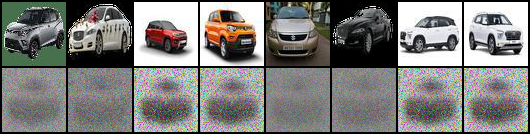

time: 11.6 ms


In [28]:
from IPython.display import Image
display("Output after Epoch 1")
Image('../outputs/vae/output0.png')

'Output after Epoch 1000'

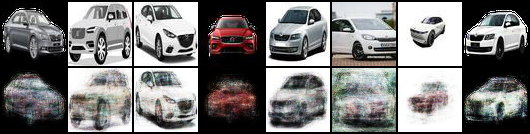

time: 17.3 ms


In [29]:
from IPython.display import Image
display("Output after Epoch 1000")
Image('../outputs/vae/output999.png')

'Output after Epoch 2000'

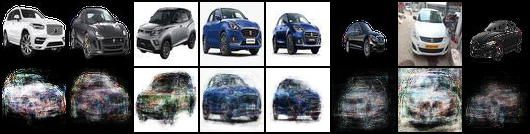

time: 9.18 ms


In [30]:
from IPython.display import Image
display("Output after Epoch 2000")
Image('../outputs/vae/output1999.png')

In [34]:
print('Saving the model')
traced_model = torch.jit.trace(model.to(device).float(), torch.Tensor(3 * 64 * 64).to(device))
torch.jit.save(traced_model, 'model-vae.pt')

Saving the model
time: 287 ms


In [37]:
!pwd

/content/drive/My Drive/eva-4/Phase-2/Session-7/temp
time: 153 ms


In [38]:
!ls

model-vae-05-10-2020.pt  model-vae.pt  __pycache__  train_vae.py
time: 150 ms


In [39]:
import io
import sys

with open('model-vae.pt', 'rb') as fh:
    bytestream = io.BytesIO(fh.read())

print(f'Model Size: {sys.getsizeof(bytestream) // (1024 * 1024)} MB')

Model Size: 48 MB
time: 77.5 ms


In [40]:
print('Loading model')
model = torch.load('model-vae.pt')
print(model)
print('Model loaded')

Loading model
RecursiveScriptModule(
  original_name=LinearVAE
  (encoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
  )
  (decoder): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
  )
)
Model loaded
time: 82.7 ms


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:590: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)
